In [ ]:
import os
import cv2
import random  
import numpy as np
import matplotlib.pyplot as plt 
from keras import Model
from sklearn.model_selection import train_test_split  
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm
from keras.applications import VGG19

#Define blocks to build the generator
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])


def upscale_block(ip):
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

# Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    return disc_model


# Descriminator, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])


In [2]:

lr_list = os.listdir("LR2")

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("LR2/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   


hr_list = os.listdir("HR2")
   
hr_images = []
for img in hr_list:
    img_hr = cv2.imread("HR2/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)


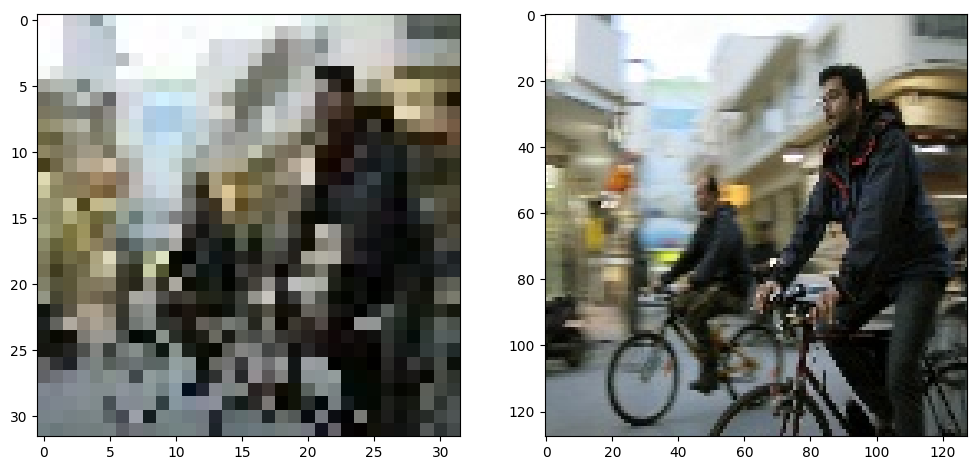

In [ ]:
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()


In [4]:

#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, test_size=0.33, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [ ]:

#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])
    
    
epochs = 5
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)
    generator.save("GAN/gen_e_"+ str(e+1) +".h5")


  0%|          | 0/3350 [00:00<?, ?it/s]

1/1 [==============================] - 1s 521ms/step


  0%|          | 1/3350 [00:32<30:20:46, 32.62s/it]

1/1 [==============================] - 0s 17ms/step


  0%|          | 2/3350 [00:32<12:36:56, 13.57s/it]

1/1 [==============================] - 0s 17ms/step


  0%|          | 3/3350 [00:33<6:56:49,  7.47s/it] 

1/1 [==============================] - 0s 17ms/step


  0%|          | 4/3350 [00:33<4:17:05,  4.61s/it]

1/1 [==============================] - 0s 17ms/step


  0%|          | 5/3350 [00:33<2:50:16,  3.05s/it]

1/1 [==============================] - 0s 16ms/step


  0%|          | 6/3350 [00:33<1:59:13,  2.14s/it]

1/1 [==============================] - 0s 17ms/step


  0%|          | 7/3350 [00:34<1:26:59,  1.56s/it]

1/1 [==============================] - 0s 16ms/step


  0%|          | 8/3350 [00:34<1:04:25,  1.16s/it]

1/1 [==============================] - 0s 17ms/step


  0%|          | 9/3350 [00:34<48:26,  1.15it/s]  

1/1 [==============================] - 0s 18ms/step


  0%|          | 10/3350 [00:35<37:21,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 11/3350 [00:35<29:49,  1.87it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 12/3350 [00:35<24:27,  2.28it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 13/3350 [00:35<21:15,  2.62it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 14/3350 [00:36<18:48,  2.96it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 15/3350 [00:36<17:15,  3.22it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 16/3350 [00:36<15:56,  3.49it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 17/3350 [00:36<15:06,  3.68it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 18/3350 [00:36<14:20,  3.87it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 19/3350 [00:37<13:55,  3.99it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 20/3350 [00:37<13:50,  4.01it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 21/3350 [00:37<14:03,  3.95it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 22/3350 [00:37<13:32,  4.09it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 23/3350 [00:38<13:09,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 24/3350 [00:38<13:02,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 25/3350 [00:38<12:48,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 26/3350 [00:38<12:55,  4.28it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 27/3350 [00:39<13:00,  4.26it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 28/3350 [00:39<12:48,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 29/3350 [00:39<12:36,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 30/3350 [00:39<12:26,  4.45it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 31/3350 [00:39<12:11,  4.54it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 32/3350 [00:40<12:27,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 33/3350 [00:40<12:30,  4.42it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 34/3350 [00:40<12:37,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 35/3350 [00:40<12:41,  4.35it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 36/3350 [00:41<12:29,  4.42it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 37/3350 [00:41<12:37,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 38/3350 [00:41<12:41,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 39/3350 [00:41<12:40,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 40/3350 [00:42<12:57,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 41/3350 [00:42<12:58,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 42/3350 [00:42<13:00,  4.24it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 43/3350 [00:42<12:55,  4.26it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 44/3350 [00:42<12:54,  4.27it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 45/3350 [00:43<12:47,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 46/3350 [00:43<12:51,  4.29it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 47/3350 [00:43<12:48,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 48/3350 [00:43<12:37,  4.36it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 49/3350 [00:44<12:42,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 50/3350 [00:44<12:39,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 51/3350 [00:44<12:47,  4.30it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 52/3350 [00:44<12:35,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 53/3350 [00:45<12:45,  4.31it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 54/3350 [00:45<12:59,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 55/3350 [00:45<12:54,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 56/3350 [00:45<12:58,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 57/3350 [00:45<12:55,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 58/3350 [00:46<12:45,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 59/3350 [00:46<12:45,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 60/3350 [00:46<12:35,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 61/3350 [00:46<12:38,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 62/3350 [00:47<12:33,  4.36it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 63/3350 [00:47<12:52,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 64/3350 [00:47<13:00,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 65/3350 [00:47<12:58,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 66/3350 [00:48<12:54,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 67/3350 [00:48<12:48,  4.27it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 68/3350 [00:48<12:32,  4.36it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 69/3350 [00:48<13:02,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 70/3350 [00:49<12:49,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 71/3350 [00:49<12:40,  4.31it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 72/3350 [00:49<12:25,  4.40it/s]

1/1 [==============================] - 0s 14ms/step


  2%|▏         | 73/3350 [00:49<12:26,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 74/3350 [00:49<12:21,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 75/3350 [00:50<12:19,  4.43it/s]

1/1 [==============================] - 0s 12ms/step


  2%|▏         | 76/3350 [00:50<12:17,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 77/3350 [00:50<12:17,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 78/3350 [00:50<12:19,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 79/3350 [00:51<12:15,  4.45it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 80/3350 [00:51<12:15,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 81/3350 [00:51<12:13,  4.45it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 82/3350 [00:51<12:15,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 83/3350 [00:51<12:25,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 84/3350 [00:52<12:19,  4.42it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 85/3350 [00:52<12:55,  4.21it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 86/3350 [00:52<12:51,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 87/3350 [00:52<12:48,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 88/3350 [00:53<12:48,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 89/3350 [00:53<12:37,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 90/3350 [00:53<12:41,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 91/3350 [00:53<12:50,  4.23it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 92/3350 [00:54<12:46,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 93/3350 [00:54<12:45,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 94/3350 [00:54<12:42,  4.27it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 95/3350 [00:54<12:34,  4.31it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 96/3350 [00:55<12:47,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 97/3350 [00:55<12:40,  4.28it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 98/3350 [00:55<12:30,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 99/3350 [00:55<12:33,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 100/3350 [00:55<12:38,  4.29it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 101/3350 [00:56<12:43,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 102/3350 [00:56<12:45,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 103/3350 [00:56<12:43,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 104/3350 [00:56<12:39,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 105/3350 [00:57<12:48,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 106/3350 [00:57<12:43,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 107/3350 [00:57<12:34,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 108/3350 [00:57<12:57,  4.17it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 109/3350 [00:58<12:52,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 110/3350 [00:58<12:56,  4.17it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 111/3350 [00:58<13:08,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 112/3350 [00:58<13:09,  4.10it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 113/3350 [00:59<12:53,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 114/3350 [00:59<13:11,  4.09it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 115/3350 [00:59<13:08,  4.10it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 116/3350 [00:59<13:11,  4.09it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 117/3350 [01:00<13:09,  4.09it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▎         | 118/3350 [01:00<13:12,  4.08it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 119/3350 [01:00<13:01,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 120/3350 [01:00<12:51,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 121/3350 [01:00<12:33,  4.29it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▎         | 122/3350 [01:01<12:48,  4.20it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 123/3350 [01:01<12:58,  4.15it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 124/3350 [01:01<13:06,  4.10it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 125/3350 [01:01<13:01,  4.12it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 126/3350 [01:02<13:08,  4.09it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 127/3350 [01:02<13:23,  4.01it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 128/3350 [01:02<13:08,  4.09it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 129/3350 [01:02<13:02,  4.12it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 130/3350 [01:03<12:58,  4.14it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 131/3350 [01:03<12:54,  4.16it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 132/3350 [01:03<12:44,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 133/3350 [01:03<12:42,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 134/3350 [01:04<12:48,  4.18it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 135/3350 [01:04<12:42,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 136/3350 [01:04<12:38,  4.24it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 137/3350 [01:04<12:45,  4.20it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 138/3350 [01:05<12:37,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 139/3350 [01:05<12:37,  4.24it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 140/3350 [01:05<12:41,  4.22it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 141/3350 [01:05<12:40,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 142/3350 [01:06<12:59,  4.12it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 143/3350 [01:06<13:02,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 144/3350 [01:06<12:56,  4.13it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 145/3350 [01:06<13:02,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 146/3350 [01:07<13:20,  4.00it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 147/3350 [01:07<13:28,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 148/3350 [01:07<13:44,  3.88it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 149/3350 [01:07<13:46,  3.87it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 150/3350 [01:08<13:33,  3.93it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 151/3350 [01:08<13:35,  3.92it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 152/3350 [01:08<13:21,  3.99it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 153/3350 [01:08<12:55,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 154/3350 [01:09<13:18,  4.00it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 155/3350 [01:09<13:06,  4.06it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 156/3350 [01:09<14:23,  3.70it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 157/3350 [01:09<14:44,  3.61it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 158/3350 [01:10<14:05,  3.78it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 159/3350 [01:10<15:07,  3.52it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 160/3350 [01:10<16:23,  3.24it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 161/3350 [01:11<16:28,  3.23it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 162/3350 [01:11<19:07,  2.78it/s]

1/1 [==============================] - 0s 14ms/step


  5%|▍         | 163/3350 [01:11<17:59,  2.95it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 164/3350 [01:12<16:29,  3.22it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 165/3350 [01:12<15:42,  3.38it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 166/3350 [01:12<15:40,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 167/3350 [01:13<15:38,  3.39it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 168/3350 [01:13<16:13,  3.27it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 169/3350 [01:13<14:56,  3.55it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 170/3350 [01:13<14:28,  3.66it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 171/3350 [01:14<14:07,  3.75it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 172/3350 [01:14<14:05,  3.76it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 173/3350 [01:14<13:41,  3.87it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 174/3350 [01:14<13:09,  4.02it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 175/3350 [01:15<13:06,  4.04it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 176/3350 [01:15<12:38,  4.18it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 177/3350 [01:15<12:30,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 178/3350 [01:15<12:42,  4.16it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 179/3350 [01:16<12:55,  4.09it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 180/3350 [01:16<12:53,  4.10it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 181/3350 [01:16<13:01,  4.05it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 182/3350 [01:16<12:46,  4.13it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 183/3350 [01:16<12:39,  4.17it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 184/3350 [01:17<12:26,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 185/3350 [01:17<12:33,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 186/3350 [01:17<12:37,  4.18it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 187/3350 [01:17<12:42,  4.15it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 188/3350 [01:18<12:49,  4.11it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 189/3350 [01:18<13:31,  3.90it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 190/3350 [01:18<13:37,  3.87it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 191/3350 [01:18<13:19,  3.95it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 192/3350 [01:19<13:05,  4.02it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 193/3350 [01:19<13:03,  4.03it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 194/3350 [01:19<12:46,  4.12it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 195/3350 [01:19<12:28,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 196/3350 [01:20<12:33,  4.19it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 197/3350 [01:20<12:28,  4.21it/s]

1/1 [==============================] - 0s 14ms/step


  6%|▌         | 198/3350 [01:20<12:38,  4.16it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 199/3350 [01:20<12:48,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 200/3350 [01:21<12:41,  4.14it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 201/3350 [01:21<12:36,  4.16it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 202/3350 [01:21<12:25,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 203/3350 [01:21<12:31,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 204/3350 [01:22<12:14,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 205/3350 [01:22<12:08,  4.32it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 206/3350 [01:22<12:45,  4.10it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 207/3350 [01:22<13:37,  3.85it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 208/3350 [01:23<13:24,  3.90it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 209/3350 [01:23<13:14,  3.95it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 210/3350 [01:23<12:53,  4.06it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 211/3350 [01:23<12:34,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 212/3350 [01:24<12:28,  4.19it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 213/3350 [01:24<12:21,  4.23it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 214/3350 [01:24<12:26,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 215/3350 [01:24<12:29,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 216/3350 [01:24<12:28,  4.19it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 217/3350 [01:25<12:54,  4.05it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 218/3350 [01:25<12:57,  4.03it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 219/3350 [01:25<12:43,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 220/3350 [01:25<12:38,  4.13it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 221/3350 [01:26<12:32,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 222/3350 [01:26<12:18,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 223/3350 [01:26<12:28,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 224/3350 [01:26<12:21,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 225/3350 [01:27<12:20,  4.22it/s]

1/1 [==============================] - 0s 14ms/step


  7%|▋         | 226/3350 [01:27<12:24,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 227/3350 [01:27<12:34,  4.14it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 228/3350 [01:27<12:12,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 229/3350 [01:28<12:11,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 230/3350 [01:28<12:17,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 231/3350 [01:28<12:16,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 232/3350 [01:28<12:10,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 233/3350 [01:29<12:03,  4.31it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 234/3350 [01:29<12:02,  4.31it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 235/3350 [01:29<12:07,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 236/3350 [01:29<12:09,  4.27it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 237/3350 [01:29<12:08,  4.27it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 238/3350 [01:30<12:23,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 239/3350 [01:30<12:32,  4.13it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 240/3350 [01:30<12:41,  4.09it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 241/3350 [01:30<12:45,  4.06it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 242/3350 [01:31<12:42,  4.07it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 243/3350 [01:31<12:22,  4.18it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 244/3350 [01:31<12:18,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 245/3350 [01:31<12:16,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 246/3350 [01:32<12:11,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 247/3350 [01:32<12:16,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 248/3350 [01:32<12:04,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 249/3350 [01:32<11:52,  4.35it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 250/3350 [01:33<12:03,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 251/3350 [01:33<12:04,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 252/3350 [01:33<11:57,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 253/3350 [01:33<12:07,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 254/3350 [01:34<12:01,  4.29it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 255/3350 [01:34<12:10,  4.24it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 256/3350 [01:34<12:29,  4.13it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 257/3350 [01:34<12:34,  4.10it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 258/3350 [01:34<12:20,  4.17it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 259/3350 [01:35<12:14,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 260/3350 [01:35<11:55,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 261/3350 [01:35<11:46,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 262/3350 [01:35<12:13,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 263/3350 [01:36<11:58,  4.30it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 264/3350 [01:36<12:02,  4.27it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 265/3350 [01:36<11:53,  4.32it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 266/3350 [01:36<11:48,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 267/3350 [01:37<11:47,  4.36it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 268/3350 [01:37<11:45,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 269/3350 [01:37<11:39,  4.40it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 270/3350 [01:37<11:37,  4.42it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 271/3350 [01:37<11:33,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 272/3350 [01:38<11:58,  4.28it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 273/3350 [01:38<12:19,  4.16it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 274/3350 [01:38<12:24,  4.13it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 275/3350 [01:38<12:47,  4.01it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 276/3350 [01:39<12:44,  4.02it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 277/3350 [01:39<12:28,  4.10it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 278/3350 [01:39<12:23,  4.13it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 279/3350 [01:39<12:11,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 280/3350 [01:40<12:02,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 281/3350 [01:40<12:00,  4.26it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 282/3350 [01:40<11:57,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 283/3350 [01:40<12:03,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 284/3350 [01:41<11:49,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 285/3350 [01:41<11:48,  4.33it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▊         | 286/3350 [01:41<11:49,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 287/3350 [01:41<12:07,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 288/3350 [01:42<12:14,  4.17it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 289/3350 [01:42<12:23,  4.11it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▊         | 290/3350 [01:42<12:15,  4.16it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 291/3350 [01:42<12:00,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 292/3350 [01:42<11:54,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 293/3350 [01:43<11:57,  4.26it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 294/3350 [01:43<12:48,  3.98it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 295/3350 [01:43<12:38,  4.03it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 296/3350 [01:43<12:39,  4.02it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 297/3350 [01:44<12:45,  3.99it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 298/3350 [01:44<12:40,  4.01it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 299/3350 [01:44<13:02,  3.90it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 300/3350 [01:45<12:46,  3.98it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 301/3350 [01:45<12:53,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 302/3350 [01:45<13:00,  3.90it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 303/3350 [01:45<12:54,  3.94it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 304/3350 [01:46<13:00,  3.90it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 305/3350 [01:46<13:19,  3.81it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 306/3350 [01:46<13:07,  3.86it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 307/3350 [01:46<13:16,  3.82it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 308/3350 [01:47<12:54,  3.93it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 309/3350 [01:47<12:41,  4.00it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 310/3350 [01:47<12:34,  4.03it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 311/3350 [01:47<12:47,  3.96it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 312/3350 [01:48<12:42,  3.98it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 313/3350 [01:48<12:26,  4.07it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 314/3350 [01:48<12:17,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 315/3350 [01:48<12:13,  4.14it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 316/3350 [01:48<12:04,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 317/3350 [01:49<11:56,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 318/3350 [01:49<11:50,  4.27it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 319/3350 [01:49<11:39,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 320/3350 [01:49<11:42,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 321/3350 [01:50<12:00,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 322/3350 [01:50<12:10,  4.14it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 323/3350 [01:50<12:07,  4.16it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 324/3350 [01:50<12:16,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 325/3350 [01:51<12:33,  4.01it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 326/3350 [01:51<12:20,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 327/3350 [01:51<12:07,  4.15it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 328/3350 [01:51<12:09,  4.14it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 329/3350 [01:52<12:00,  4.19it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 330/3350 [01:52<11:47,  4.27it/s]

1/1 [==============================] - 0s 13ms/step


 10%|▉         | 331/3350 [01:52<11:51,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 332/3350 [01:52<11:48,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 333/3350 [01:53<11:51,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 334/3350 [01:53<11:56,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 335/3350 [01:53<11:52,  4.23it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 336/3350 [01:53<11:49,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 337/3350 [01:53<11:48,  4.25it/s]

1/1 [==============================] - 0s 8ms/step


 10%|█         | 338/3350 [01:54<11:44,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 339/3350 [01:54<11:40,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 340/3350 [01:54<11:40,  4.30it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 341/3350 [01:54<11:32,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 342/3350 [01:55<11:30,  4.36it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 343/3350 [01:55<11:41,  4.29it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 344/3350 [01:55<11:22,  4.40it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 345/3350 [01:55<11:18,  4.43it/s]

1/1 [==============================] - 0s 13ms/step


 10%|█         | 346/3350 [01:56<11:08,  4.49it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 347/3350 [01:56<11:06,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 348/3350 [01:56<11:22,  4.40it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 349/3350 [01:56<11:17,  4.43it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 350/3350 [01:56<11:12,  4.46it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 351/3350 [01:57<11:18,  4.42it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█         | 352/3350 [01:57<11:18,  4.42it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 353/3350 [01:57<11:16,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 354/3350 [01:57<11:15,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 355/3350 [01:58<11:17,  4.42it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 356/3350 [01:58<11:26,  4.36it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 357/3350 [01:58<11:08,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 358/3350 [01:58<10:51,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 359/3350 [01:58<10:55,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 360/3350 [01:59<10:48,  4.61it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 361/3350 [01:59<10:43,  4.64it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 362/3350 [01:59<10:45,  4.63it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 363/3350 [01:59<10:40,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 364/3350 [02:00<10:41,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 365/3350 [02:00<10:42,  4.65it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 366/3350 [02:00<10:40,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 367/3350 [02:00<10:50,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 368/3350 [02:00<10:51,  4.58it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 369/3350 [02:01<10:46,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 370/3350 [02:01<10:50,  4.58it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 371/3350 [02:01<10:44,  4.62it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 372/3350 [02:01<10:40,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 373/3350 [02:01<10:38,  4.66it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 374/3350 [02:02<10:42,  4.63it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 375/3350 [02:02<10:49,  4.58it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 376/3350 [02:02<10:49,  4.58it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█▏        | 377/3350 [02:02<10:46,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 378/3350 [02:03<10:45,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 379/3350 [02:03<13:18,  3.72it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 380/3350 [02:03<12:31,  3.95it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 381/3350 [02:03<12:13,  4.05it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 382/3350 [02:04<11:50,  4.18it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█▏        | 383/3350 [02:04<11:26,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 384/3350 [02:04<11:20,  4.36it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 385/3350 [02:04<11:31,  4.29it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 386/3350 [02:05<11:21,  4.35it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 387/3350 [02:05<11:08,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 388/3350 [02:05<11:02,  4.47it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 389/3350 [02:05<11:43,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 390/3350 [02:05<11:33,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 391/3350 [02:06<11:26,  4.31it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 392/3350 [02:06<11:26,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 393/3350 [02:06<11:28,  4.29it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 394/3350 [02:06<11:47,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 395/3350 [02:07<11:50,  4.16it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 396/3350 [02:07<11:53,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 397/3350 [02:07<12:02,  4.09it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 398/3350 [02:07<11:52,  4.14it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 399/3350 [02:08<11:50,  4.16it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 400/3350 [02:08<12:03,  4.08it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 401/3350 [02:08<11:40,  4.21it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█▏        | 402/3350 [02:08<11:19,  4.34it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 403/3350 [02:09<11:07,  4.41it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█▏        | 404/3350 [02:09<10:55,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 405/3350 [02:09<11:24,  4.30it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 406/3350 [02:09<11:27,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 407/3350 [02:09<11:28,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 408/3350 [02:10<11:27,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 409/3350 [02:10<11:25,  4.29it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 410/3350 [02:10<11:37,  4.22it/s]

1/1 [==============================] - 0s 11ms/step


 12%|█▏        | 411/3350 [02:10<11:26,  4.28it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 412/3350 [02:11<11:06,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 413/3350 [02:11<11:15,  4.35it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 414/3350 [02:11<11:27,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 415/3350 [02:11<11:52,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 416/3350 [02:12<11:44,  4.16it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 417/3350 [02:12<11:47,  4.15it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 418/3350 [02:12<11:42,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 419/3350 [02:12<11:52,  4.11it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 420/3350 [02:13<11:50,  4.12it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 421/3350 [02:13<11:47,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 422/3350 [02:13<11:35,  4.21it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 423/3350 [02:13<11:34,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 424/3350 [02:13<11:22,  4.29it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 425/3350 [02:14<11:38,  4.19it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 426/3350 [02:14<11:19,  4.31it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 427/3350 [02:14<11:01,  4.42it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 428/3350 [02:14<10:49,  4.50it/s]

1/1 [==============================] - 0s 13ms/step


 13%|█▎        | 429/3350 [02:15<10:54,  4.46it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 430/3350 [02:15<10:46,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 431/3350 [02:15<10:57,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 432/3350 [02:15<11:02,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 433/3350 [02:16<11:31,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 434/3350 [02:16<11:26,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 435/3350 [02:16<11:14,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 436/3350 [02:16<10:57,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 437/3350 [02:16<11:02,  4.40it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 438/3350 [02:17<10:52,  4.46it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 439/3350 [02:17<10:41,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 440/3350 [02:17<10:36,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 441/3350 [02:17<10:37,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 442/3350 [02:18<10:47,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 443/3350 [02:18<10:53,  4.45it/s]

1/1 [==============================] - 0s 12ms/step


 13%|█▎        | 444/3350 [02:18<11:00,  4.40it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 445/3350 [02:18<10:45,  4.50it/s]

1/1 [==============================] - 0s 11ms/step


 13%|█▎        | 446/3350 [02:18<10:36,  4.56it/s]

1/1 [==============================] - 0s 13ms/step


 13%|█▎        | 447/3350 [02:19<10:30,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 448/3350 [02:19<10:49,  4.47it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 449/3350 [02:19<11:02,  4.38it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 450/3350 [02:19<11:16,  4.29it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 451/3350 [02:20<11:14,  4.30it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 452/3350 [02:20<11:03,  4.36it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 453/3350 [02:20<10:52,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 454/3350 [02:20<10:43,  4.50it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▎        | 455/3350 [02:20<10:34,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 456/3350 [02:21<10:33,  4.57it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▎        | 457/3350 [02:21<10:25,  4.63it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▎        | 458/3350 [02:21<10:28,  4.60it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▎        | 459/3350 [02:21<10:22,  4.64it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▎        | 460/3350 [02:22<10:22,  4.64it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 461/3350 [02:22<10:19,  4.66it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 462/3350 [02:22<10:22,  4.64it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 463/3350 [02:22<10:25,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 464/3350 [02:22<10:23,  4.63it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 465/3350 [02:23<10:17,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 466/3350 [02:23<10:19,  4.66it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 467/3350 [02:23<10:14,  4.69it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 468/3350 [02:23<10:12,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 469/3350 [02:23<10:11,  4.71it/s]

1/1 [==============================] - 0s 14ms/step


 14%|█▍        | 470/3350 [02:24<10:09,  4.73it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 471/3350 [02:24<10:14,  4.69it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 472/3350 [02:24<10:07,  4.73it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 473/3350 [02:24<10:16,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 474/3350 [02:24<10:08,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 475/3350 [02:25<10:13,  4.69it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 476/3350 [02:25<10:10,  4.71it/s]

1/1 [==============================] - 0s 13ms/step


 14%|█▍        | 477/3350 [02:25<10:13,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 478/3350 [02:25<10:12,  4.69it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 479/3350 [02:26<10:18,  4.64it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 480/3350 [02:26<10:14,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 481/3350 [02:26<10:23,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 482/3350 [02:26<10:30,  4.55it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 483/3350 [02:26<10:19,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 484/3350 [02:27<10:15,  4.66it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 485/3350 [02:27<10:17,  4.64it/s]

1/1 [==============================] - 0s 14ms/step


 15%|█▍        | 486/3350 [02:27<10:10,  4.69it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 487/3350 [02:27<10:07,  4.71it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 488/3350 [02:28<10:30,  4.54it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 489/3350 [02:28<10:22,  4.60it/s]

1/1 [==============================] - 0s 12ms/step


 15%|█▍        | 490/3350 [02:28<10:11,  4.67it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 491/3350 [02:28<10:05,  4.72it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 492/3350 [02:28<10:00,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 493/3350 [02:29<10:12,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 494/3350 [02:29<10:10,  4.68it/s]

1/1 [==============================] - 0s 14ms/step


 15%|█▍        | 495/3350 [02:29<10:14,  4.65it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 496/3350 [02:29<10:20,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 497/3350 [02:29<10:14,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 498/3350 [02:30<10:09,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 499/3350 [02:30<10:11,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 500/3350 [02:30<10:03,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 501/3350 [02:30<10:05,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 502/3350 [02:31<10:08,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 503/3350 [02:31<10:18,  4.61it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 504/3350 [02:31<10:17,  4.61it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▌        | 505/3350 [02:31<10:13,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 506/3350 [02:31<10:22,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 507/3350 [02:32<10:18,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 508/3350 [02:32<10:18,  4.59it/s]

1/1 [==============================] - 0s 14ms/step


 15%|█▌        | 509/3350 [02:32<10:23,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 510/3350 [02:32<10:56,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 511/3350 [02:33<10:45,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 512/3350 [02:33<10:30,  4.50it/s]

1/1 [==============================] - 0s 14ms/step


 15%|█▌        | 513/3350 [02:33<10:30,  4.50it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 514/3350 [02:33<10:22,  4.55it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 515/3350 [02:33<10:10,  4.64it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 516/3350 [02:34<10:07,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 517/3350 [02:34<10:05,  4.68it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 518/3350 [02:34<10:02,  4.70it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 519/3350 [02:34<09:56,  4.75it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 520/3350 [02:34<10:03,  4.69it/s]

1/1 [==============================] - 0s 12ms/step


 16%|█▌        | 521/3350 [02:35<09:58,  4.72it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 522/3350 [02:35<10:03,  4.68it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 523/3350 [02:35<10:06,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 524/3350 [02:35<10:10,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 525/3350 [02:36<10:14,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 526/3350 [02:36<10:10,  4.62it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 527/3350 [02:36<10:04,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 528/3350 [02:36<10:09,  4.63it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▌        | 529/3350 [02:36<10:09,  4.63it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█▌        | 530/3350 [02:37<10:05,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 531/3350 [02:37<10:05,  4.66it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 532/3350 [02:37<10:04,  4.66it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 533/3350 [02:37<10:06,  4.65it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 534/3350 [02:37<10:04,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 535/3350 [02:38<10:00,  4.69it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 536/3350 [02:38<10:00,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 537/3350 [02:38<09:56,  4.72it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 538/3350 [02:38<10:00,  4.68it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 539/3350 [02:39<10:09,  4.61it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▌        | 540/3350 [02:39<10:04,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 541/3350 [02:39<10:03,  4.65it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▌        | 542/3350 [02:39<10:05,  4.64it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 543/3350 [02:39<10:08,  4.62it/s]

1/1 [==============================] - 0s 13ms/step


 16%|█▌        | 544/3350 [02:40<10:03,  4.65it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 545/3350 [02:40<10:04,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 546/3350 [02:40<10:02,  4.66it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▋        | 547/3350 [02:40<09:56,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 548/3350 [02:40<10:01,  4.66it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 549/3350 [02:41<10:05,  4.63it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▋        | 550/3350 [02:41<10:06,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 551/3350 [02:41<10:06,  4.61it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 552/3350 [02:41<10:23,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 553/3350 [02:42<10:09,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 554/3350 [02:42<10:06,  4.61it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 555/3350 [02:42<09:57,  4.68it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 556/3350 [02:42<09:54,  4.70it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 557/3350 [02:42<09:58,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 558/3350 [02:43<09:59,  4.66it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 559/3350 [02:43<10:04,  4.61it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 560/3350 [02:43<09:56,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 561/3350 [02:43<09:51,  4.72it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 562/3350 [02:43<09:49,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 563/3350 [02:44<09:55,  4.68it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 564/3350 [02:44<09:53,  4.69it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 565/3350 [02:44<10:05,  4.60it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 566/3350 [02:44<10:00,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 567/3350 [02:45<09:55,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 568/3350 [02:45<09:54,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 569/3350 [02:45<09:49,  4.72it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 570/3350 [02:45<09:55,  4.67it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 571/3350 [02:45<09:51,  4.69it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 572/3350 [02:46<09:45,  4.75it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 573/3350 [02:46<09:41,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 574/3350 [02:46<09:40,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 575/3350 [02:46<09:38,  4.80it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 576/3350 [02:46<09:41,  4.77it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 577/3350 [02:47<09:47,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 578/3350 [02:47<09:48,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 579/3350 [02:47<09:46,  4.73it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█▋        | 580/3350 [02:47<09:44,  4.74it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 581/3350 [02:47<09:45,  4.73it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 582/3350 [02:48<09:49,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 583/3350 [02:48<09:57,  4.63it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 584/3350 [02:48<10:01,  4.60it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 585/3350 [02:48<09:53,  4.66it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 586/3350 [02:49<09:49,  4.69it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 587/3350 [02:49<09:51,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 588/3350 [02:49<09:44,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 589/3350 [02:49<09:50,  4.68it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 590/3350 [02:49<09:54,  4.64it/s]

1/1 [==============================] - 0s 14ms/step


 18%|█▊        | 591/3350 [02:50<09:48,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 592/3350 [02:50<09:50,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 593/3350 [02:50<09:52,  4.65it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 594/3350 [02:50<09:50,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 595/3350 [02:51<09:53,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 596/3350 [02:51<10:02,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 597/3350 [02:51<10:00,  4.59it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 598/3350 [02:51<09:50,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 599/3350 [02:51<09:55,  4.62it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 600/3350 [02:52<09:55,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 601/3350 [02:52<09:52,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 602/3350 [02:52<09:46,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


 18%|█▊        | 603/3350 [02:52<09:50,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 604/3350 [02:52<09:54,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 605/3350 [02:53<09:55,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 606/3350 [02:53<09:47,  4.67it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 607/3350 [02:53<09:49,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 608/3350 [02:53<10:00,  4.57it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 609/3350 [02:54<09:52,  4.63it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 610/3350 [02:54<09:50,  4.64it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 611/3350 [02:54<09:43,  4.69it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 612/3350 [02:54<09:45,  4.68it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 613/3350 [02:54<09:53,  4.61it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 614/3350 [02:55<10:06,  4.51it/s]

1/1 [==============================] - 0s 13ms/step


 18%|█▊        | 615/3350 [02:55<10:03,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 616/3350 [02:55<09:53,  4.60it/s]

1/1 [==============================] - 0s 14ms/step


 18%|█▊        | 617/3350 [02:55<10:02,  4.54it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 618/3350 [02:55<09:50,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 619/3350 [02:56<09:50,  4.63it/s]

1/1 [==============================] - 0s 14ms/step


 19%|█▊        | 620/3350 [02:56<09:51,  4.62it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▊        | 621/3350 [02:56<09:57,  4.57it/s]

1/1 [==============================] - 0s 14ms/step


 19%|█▊        | 622/3350 [02:56<09:55,  4.58it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 623/3350 [02:57<09:49,  4.62it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▊        | 624/3350 [02:57<09:53,  4.59it/s]

1/1 [==============================] - 0s 14ms/step


 19%|█▊        | 625/3350 [02:57<09:42,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 626/3350 [02:57<09:53,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 627/3350 [02:57<09:43,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 628/3350 [02:58<09:47,  4.63it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 629/3350 [02:58<09:43,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 630/3350 [02:58<09:39,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 631/3350 [02:58<09:37,  4.71it/s]

1/1 [==============================] - 0s 14ms/step


 19%|█▉        | 632/3350 [02:58<09:34,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 633/3350 [02:59<09:40,  4.68it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 634/3350 [02:59<09:43,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 635/3350 [02:59<09:41,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 636/3350 [02:59<09:41,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 637/3350 [03:00<09:34,  4.72it/s]

1/1 [==============================] - 0s 14ms/step


 19%|█▉        | 638/3350 [03:00<09:42,  4.66it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 639/3350 [03:00<09:36,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 640/3350 [03:00<09:36,  4.70it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 641/3350 [03:00<09:35,  4.71it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 642/3350 [03:01<09:43,  4.64it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 643/3350 [03:01<09:38,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 644/3350 [03:01<09:39,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 645/3350 [03:01<09:37,  4.68it/s]

1/1 [==============================] - 0s 12ms/step


 19%|█▉        | 646/3350 [03:01<09:31,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 647/3350 [03:02<09:42,  4.64it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 648/3350 [03:02<09:43,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 649/3350 [03:02<09:47,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


 19%|█▉        | 650/3350 [03:02<09:53,  4.55it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 651/3350 [03:03<09:44,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 652/3350 [03:03<09:37,  4.68it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 653/3350 [03:03<09:30,  4.73it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 654/3350 [03:03<09:40,  4.65it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 655/3350 [03:03<09:34,  4.69it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 656/3350 [03:04<09:47,  4.59it/s]

1/1 [==============================] - 0s 15ms/step


 20%|█▉        | 657/3350 [03:04<09:38,  4.65it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 658/3350 [03:04<09:37,  4.66it/s]

1/1 [==============================] - 0s 12ms/step


 20%|█▉        | 659/3350 [03:04<09:34,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 660/3350 [03:04<09:29,  4.72it/s]

1/1 [==============================] - 0s 14ms/step


 20%|█▉        | 661/3350 [03:05<09:32,  4.70it/s]

1/1 [==============================] - 0s 15ms/step


 20%|█▉        | 662/3350 [03:05<09:30,  4.71it/s]

1/1 [==============================] - 0s 15ms/step


 20%|█▉        | 663/3350 [03:05<09:28,  4.73it/s]

1/1 [==============================] - 0s 15ms/step


 20%|█▉        | 664/3350 [03:05<09:33,  4.69it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 665/3350 [03:06<09:33,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 666/3350 [03:06<09:30,  4.70it/s]

1/1 [==============================] - 0s 15ms/step


 20%|█▉        | 667/3350 [03:06<09:31,  4.69it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 668/3350 [03:06<09:37,  4.64it/s]

1/1 [==============================] - 0s 15ms/step


 20%|█▉        | 669/3350 [03:06<09:38,  4.64it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 670/3350 [03:07<09:34,  4.67it/s]

1/1 [==============================] - 0s 12ms/step


 20%|██        | 671/3350 [03:07<09:30,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 672/3350 [03:07<09:24,  4.74it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 673/3350 [03:07<09:32,  4.67it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 674/3350 [03:07<09:33,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 675/3350 [03:08<09:39,  4.62it/s]

1/1 [==============================] - 0s 14ms/step


 20%|██        | 676/3350 [03:08<09:37,  4.63it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 677/3350 [03:08<09:31,  4.67it/s]

1/1 [==============================] - 0s 13ms/step


 20%|██        | 678/3350 [03:08<09:29,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 679/3350 [03:09<09:32,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 680/3350 [03:09<09:30,  4.68it/s]

1/1 [==============================] - 0s 13ms/step


 20%|██        | 681/3350 [03:09<09:24,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 682/3350 [03:09<09:29,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 683/3350 [03:09<09:24,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 684/3350 [03:10<09:25,  4.72it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 685/3350 [03:10<09:37,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 686/3350 [03:10<09:26,  4.70it/s]

1/1 [==============================] - 0s 11ms/step


 21%|██        | 687/3350 [03:10<09:24,  4.72it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 688/3350 [03:10<09:26,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 689/3350 [03:11<09:27,  4.69it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 690/3350 [03:11<09:31,  4.66it/s]

1/1 [==============================] - 0s 14ms/step


 21%|██        | 691/3350 [03:11<09:29,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 692/3350 [03:11<09:25,  4.70it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 693/3350 [03:12<09:28,  4.67it/s]

1/1 [==============================] - 0s 14ms/step


 21%|██        | 694/3350 [03:12<09:33,  4.63it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 695/3350 [03:12<09:27,  4.68it/s]

1/1 [==============================] - 0s 14ms/step


 21%|██        | 696/3350 [03:12<09:23,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 697/3350 [03:12<09:27,  4.67it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 698/3350 [03:13<09:23,  4.70it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 699/3350 [03:13<09:24,  4.70it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 700/3350 [03:13<09:19,  4.74it/s]

1/1 [==============================] - 0s 14ms/step


 21%|██        | 701/3350 [03:13<09:20,  4.73it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 702/3350 [03:13<09:30,  4.64it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 703/3350 [03:14<09:29,  4.65it/s]

1/1 [==============================] - 0s 14ms/step


 21%|██        | 704/3350 [03:14<09:22,  4.70it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 705/3350 [03:14<09:29,  4.64it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 706/3350 [03:14<09:27,  4.66it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 707/3350 [03:15<09:21,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 708/3350 [03:15<09:32,  4.61it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 709/3350 [03:15<09:25,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 710/3350 [03:15<09:35,  4.59it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 711/3350 [03:15<09:30,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 712/3350 [03:16<09:30,  4.62it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 713/3350 [03:16<09:28,  4.64it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 714/3350 [03:16<09:32,  4.60it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 715/3350 [03:16<09:27,  4.65it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 716/3350 [03:16<09:26,  4.65it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 717/3350 [03:17<09:29,  4.63it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██▏       | 718/3350 [03:17<09:22,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 719/3350 [03:17<09:27,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 720/3350 [03:17<09:31,  4.60it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 721/3350 [03:18<09:29,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 722/3350 [03:18<09:37,  4.55it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 723/3350 [03:18<09:27,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 724/3350 [03:18<09:24,  4.65it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 725/3350 [03:18<09:16,  4.71it/s]

1/1 [==============================] - 0s 14ms/step


 22%|██▏       | 726/3350 [03:19<09:19,  4.69it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██▏       | 727/3350 [03:19<09:19,  4.69it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 728/3350 [03:19<09:26,  4.63it/s]

1/1 [==============================] - 0s 14ms/step


 22%|██▏       | 729/3350 [03:19<09:20,  4.68it/s]

1/1 [==============================] - 0s 14ms/step


 22%|██▏       | 730/3350 [03:19<09:21,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 731/3350 [03:20<09:22,  4.65it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 732/3350 [03:20<09:23,  4.65it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 733/3350 [03:20<09:18,  4.69it/s]

1/1 [==============================] - 0s 13ms/step


 22%|██▏       | 734/3350 [03:20<09:14,  4.72it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 735/3350 [03:21<09:20,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 736/3350 [03:21<09:22,  4.65it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 737/3350 [03:21<09:17,  4.69it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 738/3350 [03:21<09:16,  4.70it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 739/3350 [03:21<09:27,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 740/3350 [03:22<09:19,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 741/3350 [03:22<09:24,  4.62it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 742/3350 [03:22<09:18,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 743/3350 [03:22<09:19,  4.66it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 744/3350 [03:22<09:17,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 745/3350 [03:23<09:15,  4.69it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 746/3350 [03:23<09:15,  4.69it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 747/3350 [03:23<09:24,  4.61it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 748/3350 [03:23<09:20,  4.64it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 749/3350 [03:24<09:17,  4.67it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 750/3350 [03:24<09:21,  4.63it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 751/3350 [03:24<09:18,  4.65it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 752/3350 [03:24<09:13,  4.69it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 753/3350 [03:24<09:09,  4.73it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 754/3350 [03:25<09:09,  4.72it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 755/3350 [03:25<09:14,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 756/3350 [03:25<09:16,  4.66it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 757/3350 [03:25<09:17,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 758/3350 [03:25<09:16,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 759/3350 [03:26<09:13,  4.68it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 760/3350 [03:26<09:15,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 761/3350 [03:26<09:16,  4.66it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 762/3350 [03:26<09:17,  4.64it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 763/3350 [03:27<09:17,  4.64it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 764/3350 [03:27<09:15,  4.66it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 765/3350 [03:27<09:22,  4.59it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 766/3350 [03:27<09:30,  4.53it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 767/3350 [03:27<09:19,  4.62it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 768/3350 [03:28<09:15,  4.65it/s]

1/1 [==============================] - 0s 14ms/step


 23%|██▎       | 769/3350 [03:28<09:09,  4.70it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 770/3350 [03:28<09:09,  4.70it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 771/3350 [03:28<09:09,  4.69it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 772/3350 [03:29<09:14,  4.65it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 773/3350 [03:29<09:20,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 774/3350 [03:29<09:20,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 775/3350 [03:29<09:15,  4.63it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 776/3350 [03:29<09:12,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 777/3350 [03:30<09:16,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 778/3350 [03:30<09:11,  4.66it/s]

1/1 [==============================] - 0s 14ms/step


 23%|██▎       | 779/3350 [03:30<09:14,  4.63it/s]

1/1 [==============================] - 0s 14ms/step


 23%|██▎       | 780/3350 [03:30<09:10,  4.67it/s]

1/1 [==============================] - 0s 14ms/step


 23%|██▎       | 781/3350 [03:30<09:04,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 782/3350 [03:31<09:11,  4.65it/s]

1/1 [==============================] - 0s 14ms/step


 23%|██▎       | 783/3350 [03:31<09:08,  4.68it/s]

1/1 [==============================] - 0s 13ms/step


 23%|██▎       | 784/3350 [03:31<09:04,  4.71it/s]

1/1 [==============================] - 0s 13ms/step


 23%|██▎       | 785/3350 [03:31<09:00,  4.75it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 786/3350 [03:32<09:04,  4.71it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 787/3350 [03:32<09:16,  4.60it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 788/3350 [03:32<09:12,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 789/3350 [03:32<09:10,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 790/3350 [03:32<09:03,  4.71it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 791/3350 [03:33<09:06,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 792/3350 [03:33<09:19,  4.57it/s]

1/1 [==============================] - 0s 11ms/step


 24%|██▎       | 793/3350 [03:33<09:15,  4.61it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 794/3350 [03:33<09:17,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 795/3350 [03:33<09:07,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 796/3350 [03:34<09:06,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 797/3350 [03:34<09:12,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 798/3350 [03:34<09:09,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 799/3350 [03:34<09:10,  4.63it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 800/3350 [03:35<09:06,  4.67it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 801/3350 [03:35<09:06,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 802/3350 [03:35<09:12,  4.61it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 803/3350 [03:35<09:08,  4.64it/s]

1/1 [==============================] - 0s 13ms/step


 24%|██▍       | 804/3350 [03:35<09:04,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 805/3350 [03:36<09:04,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 806/3350 [03:36<09:01,  4.69it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 807/3350 [03:36<09:02,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 808/3350 [03:36<09:04,  4.66it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 809/3350 [03:36<08:59,  4.71it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 810/3350 [03:37<09:01,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 811/3350 [03:37<09:02,  4.68it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 812/3350 [03:37<09:29,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 813/3350 [03:37<09:18,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 814/3350 [03:38<09:11,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 815/3350 [03:38<09:12,  4.59it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 816/3350 [03:38<09:14,  4.57it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 817/3350 [03:38<09:22,  4.51it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 818/3350 [03:38<09:15,  4.56it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 819/3350 [03:39<09:09,  4.60it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 820/3350 [03:39<09:08,  4.62it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▍       | 821/3350 [03:39<09:10,  4.59it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 822/3350 [03:39<09:15,  4.55it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 823/3350 [03:40<09:09,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 824/3350 [03:40<09:12,  4.57it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▍       | 825/3350 [03:40<09:05,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 826/3350 [03:40<09:00,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 827/3350 [03:40<09:00,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 828/3350 [03:41<09:05,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 829/3350 [03:41<09:04,  4.63it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 830/3350 [03:41<09:01,  4.65it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 831/3350 [03:41<08:59,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 832/3350 [03:41<09:01,  4.65it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 833/3350 [03:42<09:03,  4.63it/s]

1/1 [==============================] - 0s 13ms/step


 25%|██▍       | 834/3350 [03:42<08:57,  4.68it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 835/3350 [03:42<08:57,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 836/3350 [03:42<09:04,  4.62it/s]

1/1 [==============================] - 0s 14ms/step


 25%|██▍       | 837/3350 [03:43<09:03,  4.62it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 838/3350 [03:43<09:11,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 839/3350 [03:43<09:08,  4.57it/s]

1/1 [==============================] - 0s 13ms/step


 25%|██▌       | 840/3350 [03:43<09:01,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 841/3350 [03:43<08:58,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 842/3350 [03:44<09:01,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 843/3350 [03:44<09:01,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 844/3350 [03:44<09:04,  4.60it/s]

1/1 [==============================] - 0s 14ms/step


 25%|██▌       | 845/3350 [03:44<08:58,  4.65it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▌       | 846/3350 [03:44<08:52,  4.70it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 847/3350 [03:45<09:06,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 848/3350 [03:45<09:05,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 849/3350 [03:45<08:59,  4.63it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 850/3350 [03:45<08:54,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 851/3350 [03:46<08:53,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 852/3350 [03:46<09:03,  4.59it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 853/3350 [03:46<09:02,  4.60it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 854/3350 [03:46<09:02,  4.60it/s]

1/1 [==============================] - 0s 14ms/step


 26%|██▌       | 855/3350 [03:46<08:57,  4.64it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 856/3350 [03:47<09:02,  4.60it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 857/3350 [03:47<09:02,  4.60it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 858/3350 [03:47<08:57,  4.64it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 859/3350 [03:47<08:53,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 860/3350 [03:47<08:48,  4.71it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 861/3350 [03:48<08:53,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 862/3350 [03:48<08:54,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 863/3350 [03:48<08:59,  4.61it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 864/3350 [03:48<08:55,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 865/3350 [03:49<08:54,  4.65it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 866/3350 [03:49<08:54,  4.65it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 867/3350 [03:49<08:55,  4.64it/s]

1/1 [==============================] - 0s 13ms/step


 26%|██▌       | 868/3350 [03:49<08:52,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 869/3350 [03:49<08:54,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 870/3350 [03:50<08:54,  4.64it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 871/3350 [03:50<08:56,  4.62it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 872/3350 [03:50<09:09,  4.51it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 873/3350 [03:50<09:03,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 874/3350 [03:51<08:58,  4.60it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 875/3350 [03:51<08:53,  4.64it/s]

1/1 [==============================] - 0s 12ms/step


 26%|██▌       | 876/3350 [03:51<08:57,  4.60it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 877/3350 [03:51<09:02,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 878/3350 [03:51<08:57,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 879/3350 [03:52<08:52,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 880/3350 [03:52<08:57,  4.60it/s]

1/1 [==============================] - 0s 14ms/step


 26%|██▋       | 881/3350 [03:52<08:52,  4.64it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▋       | 882/3350 [03:52<08:51,  4.65it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▋       | 883/3350 [03:52<08:50,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 884/3350 [03:53<08:50,  4.65it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▋       | 885/3350 [03:53<09:01,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 886/3350 [03:53<08:58,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 887/3350 [03:53<08:59,  4.56it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 888/3350 [03:54<08:52,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 889/3350 [03:54<09:00,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 890/3350 [03:54<08:53,  4.61it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 891/3350 [03:54<08:55,  4.59it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██▋       | 892/3350 [03:54<08:49,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 893/3350 [03:55<08:49,  4.64it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 894/3350 [03:55<08:48,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 895/3350 [03:55<08:46,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 896/3350 [03:55<08:44,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 897/3350 [03:55<08:40,  4.71it/s]

1/1 [==============================] - 0s 14ms/step


 27%|██▋       | 898/3350 [03:56<08:47,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 899/3350 [03:56<08:44,  4.67it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██▋       | 900/3350 [03:56<08:38,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 901/3350 [03:56<08:50,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 902/3350 [03:57<08:46,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 903/3350 [03:57<08:43,  4.67it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 904/3350 [03:57<08:40,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 905/3350 [03:57<08:43,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 906/3350 [03:57<08:45,  4.65it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██▋       | 907/3350 [03:58<08:44,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 908/3350 [03:58<08:47,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 909/3350 [03:58<08:42,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 910/3350 [03:58<08:50,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 911/3350 [03:59<08:41,  4.68it/s]

1/1 [==============================] - 0s 14ms/step


 27%|██▋       | 912/3350 [03:59<08:41,  4.68it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 913/3350 [03:59<08:37,  4.71it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 914/3350 [03:59<08:43,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


 27%|██▋       | 915/3350 [03:59<08:40,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 916/3350 [04:00<08:34,  4.73it/s]

1/1 [==============================] - 0s 14ms/step


 27%|██▋       | 917/3350 [04:00<08:37,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 918/3350 [04:00<08:38,  4.69it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 919/3350 [04:00<08:48,  4.60it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 920/3350 [04:00<08:42,  4.65it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██▋       | 921/3350 [04:01<08:36,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 922/3350 [04:01<08:36,  4.70it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 923/3350 [04:01<08:36,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 924/3350 [04:01<08:32,  4.73it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██▊       | 925/3350 [04:01<08:32,  4.73it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 926/3350 [04:02<08:39,  4.66it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 927/3350 [04:02<08:39,  4.66it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 928/3350 [04:02<08:38,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 929/3350 [04:02<08:39,  4.66it/s]

1/1 [==============================] - 0s 14ms/step


 28%|██▊       | 930/3350 [04:03<08:34,  4.70it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 931/3350 [04:03<08:46,  4.59it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 932/3350 [04:03<08:44,  4.61it/s]

1/1 [==============================] - 0s 11ms/step


 28%|██▊       | 933/3350 [04:03<08:44,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 934/3350 [04:03<08:49,  4.57it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 935/3350 [04:04<08:44,  4.60it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 936/3350 [04:04<08:42,  4.62it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 937/3350 [04:04<08:52,  4.53it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██▊       | 938/3350 [04:04<08:51,  4.54it/s]

1/1 [==============================] - 0s 14ms/step


 28%|██▊       | 939/3350 [04:05<08:43,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 940/3350 [04:05<09:01,  4.45it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 941/3350 [04:05<08:49,  4.55it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 942/3350 [04:05<08:41,  4.62it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 943/3350 [04:05<08:35,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 944/3350 [04:06<08:32,  4.69it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 945/3350 [04:06<08:37,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 946/3350 [04:06<08:36,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 947/3350 [04:06<08:38,  4.63it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 948/3350 [04:06<08:34,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 949/3350 [04:07<08:34,  4.66it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 950/3350 [04:07<08:39,  4.62it/s]

1/1 [==============================] - 0s 13ms/step


 28%|██▊       | 951/3350 [04:07<08:36,  4.65it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 952/3350 [04:07<08:31,  4.69it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 953/3350 [04:08<08:26,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 954/3350 [04:08<08:38,  4.62it/s]

1/1 [==============================] - 0s 14ms/step


 29%|██▊       | 955/3350 [04:08<08:40,  4.60it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▊       | 956/3350 [04:08<08:35,  4.64it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▊       | 957/3350 [04:08<08:30,  4.69it/s]

1/1 [==============================] - 0s 14ms/step


 29%|██▊       | 958/3350 [04:09<08:32,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▊       | 959/3350 [04:09<08:38,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 960/3350 [04:09<08:40,  4.60it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▊       | 961/3350 [04:09<08:35,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 962/3350 [04:09<08:27,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 963/3350 [04:10<08:29,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 964/3350 [04:10<08:33,  4.64it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 965/3350 [04:10<08:32,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 966/3350 [04:10<08:27,  4.69it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▉       | 967/3350 [04:11<08:24,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 968/3350 [04:11<08:28,  4.68it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▉       | 969/3350 [04:11<08:25,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 970/3350 [04:11<08:20,  4.75it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 971/3350 [04:11<08:24,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 972/3350 [04:12<08:29,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 973/3350 [04:12<08:53,  4.46it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 974/3350 [04:12<08:40,  4.56it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 975/3350 [04:12<08:40,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 976/3350 [04:12<08:31,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 977/3350 [04:13<08:33,  4.62it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 978/3350 [04:13<08:31,  4.64it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 979/3350 [04:13<08:26,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 980/3350 [04:13<08:29,  4.65it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 981/3350 [04:14<08:30,  4.64it/s]

1/1 [==============================] - 0s 14ms/step


 29%|██▉       | 982/3350 [04:14<08:41,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 983/3350 [04:14<08:36,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 984/3350 [04:14<08:32,  4.62it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▉       | 985/3350 [04:14<08:26,  4.67it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██▉       | 986/3350 [04:15<08:21,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 987/3350 [04:15<08:25,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 988/3350 [04:15<08:23,  4.69it/s]

1/1 [==============================] - 0s 14ms/step


 30%|██▉       | 989/3350 [04:15<08:20,  4.72it/s]

1/1 [==============================] - 0s 14ms/step


 30%|██▉       | 990/3350 [04:15<08:17,  4.75it/s]

1/1 [==============================] - 0s 15ms/step


 30%|██▉       | 991/3350 [04:16<08:39,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 992/3350 [04:16<08:27,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 993/3350 [04:16<08:25,  4.66it/s]

1/1 [==============================] - 0s 15ms/step


 30%|██▉       | 994/3350 [04:16<08:20,  4.71it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 995/3350 [04:17<08:24,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 996/3350 [04:17<08:24,  4.66it/s]

1/1 [==============================] - 0s 15ms/step


 30%|██▉       | 997/3350 [04:17<08:29,  4.61it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 998/3350 [04:17<08:30,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 999/3350 [04:17<08:23,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 1000/3350 [04:18<08:32,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 1001/3350 [04:18<08:26,  4.64it/s]

1/1 [==============================] - 0s 15ms/step


 30%|██▉       | 1002/3350 [04:18<08:25,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 1003/3350 [04:18<08:20,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 1004/3350 [04:19<08:20,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


 30%|███       | 1005/3350 [04:19<08:32,  4.57it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███       | 1006/3350 [04:19<08:35,  4.54it/s]

1/1 [==============================] - 0s 15ms/step


 30%|███       | 1007/3350 [04:19<08:30,  4.59it/s]

1/1 [==============================] - 0s 15ms/step


 30%|███       | 1008/3350 [04:19<08:29,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 1009/3350 [04:20<08:28,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


 30%|███       | 1010/3350 [04:20<08:36,  4.53it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███       | 1011/3350 [04:20<08:27,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 1012/3350 [04:20<08:33,  4.55it/s]

1/1 [==============================] - 0s 15ms/step


 30%|███       | 1013/3350 [04:20<08:29,  4.59it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 1014/3350 [04:21<08:27,  4.61it/s]

1/1 [==============================] - 0s 15ms/step


 30%|███       | 1015/3350 [04:21<08:21,  4.65it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 1016/3350 [04:21<08:24,  4.62it/s]

1/1 [==============================] - 0s 11ms/step


 30%|███       | 1017/3350 [04:21<08:25,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1018/3350 [04:22<08:22,  4.64it/s]

1/1 [==============================] - 0s 11ms/step


 30%|███       | 1019/3350 [04:22<08:26,  4.60it/s]

1/1 [==============================] - 0s 15ms/step


 30%|███       | 1020/3350 [04:22<08:23,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 1021/3350 [04:22<08:20,  4.66it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 1022/3350 [04:22<08:19,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 1023/3350 [04:23<08:17,  4.68it/s]

1/1 [==============================] - 0s 14ms/step


 31%|███       | 1024/3350 [04:23<08:14,  4.70it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 1025/3350 [04:23<08:26,  4.59it/s]

1/1 [==============================] - 0s 14ms/step


 31%|███       | 1026/3350 [04:23<08:20,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 1027/3350 [04:23<08:20,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 1028/3350 [04:24<08:17,  4.67it/s]

1/1 [==============================] - 0s 15ms/step


 31%|███       | 1029/3350 [04:24<08:13,  4.70it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 1030/3350 [04:24<08:10,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 1031/3350 [04:24<08:11,  4.72it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 1032/3350 [04:25<08:10,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 1033/3350 [04:25<08:08,  4.74it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 1034/3350 [04:25<08:06,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 1035/3350 [04:25<08:16,  4.66it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 1036/3350 [04:25<08:22,  4.60it/s]

1/1 [==============================] - 0s 15ms/step


 31%|███       | 1037/3350 [04:26<08:19,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 1038/3350 [04:26<08:13,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 1039/3350 [04:26<08:09,  4.72it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 1040/3350 [04:26<08:15,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 1041/3350 [04:26<08:09,  4.71it/s]

1/1 [==============================] - 0s 14ms/step


 31%|███       | 1042/3350 [04:27<08:17,  4.64it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 1043/3350 [04:27<08:13,  4.67it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1044/3350 [04:27<08:16,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 1045/3350 [04:27<08:20,  4.60it/s]

1/1 [==============================] - 0s 15ms/step


 31%|███       | 1046/3350 [04:28<08:29,  4.53it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 1047/3350 [04:28<08:38,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 1048/3350 [04:28<08:48,  4.36it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 1049/3350 [04:28<09:01,  4.25it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███▏      | 1050/3350 [04:29<09:39,  3.97it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 1051/3350 [04:29<09:21,  4.09it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 1052/3350 [04:29<09:14,  4.15it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 1053/3350 [04:29<09:12,  4.16it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███▏      | 1054/3350 [04:30<09:20,  4.09it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 1055/3350 [04:30<09:19,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1056/3350 [04:30<09:00,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1057/3350 [04:30<08:55,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 1058/3350 [04:30<09:00,  4.24it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1059/3350 [04:31<09:05,  4.20it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1060/3350 [04:31<09:12,  4.15it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1061/3350 [04:31<09:15,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 1062/3350 [04:31<09:27,  4.03it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1063/3350 [04:32<09:33,  3.99it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1064/3350 [04:32<09:22,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1065/3350 [04:32<09:17,  4.10it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1066/3350 [04:32<09:19,  4.09it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1067/3350 [04:33<09:34,  3.97it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1068/3350 [04:33<09:27,  4.02it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 1069/3350 [04:33<09:07,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1070/3350 [04:33<08:59,  4.22it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1071/3350 [04:34<09:06,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1072/3350 [04:34<08:53,  4.27it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 1073/3350 [04:34<08:46,  4.32it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 1074/3350 [04:34<08:40,  4.37it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 1075/3350 [04:35<08:58,  4.23it/s]

1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 1076/3350 [04:35<08:45,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 1077/3350 [04:35<08:35,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1078/3350 [04:35<08:40,  4.36it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1079/3350 [04:36<09:01,  4.19it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1080/3350 [04:36<09:09,  4.13it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1081/3350 [04:36<09:05,  4.16it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 1082/3350 [04:36<09:03,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1083/3350 [04:36<09:00,  4.20it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1084/3350 [04:37<09:09,  4.13it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1085/3350 [04:37<09:13,  4.10it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1086/3350 [04:37<09:03,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 1087/3350 [04:37<09:04,  4.16it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1088/3350 [04:38<09:10,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1089/3350 [04:38<09:04,  4.15it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 1090/3350 [04:38<09:03,  4.16it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1091/3350 [04:38<09:08,  4.12it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1092/3350 [04:39<09:09,  4.11it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1093/3350 [04:39<09:08,  4.11it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1094/3350 [04:39<09:10,  4.10it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1095/3350 [04:39<09:06,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1096/3350 [04:40<09:23,  4.00it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1097/3350 [04:40<09:16,  4.05it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1098/3350 [04:40<09:07,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1099/3350 [04:40<09:02,  4.15it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 1100/3350 [04:41<09:09,  4.09it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1101/3350 [04:41<09:08,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1102/3350 [04:41<09:09,  4.09it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1103/3350 [04:41<09:05,  4.12it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1104/3350 [04:42<09:03,  4.13it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1105/3350 [04:42<09:02,  4.14it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1106/3350 [04:42<09:01,  4.14it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1107/3350 [04:42<09:07,  4.09it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1108/3350 [04:43<09:17,  4.02it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1109/3350 [04:43<09:08,  4.09it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 1110/3350 [04:43<09:04,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1111/3350 [04:43<09:00,  4.14it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1112/3350 [04:44<08:55,  4.18it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1113/3350 [04:44<08:55,  4.18it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1114/3350 [04:44<08:53,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1115/3350 [04:44<08:55,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 1116/3350 [04:44<08:52,  4.19it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1117/3350 [04:45<08:59,  4.14it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1118/3350 [04:45<08:52,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 1119/3350 [04:45<08:52,  4.19it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1120/3350 [04:45<09:04,  4.09it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1121/3350 [04:46<09:17,  4.00it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 1122/3350 [04:46<09:06,  4.08it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 1123/3350 [04:46<09:02,  4.10it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1124/3350 [04:46<08:53,  4.17it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 1125/3350 [04:47<09:07,  4.07it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 1126/3350 [04:47<09:05,  4.08it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 1127/3350 [04:47<09:00,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 1128/3350 [04:47<09:00,  4.11it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 1129/3350 [04:48<08:59,  4.12it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 1130/3350 [04:48<08:59,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1131/3350 [04:48<09:05,  4.07it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 1132/3350 [04:48<08:50,  4.18it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 1133/3350 [04:49<08:53,  4.16it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1134/3350 [04:49<08:53,  4.15it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1135/3350 [04:49<08:43,  4.23it/s]

1/1 [==============================] - 0s 14ms/step


 34%|███▍      | 1136/3350 [04:49<08:29,  4.34it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 1137/3350 [04:50<08:27,  4.36it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1138/3350 [04:50<08:37,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 1139/3350 [04:50<08:33,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1140/3350 [04:50<08:33,  4.31it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1141/3350 [04:50<08:22,  4.40it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1142/3350 [04:51<08:48,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1143/3350 [04:51<08:37,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1144/3350 [04:51<08:33,  4.30it/s]

1/1 [==============================] - 0s 14ms/step


 34%|███▍      | 1145/3350 [04:51<08:25,  4.36it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 1146/3350 [04:52<08:24,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 1147/3350 [04:52<08:21,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1148/3350 [04:52<08:20,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1149/3350 [04:52<08:16,  4.43it/s]

1/1 [==============================] - 0s 14ms/step


 34%|███▍      | 1150/3350 [04:53<08:14,  4.45it/s]

1/1 [==============================] - 0s 10ms/step


 34%|███▍      | 1151/3350 [04:53<08:26,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1152/3350 [04:53<08:17,  4.41it/s]

1/1 [==============================] - 0s 15ms/step


 34%|███▍      | 1153/3350 [04:53<08:11,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 1154/3350 [04:53<08:05,  4.52it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 1155/3350 [04:54<08:07,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 1156/3350 [04:54<08:03,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 1157/3350 [04:54<08:04,  4.53it/s]

1/1 [==============================] - 0s 14ms/step


 35%|███▍      | 1158/3350 [04:54<08:05,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 1159/3350 [04:55<08:10,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 1160/3350 [04:55<08:09,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1161/3350 [04:55<08:03,  4.53it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 1162/3350 [04:55<08:00,  4.55it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 1163/3350 [04:55<07:54,  4.61it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███▍      | 1164/3350 [04:56<08:05,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 1165/3350 [04:56<08:23,  4.34it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 1166/3350 [04:56<08:17,  4.39it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 1167/3350 [04:56<08:10,  4.45it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 1168/3350 [04:57<08:05,  4.50it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 1169/3350 [04:57<08:04,  4.50it/s]

1/1 [==============================] - 0s 15ms/step


 35%|███▍      | 1170/3350 [04:57<08:07,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 1171/3350 [04:57<08:12,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 1172/3350 [04:57<08:05,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 1173/3350 [04:58<07:56,  4.57it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 1174/3350 [04:58<08:06,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1175/3350 [04:58<08:01,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 1176/3350 [04:58<08:03,  4.49it/s]

1/1 [==============================] - 0s 13ms/step


 35%|███▌      | 1177/3350 [04:59<08:05,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 1178/3350 [04:59<08:09,  4.44it/s]

1/1 [==============================] - 0s 15ms/step


 35%|███▌      | 1179/3350 [04:59<07:59,  4.52it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 1180/3350 [04:59<08:12,  4.40it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 1181/3350 [04:59<08:04,  4.47it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 1182/3350 [05:00<07:56,  4.55it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 1183/3350 [05:00<07:56,  4.54it/s]

1/1 [==============================] - 0s 15ms/step


 35%|███▌      | 1184/3350 [05:00<07:59,  4.52it/s]

1/1 [==============================] - 0s 12ms/step


 35%|███▌      | 1185/3350 [05:00<07:51,  4.59it/s]

1/1 [==============================] - 0s 15ms/step


 35%|███▌      | 1186/3350 [05:01<07:56,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 1187/3350 [05:01<07:53,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 1188/3350 [05:01<07:55,  4.55it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 1189/3350 [05:01<07:51,  4.58it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 1190/3350 [05:01<07:46,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1191/3350 [05:02<07:46,  4.63it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 1192/3350 [05:02<07:48,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 1193/3350 [05:02<07:45,  4.64it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 1194/3350 [05:02<07:46,  4.62it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 1195/3350 [05:02<07:45,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 1196/3350 [05:03<07:45,  4.63it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 1197/3350 [05:03<07:41,  4.67it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 1198/3350 [05:03<07:40,  4.68it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 1199/3350 [05:03<07:42,  4.65it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 1200/3350 [05:04<07:40,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 1201/3350 [05:04<07:40,  4.67it/s]

1/1 [==============================] - 0s 14ms/step


 36%|███▌      | 1202/3350 [05:04<07:41,  4.66it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 1203/3350 [05:04<07:40,  4.66it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 1204/3350 [05:04<07:36,  4.70it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 1205/3350 [05:05<07:34,  4.72it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 1206/3350 [05:05<07:37,  4.69it/s]

1/1 [==============================] - 0s 13ms/step


 36%|███▌      | 1207/3350 [05:05<07:39,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1208/3350 [05:05<07:37,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 1209/3350 [05:05<07:40,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 1210/3350 [05:06<07:41,  4.63it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 1211/3350 [05:06<07:39,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 1212/3350 [05:06<07:45,  4.59it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 1213/3350 [05:06<07:41,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 1214/3350 [05:07<07:37,  4.67it/s]

1/1 [==============================] - 0s 13ms/step


 36%|███▋      | 1215/3350 [05:07<07:34,  4.70it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 1216/3350 [05:07<07:44,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 1217/3350 [05:07<07:37,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 1218/3350 [05:07<07:43,  4.60it/s]

1/1 [==============================] - 0s 14ms/step


 36%|███▋      | 1219/3350 [05:08<07:45,  4.57it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▋      | 1220/3350 [05:08<07:40,  4.63it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▋      | 1221/3350 [05:08<07:38,  4.65it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▋      | 1222/3350 [05:08<07:33,  4.69it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 1223/3350 [05:08<07:31,  4.71it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 1224/3350 [05:09<07:38,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 1225/3350 [05:09<08:05,  4.38it/s]

1/1 [==============================] - 0s 14ms/step


 37%|███▋      | 1226/3350 [05:09<07:56,  4.46it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 1227/3350 [05:09<07:47,  4.54it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1228/3350 [05:10<07:46,  4.55it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1229/3350 [05:10<07:46,  4.54it/s]

1/1 [==============================] - 0s 14ms/step


 37%|███▋      | 1230/3350 [05:10<07:48,  4.53it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1231/3350 [05:10<07:48,  4.52it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 1232/3350 [05:10<07:41,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 1233/3350 [05:11<07:38,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 1234/3350 [05:11<07:44,  4.55it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1235/3350 [05:11<07:42,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 1236/3350 [05:11<07:40,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1237/3350 [05:12<07:34,  4.65it/s]

1/1 [==============================] - 0s 12ms/step


 37%|███▋      | 1238/3350 [05:12<07:51,  4.48it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1239/3350 [05:12<07:46,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1240/3350 [05:12<07:40,  4.58it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1241/3350 [05:12<07:34,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1242/3350 [05:13<07:49,  4.49it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 1243/3350 [05:13<07:46,  4.52it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1244/3350 [05:13<07:47,  4.50it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1245/3350 [05:13<07:49,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1246/3350 [05:14<07:47,  4.50it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 1247/3350 [05:14<07:43,  4.54it/s]

1/1 [==============================] - 0s 14ms/step


 37%|███▋      | 1248/3350 [05:14<07:37,  4.59it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1249/3350 [05:14<07:36,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 1250/3350 [05:14<07:36,  4.60it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1251/3350 [05:15<07:33,  4.62it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 1252/3350 [05:15<07:32,  4.63it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1253/3350 [05:15<07:30,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 1254/3350 [05:15<07:37,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 1255/3350 [05:15<07:32,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 1256/3350 [05:16<07:34,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 1257/3350 [05:16<07:30,  4.64it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 1258/3350 [05:16<07:33,  4.61it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1259/3350 [05:16<07:30,  4.64it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1260/3350 [05:17<07:32,  4.62it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1261/3350 [05:17<07:40,  4.54it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1262/3350 [05:17<10:03,  3.46it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1263/3350 [05:17<09:15,  3.75it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1264/3350 [05:18<08:44,  3.97it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1265/3350 [05:18<08:29,  4.09it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 1266/3350 [05:18<08:10,  4.25it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1267/3350 [05:18<07:51,  4.41it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1268/3350 [05:19<07:42,  4.51it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 1269/3350 [05:19<07:53,  4.39it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 1270/3350 [05:19<07:43,  4.49it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1271/3350 [05:19<07:39,  4.52it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1272/3350 [05:19<07:35,  4.56it/s]

1/1 [==============================] - 0s 14ms/step


 38%|███▊      | 1273/3350 [05:20<07:29,  4.62it/s]

1/1 [==============================] - 0s 11ms/step


 38%|███▊      | 1274/3350 [05:20<07:37,  4.54it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1275/3350 [05:20<07:45,  4.46it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1276/3350 [05:20<07:36,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 1277/3350 [05:21<07:33,  4.57it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1278/3350 [05:21<07:33,  4.57it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1279/3350 [05:21<07:33,  4.56it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1280/3350 [05:21<07:35,  4.55it/s]

1/1 [==============================] - 0s 15ms/step


 38%|███▊      | 1281/3350 [05:21<07:29,  4.60it/s]

1/1 [==============================] - 0s 15ms/step


 38%|███▊      | 1282/3350 [05:22<07:29,  4.60it/s]

1/1 [==============================] - 0s 15ms/step


 38%|███▊      | 1283/3350 [05:22<07:26,  4.63it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1284/3350 [05:22<07:27,  4.62it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1285/3350 [05:22<07:29,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1286/3350 [05:22<07:27,  4.61it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1287/3350 [05:23<07:25,  4.63it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1288/3350 [05:23<07:21,  4.67it/s]

1/1 [==============================] - 0s 13ms/step


 38%|███▊      | 1289/3350 [05:23<07:22,  4.66it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▊      | 1290/3350 [05:23<07:22,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▊      | 1291/3350 [05:24<07:19,  4.69it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▊      | 1292/3350 [05:24<07:19,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▊      | 1293/3350 [05:24<07:18,  4.69it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▊      | 1294/3350 [05:24<07:27,  4.59it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▊      | 1295/3350 [05:24<07:21,  4.66it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▊      | 1296/3350 [05:25<07:22,  4.64it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▊      | 1297/3350 [05:25<07:27,  4.59it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▊      | 1298/3350 [05:25<07:40,  4.46it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 1299/3350 [05:25<07:32,  4.53it/s]

1/1 [==============================] - 0s 14ms/step


 39%|███▉      | 1300/3350 [05:26<07:30,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 1301/3350 [05:26<07:27,  4.58it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▉      | 1302/3350 [05:26<07:38,  4.47it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 1303/3350 [05:26<07:35,  4.49it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▉      | 1304/3350 [05:26<07:26,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 1305/3350 [05:27<07:30,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 1306/3350 [05:27<07:30,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 1307/3350 [05:27<07:28,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 1308/3350 [05:27<07:25,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 1309/3350 [05:27<07:27,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1310/3350 [05:28<07:23,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 1311/3350 [05:28<07:24,  4.58it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 1312/3350 [05:28<07:28,  4.54it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 1313/3350 [05:28<07:32,  4.50it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 1314/3350 [05:29<07:37,  4.45it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▉      | 1315/3350 [05:29<07:31,  4.51it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 1316/3350 [05:29<07:40,  4.42it/s]

1/1 [==============================] - 0s 14ms/step


 39%|███▉      | 1317/3350 [05:29<07:35,  4.47it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 1318/3350 [05:30<07:33,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 1319/3350 [05:30<07:30,  4.51it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 1320/3350 [05:30<07:25,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 1321/3350 [05:30<07:20,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 1322/3350 [05:30<07:15,  4.65it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 1323/3350 [05:31<07:19,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 1324/3350 [05:31<07:18,  4.62it/s]

1/1 [==============================] - 0s 15ms/step


 40%|███▉      | 1325/3350 [05:31<07:17,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 1326/3350 [05:31<07:16,  4.64it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 1327/3350 [05:31<07:20,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 1328/3350 [05:32<07:17,  4.62it/s]

1/1 [==============================] - 0s 13ms/step


 40%|███▉      | 1329/3350 [05:32<07:19,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 1330/3350 [05:32<07:16,  4.63it/s]

1/1 [==============================] - 0s 15ms/step


 40%|███▉      | 1331/3350 [05:32<07:24,  4.54it/s]

1/1 [==============================] - 0s 15ms/step


 40%|███▉      | 1332/3350 [05:33<07:29,  4.49it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 1333/3350 [05:33<07:21,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 1334/3350 [05:33<07:23,  4.54it/s]

1/1 [==============================] - 0s 15ms/step


 40%|███▉      | 1335/3350 [05:33<07:18,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 1336/3350 [05:33<07:22,  4.56it/s]

1/1 [==============================] - 0s 14ms/step


 40%|███▉      | 1337/3350 [05:34<07:22,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 1338/3350 [05:34<07:16,  4.61it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 1339/3350 [05:34<07:17,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 1340/3350 [05:34<07:17,  4.60it/s]

1/1 [==============================] - 0s 14ms/step


 40%|████      | 1341/3350 [05:35<07:15,  4.61it/s]

1/1 [==============================] - 0s 13ms/step


 40%|████      | 1342/3350 [05:35<07:15,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 1343/3350 [05:35<07:16,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 1344/3350 [05:35<07:19,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 1345/3350 [05:35<07:13,  4.63it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 1346/3350 [05:36<07:16,  4.59it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 1347/3350 [05:36<07:26,  4.49it/s]

1/1 [==============================] - 0s 14ms/step


 40%|████      | 1348/3350 [05:36<07:19,  4.55it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 1349/3350 [05:36<07:19,  4.55it/s]

1/1 [==============================] - 0s 14ms/step


 40%|████      | 1350/3350 [05:36<07:24,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 1351/3350 [05:37<07:24,  4.50it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 1352/3350 [05:37<07:20,  4.53it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 1353/3350 [05:37<07:20,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 1354/3350 [05:37<07:23,  4.50it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 1355/3350 [05:38<07:19,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 1356/3350 [05:38<07:13,  4.60it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 1357/3350 [05:38<07:08,  4.65it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 1358/3350 [05:38<07:08,  4.65it/s]

1/1 [==============================] - 0s 14ms/step


 41%|████      | 1359/3350 [05:38<07:12,  4.60it/s]

1/1 [==============================] - 0s 15ms/step


 41%|████      | 1360/3350 [05:39<07:13,  4.59it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 1361/3350 [05:39<07:13,  4.59it/s]

1/1 [==============================] - 0s 14ms/step


 41%|████      | 1362/3350 [05:39<07:10,  4.62it/s]

1/1 [==============================] - 0s 14ms/step


 41%|████      | 1363/3350 [05:39<07:24,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 1364/3350 [05:40<07:16,  4.55it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 1365/3350 [05:40<07:10,  4.61it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 1366/3350 [05:40<07:10,  4.61it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 1367/3350 [05:40<07:07,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 1368/3350 [05:40<07:04,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 1369/3350 [05:41<07:06,  4.65it/s]

1/1 [==============================] - 0s 15ms/step


 41%|████      | 1370/3350 [05:41<07:06,  4.64it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 1371/3350 [05:41<07:03,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 1372/3350 [05:41<07:11,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 1373/3350 [05:42<07:16,  4.53it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 1374/3350 [05:42<07:19,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 1375/3350 [05:42<07:11,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 1376/3350 [05:42<07:17,  4.52it/s]

1/1 [==============================] - 0s 13ms/step


 41%|████      | 1377/3350 [05:42<07:13,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 1378/3350 [05:43<07:14,  4.53it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 1379/3350 [05:43<07:24,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 1380/3350 [05:43<07:20,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 1381/3350 [05:43<07:15,  4.52it/s]

1/1 [==============================] - 0s 15ms/step


 41%|████▏     | 1382/3350 [05:43<07:12,  4.55it/s]

1/1 [==============================] - 0s 14ms/step


 41%|████▏     | 1383/3350 [05:44<07:20,  4.47it/s]

1/1 [==============================] - 0s 15ms/step


 41%|████▏     | 1384/3350 [05:44<07:15,  4.51it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████▏     | 1385/3350 [05:44<07:10,  4.57it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████▏     | 1386/3350 [05:44<07:07,  4.60it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████▏     | 1387/3350 [05:45<07:12,  4.54it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████▏     | 1388/3350 [05:45<07:11,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 1389/3350 [05:45<07:06,  4.60it/s]

1/1 [==============================] - 0s 13ms/step


 41%|████▏     | 1390/3350 [05:45<07:05,  4.61it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 1391/3350 [05:45<07:09,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1392/3350 [05:46<07:10,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1393/3350 [05:46<07:10,  4.54it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 1394/3350 [05:46<07:10,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1395/3350 [05:46<07:08,  4.56it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 1396/3350 [05:47<07:06,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1397/3350 [05:47<07:13,  4.50it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1398/3350 [05:47<07:12,  4.52it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 1399/3350 [05:47<07:06,  4.57it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████▏     | 1400/3350 [05:47<07:03,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1401/3350 [05:48<07:04,  4.59it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 1402/3350 [05:48<07:04,  4.59it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 1403/3350 [05:48<07:00,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1404/3350 [05:48<07:00,  4.62it/s]

1/1 [==============================] - 0s 14ms/step


 42%|████▏     | 1405/3350 [05:49<07:01,  4.61it/s]

1/1 [==============================] - 0s 14ms/step


 42%|████▏     | 1406/3350 [05:49<07:05,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1407/3350 [05:49<07:02,  4.60it/s]

1/1 [==============================] - 0s 14ms/step


 42%|████▏     | 1408/3350 [05:49<07:04,  4.57it/s]

1/1 [==============================] - 0s 14ms/step


 42%|████▏     | 1409/3350 [05:49<07:05,  4.56it/s]

1/1 [==============================] - 0s 13ms/step


 42%|████▏     | 1410/3350 [05:50<07:07,  4.54it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 1411/3350 [05:50<07:02,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1412/3350 [05:50<07:00,  4.61it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 1413/3350 [05:50<07:01,  4.59it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 1414/3350 [05:50<07:02,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1415/3350 [05:51<07:06,  4.53it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 1416/3350 [05:51<07:05,  4.54it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 1417/3350 [05:51<07:02,  4.57it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 1418/3350 [05:51<07:01,  4.58it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 1419/3350 [05:52<07:00,  4.60it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 1420/3350 [05:52<07:04,  4.54it/s]

1/1 [==============================] - 0s 14ms/step


 42%|████▏     | 1421/3350 [05:52<06:59,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1422/3350 [05:52<07:03,  4.55it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 1423/3350 [05:52<07:04,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1424/3350 [05:53<07:03,  4.54it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1425/3350 [05:53<07:01,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1426/3350 [05:53<06:57,  4.61it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 1427/3350 [05:53<07:01,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1428/3350 [05:54<06:54,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1429/3350 [05:54<06:59,  4.58it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 1430/3350 [05:54<06:59,  4.57it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 1431/3350 [05:54<06:58,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1432/3350 [05:54<07:01,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1433/3350 [05:55<07:16,  4.39it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1434/3350 [05:55<07:08,  4.47it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1435/3350 [05:55<07:04,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1436/3350 [05:55<07:11,  4.43it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1437/3350 [05:56<07:08,  4.46it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1438/3350 [05:56<07:00,  4.55it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1439/3350 [05:56<06:56,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1440/3350 [05:56<06:57,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1441/3350 [05:56<06:53,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1442/3350 [05:57<06:55,  4.59it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 1443/3350 [05:57<06:58,  4.55it/s]

1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 1444/3350 [05:57<06:54,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1445/3350 [05:57<07:00,  4.53it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1446/3350 [05:58<06:53,  4.60it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1447/3350 [05:58<06:52,  4.62it/s]

1/1 [==============================] - 0s 14ms/step


 43%|████▎     | 1448/3350 [05:58<06:46,  4.68it/s]

1/1 [==============================] - 0s 12ms/step


 43%|████▎     | 1449/3350 [05:58<06:44,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1450/3350 [05:58<06:55,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1451/3350 [05:59<06:56,  4.56it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1452/3350 [05:59<06:51,  4.61it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1453/3350 [05:59<06:46,  4.67it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1454/3350 [05:59<06:43,  4.70it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1455/3350 [05:59<06:48,  4.64it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1456/3350 [06:00<06:46,  4.66it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1457/3350 [06:00<06:43,  4.69it/s]

1/1 [==============================] - 0s 14ms/step


 44%|████▎     | 1458/3350 [06:00<06:56,  4.55it/s]

1/1 [==============================] - 0s 15ms/step


 44%|████▎     | 1459/3350 [06:00<06:52,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 1460/3350 [06:01<06:54,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 1461/3350 [06:01<06:54,  4.55it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 1462/3350 [06:01<06:48,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 1463/3350 [06:01<06:54,  4.56it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 1464/3350 [06:01<06:47,  4.63it/s]

1/1 [==============================] - 0s 15ms/step


 44%|████▎     | 1465/3350 [06:02<06:47,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1466/3350 [06:02<06:46,  4.63it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 1467/3350 [06:02<06:48,  4.61it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 1468/3350 [06:02<06:54,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1469/3350 [06:03<06:53,  4.54it/s]

1/1 [==============================] - 0s 15ms/step


 44%|████▍     | 1470/3350 [06:03<06:49,  4.59it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 1471/3350 [06:03<07:00,  4.47it/s]

1/1 [==============================] - 0s 12ms/step


 44%|████▍     | 1472/3350 [06:03<07:05,  4.42it/s]

1/1 [==============================] - 0s 13ms/step


 44%|████▍     | 1473/3350 [06:03<06:56,  4.51it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 1474/3350 [06:04<07:04,  4.42it/s]

1/1 [==============================] - 0s 15ms/step


 44%|████▍     | 1475/3350 [06:04<07:00,  4.45it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 1476/3350 [06:04<07:01,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 1477/3350 [06:04<07:04,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1478/3350 [06:05<06:59,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 1479/3350 [06:05<06:54,  4.51it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 1480/3350 [06:05<06:58,  4.47it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 1481/3350 [06:05<06:55,  4.50it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 1482/3350 [06:05<06:48,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 1483/3350 [06:06<06:54,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1484/3350 [06:06<06:52,  4.52it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 1485/3350 [06:06<06:53,  4.51it/s]

1/1 [==============================] - 0s 12ms/step


 44%|████▍     | 1486/3350 [06:06<06:55,  4.49it/s]

1/1 [==============================] - 0s 15ms/step


 44%|████▍     | 1487/3350 [06:07<06:55,  4.49it/s]

1/1 [==============================] - 0s 15ms/step


 44%|████▍     | 1488/3350 [06:07<06:50,  4.53it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 1489/3350 [06:07<06:53,  4.50it/s]

1/1 [==============================] - 0s 15ms/step


 44%|████▍     | 1490/3350 [06:07<06:50,  4.54it/s]

1/1 [==============================] - 0s 11ms/step


 45%|████▍     | 1491/3350 [06:07<06:47,  4.56it/s]

1/1 [==============================] - 0s 14ms/step


 45%|████▍     | 1492/3350 [06:08<06:44,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 1493/3350 [06:08<06:44,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 1494/3350 [06:08<06:42,  4.61it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 1495/3350 [06:08<06:54,  4.47it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 1496/3350 [06:09<06:50,  4.52it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 1497/3350 [06:09<06:51,  4.50it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 1498/3350 [06:09<06:56,  4.44it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 1499/3350 [06:09<06:49,  4.52it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 1500/3350 [06:09<06:53,  4.48it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▍     | 1501/3350 [06:10<06:55,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 1502/3350 [06:10<06:56,  4.43it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▍     | 1503/3350 [06:10<06:45,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 1504/3350 [06:10<06:50,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 1505/3350 [06:11<06:50,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 1506/3350 [06:11<06:45,  4.55it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 1507/3350 [06:11<06:46,  4.53it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 1508/3350 [06:11<06:38,  4.62it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▌     | 1509/3350 [06:11<06:37,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 1510/3350 [06:12<06:42,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 1511/3350 [06:12<06:47,  4.52it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▌     | 1512/3350 [06:12<06:40,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 1513/3350 [06:12<06:39,  4.60it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 1514/3350 [06:12<06:43,  4.55it/s]

1/1 [==============================] - 0s 12ms/step


 45%|████▌     | 1515/3350 [06:13<06:43,  4.55it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 1516/3350 [06:13<06:46,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 1517/3350 [06:13<06:42,  4.56it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 1518/3350 [06:13<06:37,  4.61it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▌     | 1519/3350 [06:14<06:42,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 1520/3350 [06:14<06:39,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 1521/3350 [06:14<06:36,  4.61it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 1522/3350 [06:14<06:37,  4.60it/s]

1/1 [==============================] - 0s 14ms/step


 45%|████▌     | 1523/3350 [06:14<06:39,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 1524/3350 [06:15<06:37,  4.59it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 1525/3350 [06:15<06:43,  4.53it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 1526/3350 [06:15<06:42,  4.54it/s]

1/1 [==============================] - 0s 13ms/step


 46%|████▌     | 1527/3350 [06:15<06:38,  4.57it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 1528/3350 [06:16<06:37,  4.58it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 1529/3350 [06:16<06:38,  4.57it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 1530/3350 [06:16<06:34,  4.62it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 1531/3350 [06:16<06:35,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1532/3350 [06:16<06:35,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1533/3350 [06:17<06:32,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 1534/3350 [06:17<06:39,  4.54it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▌     | 1535/3350 [06:17<06:36,  4.58it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 1536/3350 [06:17<06:39,  4.54it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 1537/3350 [06:18<06:45,  4.47it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 1538/3350 [06:18<06:44,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1539/3350 [06:18<06:37,  4.55it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 1540/3350 [06:18<06:37,  4.55it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 1541/3350 [06:18<06:38,  4.54it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 1542/3350 [06:19<06:35,  4.57it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 1543/3350 [06:19<06:38,  4.54it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 1544/3350 [06:19<06:33,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 1545/3350 [06:19<06:32,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1546/3350 [06:19<06:35,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 1547/3350 [06:20<06:35,  4.56it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 1548/3350 [06:20<06:43,  4.47it/s]

1/1 [==============================] - 0s 13ms/step


 46%|████▌     | 1549/3350 [06:20<06:41,  4.48it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▋     | 1550/3350 [06:20<06:47,  4.42it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 1551/3350 [06:21<06:41,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 1552/3350 [06:21<06:43,  4.45it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 1553/3350 [06:21<06:36,  4.53it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▋     | 1554/3350 [06:21<06:30,  4.60it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 1555/3350 [06:21<06:36,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 1556/3350 [06:22<06:29,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 1557/3350 [06:22<06:33,  4.56it/s]

1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 1558/3350 [06:22<06:41,  4.47it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 1559/3350 [06:22<06:37,  4.51it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████▋     | 1560/3350 [06:23<06:30,  4.58it/s]

1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 1561/3350 [06:23<06:36,  4.51it/s]

1/1 [==============================] - 0s 14ms/step


 47%|████▋     | 1562/3350 [06:23<06:36,  4.51it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 1563/3350 [06:23<06:29,  4.59it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 1564/3350 [06:23<06:29,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1565/3350 [06:24<06:34,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1566/3350 [06:24<06:34,  4.52it/s]

1/1 [==============================] - 0s 14ms/step


 47%|████▋     | 1567/3350 [06:24<06:31,  4.55it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 1568/3350 [06:24<06:31,  4.55it/s]

1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 1569/3350 [06:25<06:33,  4.52it/s]

1/1 [==============================] - 0s 14ms/step


 47%|████▋     | 1570/3350 [06:25<06:30,  4.56it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 1571/3350 [06:25<06:27,  4.59it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 1572/3350 [06:25<06:27,  4.58it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████▋     | 1573/3350 [06:25<06:29,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1574/3350 [06:26<06:32,  4.52it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 1575/3350 [06:26<06:29,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 1576/3350 [06:26<06:25,  4.60it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 1577/3350 [06:26<06:25,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 1578/3350 [06:27<06:29,  4.56it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████▋     | 1579/3350 [06:27<06:31,  4.52it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 1580/3350 [06:27<06:26,  4.58it/s]

1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 1581/3350 [06:27<06:33,  4.50it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 1582/3350 [06:27<06:32,  4.51it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 1583/3350 [06:28<06:34,  4.48it/s]

1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 1584/3350 [06:28<06:31,  4.51it/s]

1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 1585/3350 [06:28<06:29,  4.53it/s]

1/1 [==============================] - 0s 14ms/step


 47%|████▋     | 1586/3350 [06:28<06:26,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 1587/3350 [06:29<06:21,  4.62it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 1588/3350 [06:29<06:23,  4.60it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 1589/3350 [06:29<06:20,  4.63it/s]

1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 1590/3350 [06:29<06:21,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1591/3350 [06:29<06:17,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1592/3350 [06:30<06:23,  4.59it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1593/3350 [06:30<06:33,  4.46it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1594/3350 [06:30<06:36,  4.43it/s]

1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 1595/3350 [06:30<06:33,  4.46it/s]

1/1 [==============================] - 0s 14ms/step


 48%|████▊     | 1596/3350 [06:31<06:29,  4.50it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1597/3350 [06:31<06:28,  4.52it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1598/3350 [06:31<06:29,  4.50it/s]

1/1 [==============================] - 0s 14ms/step


 48%|████▊     | 1599/3350 [06:31<06:22,  4.58it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1600/3350 [06:31<06:19,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1601/3350 [06:32<06:29,  4.49it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1602/3350 [06:32<06:27,  4.52it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1603/3350 [06:32<06:22,  4.57it/s]

1/1 [==============================] - 0s 14ms/step


 48%|████▊     | 1604/3350 [06:32<06:23,  4.56it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1605/3350 [06:32<06:19,  4.60it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1606/3350 [06:33<06:20,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1607/3350 [06:33<06:24,  4.53it/s]

1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 1608/3350 [06:33<06:20,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1609/3350 [06:33<06:20,  4.57it/s]

1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 1610/3350 [06:34<06:19,  4.58it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 1611/3350 [06:34<06:18,  4.59it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1612/3350 [06:34<06:18,  4.59it/s]

1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 1613/3350 [06:34<06:21,  4.55it/s]

1/1 [==============================] - 0s 14ms/step


 48%|████▊     | 1614/3350 [06:34<06:17,  4.59it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1615/3350 [06:35<06:26,  4.49it/s]

1/1 [==============================] - 0s 14ms/step


 48%|████▊     | 1616/3350 [06:35<06:24,  4.51it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1617/3350 [06:35<06:18,  4.58it/s]

1/1 [==============================] - 0s 14ms/step


 48%|████▊     | 1618/3350 [06:35<06:19,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1619/3350 [06:36<06:24,  4.50it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1620/3350 [06:36<06:20,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1621/3350 [06:36<06:17,  4.58it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1622/3350 [06:36<06:23,  4.51it/s]

1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 1623/3350 [06:36<06:16,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1624/3350 [06:37<06:17,  4.57it/s]

1/1 [==============================] - 0s 15ms/step


 49%|████▊     | 1625/3350 [06:37<06:16,  4.58it/s]

1/1 [==============================] - 0s 15ms/step


 49%|████▊     | 1626/3350 [06:37<06:17,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 1627/3350 [06:37<06:20,  4.53it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 1628/3350 [06:38<06:18,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 1629/3350 [06:38<06:23,  4.48it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 1630/3350 [06:38<06:19,  4.53it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 1631/3350 [06:38<06:16,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 1632/3350 [06:38<06:20,  4.52it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 1633/3350 [06:39<06:20,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1634/3350 [06:39<06:15,  4.57it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 1635/3350 [06:39<06:18,  4.53it/s]

1/1 [==============================] - 0s 15ms/step


 49%|████▉     | 1636/3350 [06:39<06:17,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 1637/3350 [06:40<06:12,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 1638/3350 [06:40<06:26,  4.43it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 1639/3350 [06:40<06:25,  4.44it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 1640/3350 [06:40<06:18,  4.51it/s]

1/1 [==============================] - 0s 14ms/step


 49%|████▉     | 1641/3350 [06:40<06:15,  4.55it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 1642/3350 [06:41<06:13,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 1643/3350 [06:41<06:13,  4.57it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 1644/3350 [06:41<06:14,  4.55it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 1645/3350 [06:41<06:12,  4.57it/s]

1/1 [==============================] - 0s 15ms/step


 49%|████▉     | 1646/3350 [06:41<06:08,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1647/3350 [06:42<06:14,  4.55it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 1648/3350 [06:42<06:13,  4.56it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 1649/3350 [06:42<06:13,  4.55it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 1650/3350 [06:42<06:08,  4.62it/s]

1/1 [==============================] - 0s 15ms/step


 49%|████▉     | 1651/3350 [06:43<06:12,  4.56it/s]

1/1 [==============================] - 0s 15ms/step


 49%|████▉     | 1652/3350 [06:43<06:14,  4.53it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 1653/3350 [06:43<06:13,  4.55it/s]

1/1 [==============================] - 0s 12ms/step


 49%|████▉     | 1654/3350 [06:43<06:10,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 1655/3350 [06:43<06:09,  4.58it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 1656/3350 [06:44<06:10,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 1657/3350 [06:44<06:13,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 1658/3350 [06:44<06:21,  4.43it/s]

1/1 [==============================] - 0s 12ms/step


 50%|████▉     | 1659/3350 [06:44<06:17,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 1660/3350 [06:45<06:16,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 1661/3350 [06:45<06:21,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 1662/3350 [06:45<06:21,  4.42it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 1663/3350 [06:45<06:24,  4.39it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 1664/3350 [06:45<06:21,  4.42it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 1665/3350 [06:46<06:28,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 1666/3350 [06:46<06:55,  4.05it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1667/3350 [06:46<06:59,  4.01it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 1668/3350 [06:47<07:12,  3.89it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1669/3350 [06:47<07:04,  3.96it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1670/3350 [06:47<06:50,  4.10it/s]

1/1 [==============================] - 0s 12ms/step


 50%|████▉     | 1671/3350 [06:47<06:35,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 1672/3350 [06:47<06:28,  4.32it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 1673/3350 [06:48<06:29,  4.30it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 1674/3350 [06:48<06:25,  4.35it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 1675/3350 [06:48<06:27,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 1676/3350 [06:48<06:29,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 1677/3350 [06:49<06:17,  4.43it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 1678/3350 [06:49<06:12,  4.49it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 1679/3350 [06:49<06:16,  4.44it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 1680/3350 [06:49<06:16,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 1681/3350 [06:49<06:14,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 1682/3350 [06:50<06:21,  4.37it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 1683/3350 [06:50<06:19,  4.40it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 1684/3350 [06:50<06:19,  4.40it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 1685/3350 [06:50<06:19,  4.39it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 1686/3350 [06:51<06:14,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 1687/3350 [06:51<06:13,  4.45it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 1688/3350 [06:51<06:09,  4.50it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 1689/3350 [06:51<06:07,  4.51it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 1690/3350 [06:52<06:03,  4.56it/s]

1/1 [==============================] - 0s 15ms/step


 50%|█████     | 1691/3350 [06:52<06:03,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1692/3350 [06:52<06:12,  4.45it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 1693/3350 [06:52<06:06,  4.52it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 1694/3350 [06:52<06:05,  4.53it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 1695/3350 [06:53<06:04,  4.54it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 1696/3350 [06:53<06:00,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1697/3350 [06:53<06:06,  4.51it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 1698/3350 [06:53<06:01,  4.57it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 1699/3350 [06:53<06:03,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1700/3350 [06:54<06:03,  4.53it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 1701/3350 [06:54<06:13,  4.41it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 1702/3350 [06:54<06:07,  4.48it/s]

1/1 [==============================] - 0s 15ms/step


 51%|█████     | 1703/3350 [06:54<06:03,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 1704/3350 [06:55<06:08,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1705/3350 [06:55<06:06,  4.49it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1706/3350 [06:55<06:03,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1707/3350 [06:55<06:03,  4.52it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1708/3350 [06:56<06:07,  4.47it/s]

1/1 [==============================] - 0s 15ms/step


 51%|█████     | 1709/3350 [06:56<06:15,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1710/3350 [06:56<06:10,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1711/3350 [06:56<06:11,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1712/3350 [06:56<06:06,  4.47it/s]

1/1 [==============================] - 0s 15ms/step


 51%|█████     | 1713/3350 [06:57<06:09,  4.43it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 1714/3350 [06:57<06:03,  4.50it/s]

1/1 [==============================] - 0s 11ms/step


 51%|█████     | 1715/3350 [06:57<05:57,  4.58it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 1716/3350 [06:57<05:52,  4.63it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 1717/3350 [06:58<06:00,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 1718/3350 [06:58<05:56,  4.57it/s]

1/1 [==============================] - 0s 15ms/step


 51%|█████▏    | 1719/3350 [06:58<05:56,  4.58it/s]

1/1 [==============================] - 0s 15ms/step


 51%|█████▏    | 1720/3350 [06:58<05:54,  4.59it/s]

1/1 [==============================] - 0s 14ms/step


 51%|█████▏    | 1721/3350 [06:58<06:04,  4.47it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 1722/3350 [06:59<06:05,  4.45it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 1723/3350 [06:59<05:59,  4.53it/s]

1/1 [==============================] - 0s 13ms/step


 51%|█████▏    | 1724/3350 [06:59<05:59,  4.53it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 1725/3350 [06:59<06:01,  4.50it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 1726/3350 [06:59<05:57,  4.54it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 1727/3350 [07:00<05:52,  4.60it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 1728/3350 [07:00<05:54,  4.57it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1729/3350 [07:00<05:56,  4.55it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 1730/3350 [07:00<06:02,  4.47it/s]

1/1 [==============================] - 0s 12ms/step


 52%|█████▏    | 1731/3350 [07:01<05:55,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1732/3350 [07:01<06:07,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1733/3350 [07:01<06:10,  4.36it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 1734/3350 [07:01<06:01,  4.47it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 1735/3350 [07:01<05:59,  4.50it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 1736/3350 [07:02<05:56,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1737/3350 [07:02<05:59,  4.48it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1738/3350 [07:02<05:54,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1739/3350 [07:02<05:53,  4.55it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 1740/3350 [07:03<05:49,  4.61it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 1741/3350 [07:03<05:53,  4.56it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 1742/3350 [07:03<05:52,  4.57it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 1743/3350 [07:03<05:47,  4.63it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 1744/3350 [07:03<05:49,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1745/3350 [07:04<05:51,  4.57it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 1746/3350 [07:04<05:48,  4.60it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 1747/3350 [07:04<05:46,  4.62it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 1748/3350 [07:04<05:45,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1749/3350 [07:05<05:50,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1750/3350 [07:05<05:50,  4.57it/s]

1/1 [==============================] - 0s 14ms/step


 52%|█████▏    | 1751/3350 [07:05<05:51,  4.55it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 1752/3350 [07:05<05:48,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1753/3350 [07:05<06:01,  4.42it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1754/3350 [07:06<05:59,  4.44it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 1755/3350 [07:06<05:56,  4.47it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 1756/3350 [07:06<05:52,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1757/3350 [07:06<05:56,  4.46it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1758/3350 [07:07<05:53,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1759/3350 [07:07<06:00,  4.42it/s]

1/1 [==============================] - 0s 11ms/step


 53%|█████▎    | 1760/3350 [07:07<05:54,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1761/3350 [07:07<05:47,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1762/3350 [07:07<05:48,  4.55it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1763/3350 [07:08<05:53,  4.50it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1764/3350 [07:08<05:54,  4.48it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 1765/3350 [07:08<05:48,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1766/3350 [07:08<05:53,  4.49it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 1767/3350 [07:09<05:55,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1768/3350 [07:09<05:51,  4.51it/s]

1/1 [==============================] - 0s 14ms/step


 53%|█████▎    | 1769/3350 [07:09<05:45,  4.57it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 1770/3350 [07:09<05:45,  4.58it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1771/3350 [07:09<05:51,  4.49it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 1772/3350 [07:10<05:52,  4.48it/s]

1/1 [==============================] - 0s 13ms/step


 53%|█████▎    | 1773/3350 [07:10<05:49,  4.52it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1774/3350 [07:10<05:47,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1775/3350 [07:10<05:47,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1776/3350 [07:11<05:45,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1777/3350 [07:11<05:42,  4.59it/s]

1/1 [==============================] - 0s 12ms/step


 53%|█████▎    | 1778/3350 [07:11<05:47,  4.52it/s]

1/1 [==============================] - 0s 14ms/step


 53%|█████▎    | 1779/3350 [07:11<05:42,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1780/3350 [07:11<05:38,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1781/3350 [07:12<05:43,  4.57it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 1782/3350 [07:12<05:40,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1783/3350 [07:12<05:39,  4.62it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 1784/3350 [07:12<05:38,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1785/3350 [07:12<05:41,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1786/3350 [07:13<05:48,  4.48it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 1787/3350 [07:13<05:48,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1788/3350 [07:13<05:47,  4.49it/s]

1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 1789/3350 [07:13<05:45,  4.51it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 1790/3350 [07:14<05:50,  4.45it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1791/3350 [07:14<05:48,  4.47it/s]

1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 1792/3350 [07:14<05:44,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 1793/3350 [07:14<05:44,  4.53it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▎    | 1794/3350 [07:15<06:08,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 1795/3350 [07:15<06:03,  4.28it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 1796/3350 [07:15<05:52,  4.41it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 1797/3350 [07:15<05:52,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 1798/3350 [07:15<05:47,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 1799/3350 [07:16<05:46,  4.48it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 1800/3350 [07:16<05:51,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1801/3350 [07:16<05:51,  4.40it/s]

1/1 [==============================] - 0s 14ms/step


 54%|█████▍    | 1802/3350 [07:16<05:49,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 1803/3350 [07:17<06:03,  4.25it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 1804/3350 [07:17<06:01,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1805/3350 [07:17<05:53,  4.38it/s]

1/1 [==============================] - 0s 14ms/step


 54%|█████▍    | 1806/3350 [07:17<05:46,  4.46it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 1807/3350 [07:17<05:42,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 1808/3350 [07:18<05:44,  4.48it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 1809/3350 [07:18<05:38,  4.55it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 1810/3350 [07:18<05:34,  4.60it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1811/3350 [07:18<05:34,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 1812/3350 [07:19<05:39,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 1813/3350 [07:19<05:39,  4.53it/s]

1/1 [==============================] - 0s 14ms/step


 54%|█████▍    | 1814/3350 [07:19<05:43,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1815/3350 [07:19<05:47,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1816/3350 [07:19<05:43,  4.47it/s]

1/1 [==============================] - 0s 14ms/step


 54%|█████▍    | 1817/3350 [07:20<05:39,  4.52it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 1818/3350 [07:20<05:36,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1819/3350 [07:20<05:43,  4.46it/s]

1/1 [==============================] - 0s 14ms/step


 54%|█████▍    | 1820/3350 [07:20<05:41,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 1821/3350 [07:21<05:39,  4.50it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 1822/3350 [07:21<05:39,  4.51it/s]

1/1 [==============================] - 0s 14ms/step


 54%|█████▍    | 1823/3350 [07:21<05:35,  4.56it/s]

1/1 [==============================] - 0s 13ms/step


 54%|█████▍    | 1824/3350 [07:21<05:35,  4.55it/s]

1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 1825/3350 [07:21<05:31,  4.61it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 1826/3350 [07:22<05:34,  4.55it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 1827/3350 [07:22<05:45,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 1828/3350 [07:22<06:01,  4.22it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 1829/3350 [07:22<06:00,  4.22it/s]

1/1 [==============================] - 0s 15ms/step


 55%|█████▍    | 1830/3350 [07:23<05:56,  4.26it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 1831/3350 [07:23<06:00,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 1832/3350 [07:23<05:57,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 1833/3350 [07:23<05:57,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 1834/3350 [07:24<05:50,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 1835/3350 [07:24<05:54,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 1836/3350 [07:24<05:50,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 1837/3350 [07:24<05:48,  4.34it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 1838/3350 [07:25<05:47,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 1839/3350 [07:25<05:53,  4.27it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 1840/3350 [07:25<05:54,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 1841/3350 [07:25<05:46,  4.35it/s]

1/1 [==============================] - 0s 15ms/step


 55%|█████▍    | 1842/3350 [07:25<05:43,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 1843/3350 [07:26<05:52,  4.28it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 1844/3350 [07:26<06:02,  4.15it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 1845/3350 [07:26<05:57,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 1846/3350 [07:26<05:54,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 1847/3350 [07:27<05:58,  4.19it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 1848/3350 [07:27<06:01,  4.15it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 1849/3350 [07:27<06:07,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 1850/3350 [07:27<06:17,  3.97it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 1851/3350 [07:28<06:33,  3.81it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 1852/3350 [07:28<07:13,  3.45it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 1853/3350 [07:28<07:41,  3.25it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 1854/3350 [07:29<07:20,  3.39it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 1855/3350 [07:29<07:38,  3.26it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 1856/3350 [07:29<07:27,  3.34it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 1857/3350 [07:30<07:00,  3.55it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 1858/3350 [07:30<06:58,  3.57it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 1859/3350 [07:30<06:45,  3.68it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 1860/3350 [07:30<06:40,  3.72it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1861/3350 [07:31<06:31,  3.80it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 1862/3350 [07:31<06:36,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 1863/3350 [07:31<06:36,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 1864/3350 [07:31<06:34,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 1865/3350 [07:32<06:44,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 1866/3350 [07:32<06:46,  3.65it/s]

1/1 [==============================] - 0s 11ms/step


 56%|█████▌    | 1867/3350 [07:32<06:38,  3.72it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 1868/3350 [07:32<06:26,  3.84it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1869/3350 [07:33<06:15,  3.94it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 1870/3350 [07:33<06:08,  4.01it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 1871/3350 [07:33<05:58,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1872/3350 [07:33<06:03,  4.06it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 1873/3350 [07:34<05:54,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 1874/3350 [07:34<05:56,  4.14it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1875/3350 [07:34<05:51,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 1876/3350 [07:34<05:48,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1877/3350 [07:35<05:54,  4.16it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 1878/3350 [07:35<05:49,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 1879/3350 [07:35<05:46,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 1880/3350 [07:35<05:47,  4.23it/s]

1/1 [==============================] - 0s 15ms/step


 56%|█████▌    | 1881/3350 [07:36<05:47,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 1882/3350 [07:36<05:44,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1883/3350 [07:36<05:46,  4.23it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 1884/3350 [07:36<05:45,  4.25it/s]

1/1 [==============================] - 0s 14ms/step


 56%|█████▋    | 1885/3350 [07:36<05:49,  4.19it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 1886/3350 [07:37<05:47,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 1887/3350 [07:37<05:42,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 1888/3350 [07:37<05:46,  4.22it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 1889/3350 [07:37<05:40,  4.29it/s]

1/1 [==============================] - 0s 12ms/step


 56%|█████▋    | 1890/3350 [07:38<05:37,  4.33it/s]

1/1 [==============================] - 0s 15ms/step


 56%|█████▋    | 1891/3350 [07:38<05:37,  4.32it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 1892/3350 [07:38<05:40,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1893/3350 [07:38<05:42,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1894/3350 [07:39<05:44,  4.22it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 1895/3350 [07:39<05:50,  4.15it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1896/3350 [07:39<05:49,  4.16it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 1897/3350 [07:39<05:50,  4.14it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 1898/3350 [07:40<05:42,  4.24it/s]

1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 1899/3350 [07:40<05:41,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1900/3350 [07:40<05:52,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1901/3350 [07:40<05:47,  4.17it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1902/3350 [07:40<05:43,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1903/3350 [07:41<05:42,  4.23it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 1904/3350 [07:41<05:43,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1905/3350 [07:41<05:42,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 1906/3350 [07:41<05:46,  4.17it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 1907/3350 [07:42<05:44,  4.19it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 1908/3350 [07:42<05:38,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1909/3350 [07:42<05:44,  4.18it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 1910/3350 [07:42<06:10,  3.89it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 1911/3350 [07:43<06:16,  3.83it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1912/3350 [07:43<06:03,  3.96it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1913/3350 [07:43<05:59,  4.00it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 1914/3350 [07:43<05:58,  4.00it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1915/3350 [07:44<05:53,  4.06it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1916/3350 [07:44<05:47,  4.13it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1917/3350 [07:44<05:43,  4.17it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1918/3350 [07:44<05:53,  4.05it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 1919/3350 [07:45<05:46,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1920/3350 [07:45<05:43,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1921/3350 [07:45<05:44,  4.15it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1922/3350 [07:45<05:41,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1923/3350 [07:46<05:50,  4.07it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1924/3350 [07:46<05:41,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1925/3350 [07:46<05:38,  4.21it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 1926/3350 [07:46<05:50,  4.06it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1927/3350 [07:47<05:42,  4.16it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 1928/3350 [07:47<05:51,  4.04it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1929/3350 [07:47<05:43,  4.13it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 1930/3350 [07:47<05:39,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1931/3350 [07:48<05:37,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1932/3350 [07:48<05:33,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1933/3350 [07:48<05:35,  4.23it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 1934/3350 [07:48<05:29,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1935/3350 [07:48<05:30,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1936/3350 [07:49<05:29,  4.29it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1937/3350 [07:49<05:31,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1938/3350 [07:49<05:29,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1939/3350 [07:49<05:28,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1940/3350 [07:50<05:27,  4.31it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1941/3350 [07:50<05:33,  4.23it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 1942/3350 [07:50<05:29,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 1943/3350 [07:50<05:28,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1944/3350 [07:51<05:29,  4.26it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 1945/3350 [07:51<05:23,  4.34it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1946/3350 [07:51<05:28,  4.27it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1947/3350 [07:51<05:29,  4.26it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1948/3350 [07:51<05:30,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1949/3350 [07:52<05:35,  4.18it/s]

1/1 [==============================] - 0s 12ms/step


 58%|█████▊    | 1950/3350 [07:52<05:27,  4.27it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1951/3350 [07:52<05:25,  4.30it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 1952/3350 [07:52<05:27,  4.27it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1953/3350 [07:53<05:22,  4.33it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 1954/3350 [07:53<05:26,  4.27it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 1955/3350 [07:53<05:24,  4.29it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 1956/3350 [07:53<05:19,  4.37it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1957/3350 [07:54<05:17,  4.38it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 1958/3350 [07:54<05:23,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1959/3350 [07:54<05:26,  4.26it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▊    | 1960/3350 [07:54<05:21,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▊    | 1961/3350 [07:55<05:20,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▊    | 1962/3350 [07:55<05:26,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 1963/3350 [07:55<05:23,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▊    | 1964/3350 [07:55<05:20,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▊    | 1965/3350 [07:55<05:19,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▊    | 1966/3350 [07:56<05:24,  4.27it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▊    | 1967/3350 [07:56<05:19,  4.33it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▊    | 1968/3350 [07:56<05:16,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 1969/3350 [07:56<05:16,  4.36it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 1970/3350 [07:57<05:17,  4.35it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 1971/3350 [07:57<05:22,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 1972/3350 [07:57<05:17,  4.34it/s]

1/1 [==============================] - 0s 14ms/step


 59%|█████▉    | 1973/3350 [07:57<05:20,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 1974/3350 [07:58<05:22,  4.27it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 1975/3350 [07:58<05:18,  4.31it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 1976/3350 [07:58<05:19,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1977/3350 [07:58<05:27,  4.19it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 1978/3350 [07:58<05:20,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1979/3350 [07:59<05:21,  4.26it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 1980/3350 [07:59<05:22,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 1981/3350 [07:59<05:16,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 1982/3350 [07:59<05:16,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 1983/3350 [08:00<05:19,  4.28it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 1984/3350 [08:00<05:16,  4.31it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 1985/3350 [08:00<05:18,  4.28it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 1986/3350 [08:00<05:18,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1987/3350 [08:01<05:14,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1988/3350 [08:01<05:20,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 1989/3350 [08:01<05:16,  4.30it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 1990/3350 [08:01<05:12,  4.35it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 1991/3350 [08:01<05:13,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1992/3350 [08:02<05:11,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1993/3350 [08:02<05:16,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 1994/3350 [08:02<05:14,  4.31it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 1995/3350 [08:02<05:13,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 1996/3350 [08:03<05:19,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 1997/3350 [08:03<05:16,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 1998/3350 [08:03<05:15,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 1999/3350 [08:03<05:17,  4.26it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 2000/3350 [08:04<05:21,  4.20it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 2001/3350 [08:04<05:30,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 2002/3350 [08:04<05:28,  4.10it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 2003/3350 [08:04<05:25,  4.14it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 2004/3350 [08:05<05:18,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 2005/3350 [08:05<05:21,  4.18it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 2006/3350 [08:05<05:15,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 2007/3350 [08:05<05:19,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 2008/3350 [08:06<05:19,  4.20it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 2009/3350 [08:06<05:16,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 2010/3350 [08:06<05:19,  4.19it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 2011/3350 [08:06<05:14,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 2012/3350 [08:06<05:13,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 2013/3350 [08:07<05:19,  4.18it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 2014/3350 [08:07<05:14,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 2015/3350 [08:07<05:10,  4.30it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 2016/3350 [08:07<05:10,  4.29it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 2017/3350 [08:08<05:10,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 2018/3350 [08:08<05:13,  4.24it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 2019/3350 [08:08<05:09,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 2020/3350 [08:08<05:08,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 2021/3350 [08:09<05:15,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 2022/3350 [08:09<05:12,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 2023/3350 [08:09<05:08,  4.30it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 2024/3350 [08:09<05:06,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 2025/3350 [08:09<05:04,  4.36it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 2026/3350 [08:10<05:02,  4.38it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 2027/3350 [08:10<05:08,  4.29it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 2028/3350 [08:10<05:07,  4.29it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 2029/3350 [08:10<05:09,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 2030/3350 [08:11<05:08,  4.28it/s]

1/1 [==============================] - 0s 14ms/step


 61%|██████    | 2031/3350 [08:11<05:21,  4.10it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 2032/3350 [08:11<05:15,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 2033/3350 [08:11<05:12,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 2034/3350 [08:12<05:13,  4.20it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 2035/3350 [08:12<05:10,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 2036/3350 [08:12<05:20,  4.10it/s]

1/1 [==============================] - 0s 12ms/step


 61%|██████    | 2037/3350 [08:12<05:15,  4.16it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 2038/3350 [08:13<05:14,  4.17it/s]

1/1 [==============================] - 0s 11ms/step


 61%|██████    | 2039/3350 [08:13<05:19,  4.10it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 2040/3350 [08:13<05:11,  4.20it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 2041/3350 [08:13<05:17,  4.13it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 2042/3350 [08:14<05:12,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 2043/3350 [08:14<05:31,  3.94it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 2044/3350 [08:14<05:23,  4.03it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 2045/3350 [08:14<05:18,  4.10it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 2046/3350 [08:15<05:10,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 2047/3350 [08:15<05:14,  4.15it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 2048/3350 [08:15<05:06,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 2049/3350 [08:15<05:08,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 2050/3350 [08:15<05:11,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 2051/3350 [08:16<05:07,  4.23it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████▏   | 2052/3350 [08:16<05:13,  4.13it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████▏   | 2053/3350 [08:16<05:06,  4.23it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████▏   | 2054/3350 [08:16<05:10,  4.17it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 2055/3350 [08:17<05:12,  4.14it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████▏   | 2056/3350 [08:17<05:07,  4.21it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████▏   | 2057/3350 [08:17<05:21,  4.02it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 2058/3350 [08:17<05:13,  4.12it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 2059/3350 [08:18<05:21,  4.02it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████▏   | 2060/3350 [08:18<05:14,  4.10it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 2061/3350 [08:18<05:09,  4.17it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 2062/3350 [08:18<05:11,  4.13it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 2063/3350 [08:19<05:09,  4.15it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 2064/3350 [08:19<05:06,  4.20it/s]

1/1 [==============================] - 0s 14ms/step


 62%|██████▏   | 2065/3350 [08:19<05:07,  4.17it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 2066/3350 [08:19<05:02,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 2067/3350 [08:20<05:10,  4.13it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 2068/3350 [08:20<05:06,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 2069/3350 [08:20<05:08,  4.15it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 2070/3350 [08:20<05:04,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 2071/3350 [08:21<04:59,  4.27it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 2072/3350 [08:21<05:08,  4.15it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 2073/3350 [08:21<05:04,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 2074/3350 [08:21<05:02,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 2075/3350 [08:21<05:00,  4.25it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 2076/3350 [08:22<04:59,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 2077/3350 [08:22<05:00,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 2078/3350 [08:22<04:54,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 2079/3350 [08:22<04:54,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 2080/3350 [08:23<04:54,  4.31it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 2081/3350 [08:23<04:56,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 2082/3350 [08:23<04:51,  4.35it/s]

1/1 [==============================] - 0s 13ms/step


 62%|██████▏   | 2083/3350 [08:23<04:51,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 2084/3350 [08:24<04:51,  4.34it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 2085/3350 [08:24<04:54,  4.30it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 2086/3350 [08:24<04:57,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 2087/3350 [08:24<05:00,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 2088/3350 [08:25<05:01,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 2089/3350 [08:25<04:58,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 2090/3350 [08:25<05:01,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 2091/3350 [08:25<05:00,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 2092/3350 [08:26<05:14,  4.00it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 2093/3350 [08:26<05:08,  4.07it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 2094/3350 [08:26<05:02,  4.15it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 2095/3350 [08:26<05:00,  4.18it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 2096/3350 [08:26<04:56,  4.23it/s]

1/1 [==============================] - 0s 13ms/step


 63%|██████▎   | 2097/3350 [08:27<05:00,  4.17it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 2098/3350 [08:27<04:55,  4.24it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 2099/3350 [08:27<04:56,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 2100/3350 [08:27<04:57,  4.21it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 2101/3350 [08:28<04:55,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 2102/3350 [08:28<04:58,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 2103/3350 [08:28<04:57,  4.20it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 2104/3350 [08:28<04:53,  4.24it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 2105/3350 [08:29<04:49,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2106/3350 [08:29<04:50,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 2107/3350 [08:29<04:49,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 2108/3350 [08:29<04:48,  4.31it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 2109/3350 [08:29<04:47,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 2110/3350 [08:30<04:54,  4.20it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2111/3350 [08:30<04:58,  4.16it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 2112/3350 [08:30<04:57,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2113/3350 [08:30<04:51,  4.25it/s]

1/1 [==============================] - 0s 14ms/step


 63%|██████▎   | 2114/3350 [08:31<04:49,  4.27it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 2115/3350 [08:31<04:48,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2116/3350 [08:31<04:51,  4.23it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 2117/3350 [08:31<04:49,  4.26it/s]

1/1 [==============================] - 0s 13ms/step


 63%|██████▎   | 2118/3350 [08:32<04:56,  4.16it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 2119/3350 [08:32<04:52,  4.20it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 2120/3350 [08:32<04:58,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2121/3350 [08:32<04:53,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 2122/3350 [08:33<04:52,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 2123/3350 [08:33<04:54,  4.17it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 2124/3350 [08:33<04:50,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 2125/3350 [08:33<04:55,  4.15it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2126/3350 [08:34<05:04,  4.03it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 2127/3350 [08:34<04:58,  4.09it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 2128/3350 [08:34<04:56,  4.12it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 2129/3350 [08:34<05:03,  4.02it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 2130/3350 [08:35<05:05,  4.00it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 2131/3350 [08:35<05:05,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 2132/3350 [08:35<05:03,  4.02it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 2133/3350 [08:35<04:58,  4.08it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 2134/3350 [08:36<04:53,  4.15it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 2135/3350 [08:36<04:59,  4.06it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 2136/3350 [08:36<04:58,  4.07it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 2137/3350 [08:36<04:53,  4.13it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 2138/3350 [08:37<04:57,  4.08it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 2139/3350 [08:37<04:59,  4.04it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 2140/3350 [08:37<04:55,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 2141/3350 [08:37<04:50,  4.16it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 2142/3350 [08:37<04:45,  4.23it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 2143/3350 [08:38<04:46,  4.21it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 2144/3350 [08:38<04:45,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 2145/3350 [08:38<04:53,  4.11it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 2146/3350 [08:38<04:46,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 2147/3350 [08:39<04:50,  4.15it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 2148/3350 [08:39<04:44,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 2149/3350 [08:39<04:45,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 2150/3350 [08:39<04:41,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 2151/3350 [08:40<04:40,  4.27it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 2152/3350 [08:40<04:45,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 2153/3350 [08:40<06:10,  3.23it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 2154/3350 [08:41<05:44,  3.48it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 2155/3350 [08:41<05:25,  3.67it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 2156/3350 [08:41<05:09,  3.86it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 2157/3350 [08:41<04:58,  4.00it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 2158/3350 [08:42<04:58,  4.00it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 2159/3350 [08:42<04:58,  3.99it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 2160/3350 [08:42<04:54,  4.05it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 2161/3350 [08:42<04:49,  4.11it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 2162/3350 [08:42<04:47,  4.14it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 2163/3350 [08:43<04:43,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 2164/3350 [08:43<04:48,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 2165/3350 [08:43<04:40,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 2166/3350 [08:43<04:40,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 2167/3350 [08:44<04:38,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 2168/3350 [08:44<04:34,  4.31it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 2169/3350 [08:44<04:29,  4.38it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 2170/3350 [08:44<04:31,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 2171/3350 [08:45<04:41,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 2172/3350 [08:45<04:38,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 2173/3350 [08:45<04:36,  4.26it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 2174/3350 [08:45<04:35,  4.26it/s]

1/1 [==============================] - 0s 14ms/step


 65%|██████▍   | 2175/3350 [08:46<04:35,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 2176/3350 [08:46<04:37,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 2177/3350 [08:46<04:46,  4.09it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 2178/3350 [08:46<04:44,  4.12it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 2179/3350 [08:47<05:05,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 2180/3350 [08:47<05:12,  3.75it/s]

1/1 [==============================] - 0s 15ms/step


 65%|██████▌   | 2181/3350 [08:47<05:05,  3.82it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 2182/3350 [08:47<05:00,  3.88it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 2183/3350 [08:48<05:01,  3.88it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 2184/3350 [08:48<05:08,  3.79it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 2185/3350 [08:48<05:07,  3.79it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 2186/3350 [08:48<05:04,  3.82it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 2187/3350 [08:49<05:02,  3.85it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 2188/3350 [08:49<04:54,  3.94it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 2189/3350 [08:49<04:51,  3.99it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 2190/3350 [08:49<04:45,  4.06it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 2191/3350 [08:50<04:42,  4.11it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 2192/3350 [08:50<04:47,  4.03it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 2193/3350 [08:50<04:56,  3.90it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 2194/3350 [08:50<04:52,  3.96it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 2195/3350 [08:51<04:48,  4.01it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 2196/3350 [08:51<04:41,  4.09it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 2197/3350 [08:51<04:52,  3.94it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 2198/3350 [08:51<04:49,  3.98it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 2199/3350 [08:52<04:58,  3.86it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 2200/3350 [08:52<04:48,  3.99it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 2201/3350 [08:52<04:52,  3.93it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 2202/3350 [08:52<04:49,  3.97it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 2203/3350 [08:53<04:47,  3.99it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 2204/3350 [08:53<04:50,  3.95it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 2205/3350 [08:53<04:46,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 2206/3350 [08:53<04:53,  3.89it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 2207/3350 [08:54<04:49,  3.94it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 2208/3350 [08:54<04:51,  3.92it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 2209/3350 [08:54<04:49,  3.94it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 2210/3350 [08:54<04:53,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 2211/3350 [08:55<04:51,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 2212/3350 [08:55<05:01,  3.78it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 2213/3350 [08:55<04:53,  3.87it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 2214/3350 [08:55<04:46,  3.96it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 2215/3350 [08:56<04:44,  3.99it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 2216/3350 [08:56<04:42,  4.01it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 2217/3350 [08:56<04:47,  3.95it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 2218/3350 [08:56<04:44,  3.98it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 2219/3350 [08:57<04:47,  3.93it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 2220/3350 [08:57<04:40,  4.03it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 2221/3350 [08:57<04:37,  4.07it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 2222/3350 [08:57<04:40,  4.03it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 2223/3350 [08:58<05:03,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 2224/3350 [08:58<05:01,  3.73it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 2225/3350 [08:58<04:55,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 2226/3350 [08:59<05:12,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 2227/3350 [08:59<05:06,  3.66it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2228/3350 [08:59<05:02,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2229/3350 [08:59<05:00,  3.73it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 2230/3350 [09:00<04:48,  3.88it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2231/3350 [09:00<04:47,  3.90it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 2232/3350 [09:00<04:42,  3.96it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 2233/3350 [09:00<04:33,  4.09it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 2234/3350 [09:01<04:41,  3.96it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 2235/3350 [09:01<04:34,  4.05it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2236/3350 [09:01<04:27,  4.17it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2237/3350 [09:01<04:23,  4.23it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 2238/3350 [09:02<04:19,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 2239/3350 [09:02<04:15,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2240/3350 [09:02<04:17,  4.32it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 2241/3350 [09:02<04:20,  4.26it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 2242/3350 [09:02<04:15,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 2243/3350 [09:03<04:22,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2244/3350 [09:03<04:20,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 2245/3350 [09:03<04:17,  4.29it/s]

1/1 [==============================] - 0s 14ms/step


 67%|██████▋   | 2246/3350 [09:03<04:12,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2247/3350 [09:04<04:18,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 2248/3350 [09:04<04:15,  4.32it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 2249/3350 [09:04<04:14,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2250/3350 [09:04<04:13,  4.33it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 2251/3350 [09:05<04:13,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 2252/3350 [09:05<04:12,  4.35it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 2253/3350 [09:05<04:16,  4.27it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 2254/3350 [09:05<04:17,  4.26it/s]

1/1 [==============================] - 0s 11ms/step


 67%|██████▋   | 2255/3350 [09:05<04:13,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 2256/3350 [09:06<04:15,  4.28it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 2257/3350 [09:06<04:13,  4.30it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 2258/3350 [09:06<04:21,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2259/3350 [09:06<04:21,  4.17it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 2260/3350 [09:07<04:18,  4.22it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 2261/3350 [09:07<04:14,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 2262/3350 [09:07<04:12,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 2263/3350 [09:07<04:13,  4.28it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 2264/3350 [09:08<04:10,  4.33it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 2265/3350 [09:08<04:10,  4.33it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 2266/3350 [09:08<04:13,  4.28it/s]

1/1 [==============================] - 0s 9ms/step


 68%|██████▊   | 2267/3350 [09:08<04:08,  4.36it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 2268/3350 [09:09<04:07,  4.38it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 2269/3350 [09:09<04:12,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 2270/3350 [09:09<04:09,  4.33it/s]

1/1 [==============================] - 0s 13ms/step


 68%|██████▊   | 2271/3350 [09:09<04:06,  4.38it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 2272/3350 [09:09<04:09,  4.31it/s]

1/1 [==============================] - 0s 11ms/step


 68%|██████▊   | 2273/3350 [09:10<04:08,  4.33it/s]

1/1 [==============================] - 0s 12ms/step


 68%|██████▊   | 2274/3350 [09:10<04:04,  4.41it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 2275/3350 [09:10<04:05,  4.39it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 2276/3350 [09:10<04:10,  4.28it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 2277/3350 [09:11<04:05,  4.37it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 2278/3350 [09:11<04:11,  4.27it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 2279/3350 [09:11<04:06,  4.34it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 2280/3350 [09:11<04:06,  4.34it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 2281/3350 [09:12<04:10,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 2282/3350 [09:12<04:07,  4.31it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 2283/3350 [09:12<04:04,  4.37it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 2284/3350 [09:12<04:09,  4.27it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 2285/3350 [09:12<04:12,  4.22it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 2286/3350 [09:13<04:05,  4.34it/s]

1/1 [==============================] - 0s 14ms/step


 68%|██████▊   | 2287/3350 [09:13<04:00,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 2288/3350 [09:13<04:07,  4.29it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 2289/3350 [09:13<04:05,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 2290/3350 [09:14<04:09,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 2291/3350 [09:14<04:09,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 2292/3350 [09:14<04:04,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 2293/3350 [09:14<03:59,  4.41it/s]

1/1 [==============================] - 0s 11ms/step


 68%|██████▊   | 2294/3350 [09:15<04:02,  4.35it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▊   | 2295/3350 [09:15<03:59,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▊   | 2296/3350 [09:15<04:04,  4.32it/s]

1/1 [==============================] - 0s 15ms/step


 69%|██████▊   | 2297/3350 [09:15<03:58,  4.41it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▊   | 2298/3350 [09:15<03:58,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 2299/3350 [09:16<04:04,  4.30it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▊   | 2300/3350 [09:16<03:58,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▊   | 2301/3350 [09:16<03:54,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 2302/3350 [09:16<03:58,  4.40it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▊   | 2303/3350 [09:17<03:56,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 2304/3350 [09:17<03:59,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2305/3350 [09:17<03:56,  4.42it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 2306/3350 [09:17<04:01,  4.32it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 2307/3350 [09:17<03:57,  4.39it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 2308/3350 [09:18<04:05,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2309/3350 [09:18<04:06,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2310/3350 [09:18<04:09,  4.16it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 2311/3350 [09:18<04:07,  4.19it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 2312/3350 [09:19<04:03,  4.26it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 2313/3350 [09:19<04:00,  4.31it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 2314/3350 [09:19<03:57,  4.37it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 2315/3350 [09:19<03:52,  4.45it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 2316/3350 [09:20<03:56,  4.38it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 2317/3350 [09:20<03:55,  4.38it/s]

1/1 [==============================] - 0s 15ms/step


 69%|██████▉   | 2318/3350 [09:20<03:58,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 2319/3350 [09:20<03:57,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2320/3350 [09:21<04:02,  4.25it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 2321/3350 [09:21<04:02,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 2322/3350 [09:21<04:14,  4.04it/s]

1/1 [==============================] - 0s 15ms/step


 69%|██████▉   | 2323/3350 [09:21<04:10,  4.09it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 2324/3350 [09:21<04:00,  4.26it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 2325/3350 [09:22<03:59,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2326/3350 [09:22<03:56,  4.34it/s]

1/1 [==============================] - 0s 15ms/step


 69%|██████▉   | 2327/3350 [09:22<03:54,  4.37it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 2328/3350 [09:22<03:49,  4.45it/s]

1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 2329/3350 [09:23<03:55,  4.34it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 2330/3350 [09:23<03:49,  4.45it/s]

1/1 [==============================] - 0s 14ms/step


 70%|██████▉   | 2331/3350 [09:23<03:45,  4.51it/s]

1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 2332/3350 [09:23<03:49,  4.43it/s]

1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 2333/3350 [09:24<03:47,  4.46it/s]

1/1 [==============================] - 0s 12ms/step


 70%|██████▉   | 2334/3350 [09:24<03:49,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 2335/3350 [09:24<03:54,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 2336/3350 [09:24<03:53,  4.35it/s]

1/1 [==============================] - 0s 14ms/step


 70%|██████▉   | 2337/3350 [09:24<03:48,  4.44it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 2338/3350 [09:25<03:57,  4.26it/s]

1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 2339/3350 [09:25<03:52,  4.36it/s]

1/1 [==============================] - 0s 15ms/step


 70%|██████▉   | 2340/3350 [09:25<03:51,  4.37it/s]

1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 2341/3350 [09:25<03:50,  4.38it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 2342/3350 [09:26<03:48,  4.41it/s]

1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 2343/3350 [09:26<03:49,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 2344/3350 [09:26<03:53,  4.31it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 2345/3350 [09:26<03:48,  4.40it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 2346/3350 [09:26<03:46,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 2347/3350 [09:27<03:47,  4.41it/s]

1/1 [==============================] - 0s 14ms/step


 70%|███████   | 2348/3350 [09:27<03:45,  4.44it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 2349/3350 [09:27<03:47,  4.39it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 2350/3350 [09:27<03:54,  4.26it/s]

1/1 [==============================] - 0s 15ms/step


 70%|███████   | 2351/3350 [09:28<03:49,  4.36it/s]

1/1 [==============================] - 0s 15ms/step


 70%|███████   | 2352/3350 [09:28<03:58,  4.18it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 2353/3350 [09:28<04:00,  4.15it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 2354/3350 [09:28<03:52,  4.28it/s]

1/1 [==============================] - 0s 14ms/step


 70%|███████   | 2355/3350 [09:29<03:48,  4.35it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 2356/3350 [09:29<03:54,  4.24it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 2357/3350 [09:29<03:57,  4.18it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 2358/3350 [09:29<04:10,  3.97it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 2359/3350 [09:30<04:19,  3.82it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 2360/3350 [09:30<04:13,  3.90it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 2361/3350 [09:30<04:11,  3.92it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2362/3350 [09:30<04:13,  3.90it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 2363/3350 [09:31<04:10,  3.94it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2364/3350 [09:31<04:07,  3.98it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 2365/3350 [09:31<04:10,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 2366/3350 [09:31<04:14,  3.87it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 2367/3350 [09:32<04:08,  3.96it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 2368/3350 [09:32<04:04,  4.02it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 2369/3350 [09:32<03:55,  4.17it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 2370/3350 [09:32<03:49,  4.28it/s]

1/1 [==============================] - 0s 15ms/step


 71%|███████   | 2371/3350 [09:33<03:47,  4.31it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 2372/3350 [09:33<03:45,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2373/3350 [09:33<03:41,  4.41it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 2374/3350 [09:33<03:45,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 2375/3350 [09:34<03:49,  4.26it/s]

1/1 [==============================] - 0s 14ms/step


 71%|███████   | 2376/3350 [09:34<03:47,  4.29it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 2377/3350 [09:34<03:48,  4.26it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 2378/3350 [09:34<03:45,  4.31it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 2379/3350 [09:34<03:52,  4.17it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 2380/3350 [09:35<03:47,  4.26it/s]

1/1 [==============================] - 0s 14ms/step


 71%|███████   | 2381/3350 [09:35<03:54,  4.12it/s]

1/1 [==============================] - 0s 15ms/step


 71%|███████   | 2382/3350 [09:35<03:47,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2383/3350 [09:35<03:50,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 2384/3350 [09:36<03:54,  4.12it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 2385/3350 [09:36<03:51,  4.17it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 2386/3350 [09:36<03:44,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 2387/3350 [09:36<03:52,  4.14it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 2388/3350 [09:37<03:46,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 2389/3350 [09:37<03:48,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 2390/3350 [09:37<03:40,  4.35it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 2391/3350 [09:37<03:39,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 2392/3350 [09:37<03:37,  4.41it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 2393/3350 [09:38<03:36,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 2394/3350 [09:38<03:47,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 2395/3350 [09:38<03:42,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 2396/3350 [09:38<03:42,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 2397/3350 [09:39<03:45,  4.22it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 2398/3350 [09:39<03:47,  4.19it/s]

1/1 [==============================] - 0s 14ms/step


 72%|███████▏  | 2399/3350 [09:39<03:40,  4.32it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 2400/3350 [09:39<03:46,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2401/3350 [09:40<03:41,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2402/3350 [09:40<03:44,  4.21it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 2403/3350 [09:40<03:41,  4.27it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 2404/3350 [09:40<03:44,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2405/3350 [09:41<03:40,  4.29it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 2406/3350 [09:41<03:47,  4.15it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 2407/3350 [09:41<03:45,  4.18it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 2408/3350 [09:41<03:50,  4.09it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 2409/3350 [09:42<03:46,  4.15it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 2410/3350 [09:42<03:47,  4.13it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 2411/3350 [09:42<03:44,  4.18it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 2412/3350 [09:42<03:44,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2413/3350 [09:42<03:40,  4.26it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 2414/3350 [09:43<03:41,  4.23it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 2415/3350 [09:43<03:43,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 2416/3350 [09:43<03:37,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2417/3350 [09:43<03:31,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2418/3350 [09:44<03:36,  4.31it/s]

1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 2419/3350 [09:44<03:31,  4.40it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 2420/3350 [09:44<03:38,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2421/3350 [09:44<03:33,  4.34it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 2422/3350 [09:45<03:35,  4.31it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 2423/3350 [09:45<03:30,  4.40it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 2424/3350 [09:45<03:38,  4.23it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 2425/3350 [09:45<03:34,  4.31it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 2426/3350 [09:46<03:38,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 2427/3350 [09:46<03:38,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2428/3350 [09:46<03:41,  4.16it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2429/3350 [09:46<03:36,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2430/3350 [09:46<03:35,  4.27it/s]

1/1 [==============================] - 0s 14ms/step


 73%|███████▎  | 2431/3350 [09:47<03:33,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2432/3350 [09:47<03:33,  4.30it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 2433/3350 [09:47<03:30,  4.36it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 2434/3350 [09:47<03:33,  4.29it/s]

1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 2435/3350 [09:48<03:33,  4.29it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 2436/3350 [09:48<03:33,  4.28it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 2437/3350 [09:48<03:29,  4.36it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 2438/3350 [09:48<03:33,  4.26it/s]

1/1 [==============================] - 0s 15ms/step


 73%|███████▎  | 2439/3350 [09:49<03:29,  4.35it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 2440/3350 [09:49<03:38,  4.16it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2441/3350 [09:49<03:34,  4.23it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 2442/3350 [09:49<03:39,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 2443/3350 [09:50<03:40,  4.12it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 2444/3350 [09:50<03:42,  4.08it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 2445/3350 [09:50<03:40,  4.10it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 2446/3350 [09:50<03:42,  4.06it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████▎  | 2447/3350 [09:50<03:36,  4.17it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2448/3350 [09:51<03:37,  4.15it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2449/3350 [09:51<03:31,  4.27it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2450/3350 [09:51<03:33,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2451/3350 [09:51<03:30,  4.26it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 2452/3350 [09:52<03:35,  4.16it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2453/3350 [09:52<03:28,  4.30it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2454/3350 [09:52<03:30,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2455/3350 [09:52<03:25,  4.36it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 2456/3350 [09:53<03:31,  4.22it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 2457/3350 [09:53<03:28,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2458/3350 [09:53<03:29,  4.26it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2459/3350 [09:53<03:23,  4.38it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2460/3350 [09:54<03:30,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2461/3350 [09:54<03:24,  4.34it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 2462/3350 [09:54<03:27,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 2463/3350 [09:54<03:25,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 2464/3350 [09:54<03:30,  4.22it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▎  | 2465/3350 [09:55<03:28,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▎  | 2466/3350 [09:55<03:30,  4.21it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▎  | 2467/3350 [09:55<03:24,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▎  | 2468/3350 [09:55<03:24,  4.31it/s]

1/1 [==============================] - 0s 15ms/step


 74%|███████▎  | 2469/3350 [09:56<03:25,  4.29it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▎  | 2470/3350 [09:56<03:28,  4.21it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 2471/3350 [09:56<03:22,  4.34it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 2472/3350 [09:56<03:27,  4.24it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 2473/3350 [09:57<03:30,  4.17it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 2474/3350 [09:57<03:30,  4.16it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2475/3350 [09:57<03:25,  4.25it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 2476/3350 [09:57<03:26,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 2477/3350 [09:58<03:23,  4.28it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 2478/3350 [09:58<03:27,  4.20it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 2479/3350 [09:58<03:21,  4.33it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 2480/3350 [09:58<03:22,  4.30it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 2481/3350 [09:58<03:19,  4.35it/s]

1/1 [==============================] - 0s 14ms/step


 74%|███████▍  | 2482/3350 [09:59<03:22,  4.28it/s]

1/1 [==============================] - 0s 14ms/step


 74%|███████▍  | 2483/3350 [09:59<03:18,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 2484/3350 [09:59<03:14,  4.45it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 2485/3350 [09:59<03:22,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 2486/3350 [10:00<03:18,  4.36it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 2487/3350 [10:00<03:21,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2488/3350 [10:00<03:20,  4.29it/s]

1/1 [==============================] - 0s 15ms/step


 74%|███████▍  | 2489/3350 [10:00<03:19,  4.32it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 2490/3350 [10:01<03:15,  4.40it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 2491/3350 [10:01<03:23,  4.22it/s]

1/1 [==============================] - 0s 15ms/step


 74%|███████▍  | 2492/3350 [10:01<03:18,  4.33it/s]

1/1 [==============================] - 0s 15ms/step


 74%|███████▍  | 2493/3350 [10:01<03:20,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 2494/3350 [10:01<03:15,  4.38it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 2495/3350 [10:02<03:22,  4.23it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 2496/3350 [10:02<03:23,  4.19it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 2497/3350 [10:02<03:29,  4.08it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 2498/3350 [10:02<03:26,  4.13it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 2499/3350 [10:03<03:27,  4.10it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 2500/3350 [10:03<03:22,  4.21it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 2501/3350 [10:03<03:27,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 2502/3350 [10:03<03:28,  4.07it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 2503/3350 [10:04<03:31,  4.00it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 2504/3350 [10:04<03:23,  4.16it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 2505/3350 [10:04<03:28,  4.05it/s]

1/1 [==============================] - 0s 15ms/step


 75%|███████▍  | 2506/3350 [10:04<03:22,  4.16it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 2507/3350 [10:05<03:25,  4.10it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 2508/3350 [10:05<03:18,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 2509/3350 [10:05<03:20,  4.19it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 2510/3350 [10:05<03:14,  4.33it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2511/3350 [10:06<03:17,  4.25it/s]

1/1 [==============================] - 0s 15ms/step


 75%|███████▍  | 2512/3350 [10:06<03:13,  4.34it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 2513/3350 [10:06<03:16,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 2514/3350 [10:06<03:12,  4.35it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 2515/3350 [10:07<03:19,  4.18it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 2516/3350 [10:07<03:14,  4.29it/s]

1/1 [==============================] - 0s 15ms/step


 75%|███████▌  | 2517/3350 [10:07<03:16,  4.23it/s]

1/1 [==============================] - 0s 12ms/step


 75%|███████▌  | 2518/3350 [10:07<03:13,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 2519/3350 [10:07<03:18,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 2520/3350 [10:08<03:16,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 2521/3350 [10:08<03:17,  4.20it/s]

1/1 [==============================] - 0s 15ms/step


 75%|███████▌  | 2522/3350 [10:08<03:11,  4.32it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 2523/3350 [10:08<03:16,  4.21it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 2524/3350 [10:09<03:13,  4.26it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 2525/3350 [10:09<03:18,  4.16it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 2526/3350 [10:09<03:12,  4.27it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 2527/3350 [10:09<03:15,  4.21it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 2528/3350 [10:10<03:11,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 2529/3350 [10:10<03:16,  4.19it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 2530/3350 [10:10<03:14,  4.22it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 2531/3350 [10:10<03:14,  4.22it/s]

1/1 [==============================] - 0s 11ms/step


 76%|███████▌  | 2532/3350 [10:11<03:19,  4.09it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2533/3350 [10:11<03:14,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 2534/3350 [10:11<03:13,  4.21it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 2535/3350 [10:11<03:09,  4.31it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 2536/3350 [10:11<03:13,  4.20it/s]

1/1 [==============================] - 0s 14ms/step


 76%|███████▌  | 2537/3350 [10:12<03:09,  4.30it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 2538/3350 [10:12<03:11,  4.23it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 2539/3350 [10:12<03:06,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2540/3350 [10:12<03:12,  4.21it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 2541/3350 [10:13<03:09,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 2542/3350 [10:13<03:10,  4.25it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 2543/3350 [10:13<03:05,  4.35it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 2544/3350 [10:13<03:09,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 2545/3350 [10:14<03:08,  4.28it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 2546/3350 [10:14<03:12,  4.19it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 2547/3350 [10:14<03:08,  4.27it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 2548/3350 [10:14<03:08,  4.26it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 2549/3350 [10:14<03:04,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2550/3350 [10:15<03:10,  4.20it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 2551/3350 [10:15<03:06,  4.28it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 2552/3350 [10:15<03:11,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 2553/3350 [10:15<03:08,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 2554/3350 [10:16<03:09,  4.20it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▋  | 2555/3350 [10:16<03:04,  4.31it/s]

1/1 [==============================] - 0s 14ms/step


 76%|███████▋  | 2556/3350 [10:16<03:05,  4.28it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▋  | 2557/3350 [10:16<03:04,  4.30it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▋  | 2558/3350 [10:17<03:06,  4.25it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▋  | 2559/3350 [10:17<03:06,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 2560/3350 [10:17<03:11,  4.13it/s]

1/1 [==============================] - 0s 14ms/step


 76%|███████▋  | 2561/3350 [10:17<03:04,  4.27it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▋  | 2562/3350 [10:18<03:06,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2563/3350 [10:18<03:02,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2564/3350 [10:18<03:04,  4.27it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 2565/3350 [10:18<02:58,  4.39it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████▋  | 2566/3350 [10:18<03:01,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2567/3350 [10:19<03:01,  4.31it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████▋  | 2568/3350 [10:19<03:06,  4.20it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 2569/3350 [10:19<03:02,  4.29it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2570/3350 [10:19<03:06,  4.19it/s]

1/1 [==============================] - 0s 14ms/step


 77%|███████▋  | 2571/3350 [10:20<03:02,  4.27it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 2572/3350 [10:20<03:04,  4.22it/s]

1/1 [==============================] - 0s 15ms/step


 77%|███████▋  | 2573/3350 [10:20<03:00,  4.31it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 2574/3350 [10:20<03:06,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2575/3350 [10:21<03:05,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2576/3350 [10:21<03:08,  4.10it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 2577/3350 [10:21<03:04,  4.20it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 2578/3350 [10:21<03:03,  4.20it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2579/3350 [10:22<02:58,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2580/3350 [10:22<03:02,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2581/3350 [10:22<03:01,  4.23it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 2582/3350 [10:22<03:08,  4.08it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████▋  | 2583/3350 [10:23<03:01,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2584/3350 [10:23<03:03,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2585/3350 [10:23<03:00,  4.24it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 2586/3350 [10:23<03:01,  4.22it/s]

1/1 [==============================] - 0s 15ms/step


 77%|███████▋  | 2587/3350 [10:23<02:57,  4.30it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 2588/3350 [10:24<03:05,  4.10it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2589/3350 [10:24<03:08,  4.03it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 2590/3350 [10:24<03:13,  3.93it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2591/3350 [10:24<03:05,  4.09it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 2592/3350 [10:25<03:08,  4.02it/s]

1/1 [==============================] - 0s 15ms/step


 77%|███████▋  | 2593/3350 [10:25<03:05,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2594/3350 [10:25<03:06,  4.05it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2595/3350 [10:25<03:08,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 2596/3350 [10:26<03:17,  3.81it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2597/3350 [10:26<03:11,  3.94it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2598/3350 [10:26<03:09,  3.96it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 2599/3350 [10:26<03:05,  4.06it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2600/3350 [10:27<03:07,  3.99it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2601/3350 [10:27<03:02,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 2602/3350 [10:27<03:03,  4.08it/s]

1/1 [==============================] - 0s 10ms/step


 78%|███████▊  | 2603/3350 [10:27<03:01,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2604/3350 [10:28<03:04,  4.05it/s]

1/1 [==============================] - 0s 14ms/step


 78%|███████▊  | 2605/3350 [10:28<02:57,  4.19it/s]

1/1 [==============================] - 0s 11ms/step


 78%|███████▊  | 2606/3350 [10:28<02:58,  4.17it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 2607/3350 [10:28<02:54,  4.26it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 2608/3350 [10:29<02:57,  4.19it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████▊  | 2609/3350 [10:29<02:54,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2610/3350 [10:29<02:55,  4.21it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 2611/3350 [10:29<02:51,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2612/3350 [10:30<02:52,  4.28it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 2613/3350 [10:30<02:50,  4.32it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 2614/3350 [10:30<02:51,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2615/3350 [10:30<02:51,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2616/3350 [10:31<02:58,  4.11it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 2617/3350 [10:31<02:59,  4.09it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 2618/3350 [10:31<03:01,  4.03it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 2619/3350 [10:31<02:55,  4.17it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 2620/3350 [10:32<02:59,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2621/3350 [10:32<02:54,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2622/3350 [10:32<02:54,  4.16it/s]

1/1 [==============================] - 0s 15ms/step


 78%|███████▊  | 2623/3350 [10:32<02:49,  4.30it/s]

1/1 [==============================] - 0s 14ms/step


 78%|███████▊  | 2624/3350 [10:32<02:48,  4.30it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 2625/3350 [10:33<02:47,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2626/3350 [10:33<02:49,  4.27it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 2627/3350 [10:33<02:45,  4.36it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2628/3350 [10:33<02:50,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 2629/3350 [10:34<02:46,  4.34it/s]

1/1 [==============================] - 0s 15ms/step


 79%|███████▊  | 2630/3350 [10:34<02:49,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▊  | 2631/3350 [10:34<02:46,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▊  | 2632/3350 [10:34<02:47,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 2633/3350 [10:35<02:47,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 2634/3350 [10:35<02:51,  4.17it/s]

1/1 [==============================] - 0s 15ms/step


 79%|███████▊  | 2635/3350 [10:35<02:48,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 2636/3350 [10:35<02:50,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 2637/3350 [10:35<02:48,  4.24it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▊  | 2638/3350 [10:36<02:50,  4.16it/s]

1/1 [==============================] - 0s 15ms/step


 79%|███████▉  | 2639/3350 [10:36<02:47,  4.25it/s]

1/1 [==============================] - 0s 15ms/step


 79%|███████▉  | 2640/3350 [10:36<02:52,  4.12it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 2641/3350 [10:36<02:48,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 2642/3350 [10:37<02:50,  4.15it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 2643/3350 [10:37<02:47,  4.21it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 2644/3350 [10:37<02:55,  4.02it/s]

1/1 [==============================] - 0s 15ms/step


 79%|███████▉  | 2645/3350 [10:37<02:48,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 2646/3350 [10:38<02:48,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 2647/3350 [10:38<02:42,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 2648/3350 [10:38<02:44,  4.27it/s]

1/1 [==============================] - 0s 15ms/step


 79%|███████▉  | 2649/3350 [10:38<02:42,  4.32it/s]

1/1 [==============================] - 0s 14ms/step


 79%|███████▉  | 2650/3350 [10:39<02:43,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 2651/3350 [10:39<02:40,  4.36it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2652/3350 [10:39<02:43,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 2653/3350 [10:39<02:38,  4.38it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 2654/3350 [10:40<02:45,  4.21it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 2655/3350 [10:40<02:42,  4.29it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 2656/3350 [10:40<02:42,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 2657/3350 [10:40<02:39,  4.36it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2658/3350 [10:40<02:43,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2659/3350 [10:41<02:41,  4.29it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 2660/3350 [10:41<02:40,  4.29it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 2661/3350 [10:41<02:38,  4.34it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 2662/3350 [10:41<02:42,  4.23it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 2663/3350 [10:42<02:38,  4.34it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 2664/3350 [10:42<02:42,  4.22it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 2665/3350 [10:42<02:40,  4.26it/s]

1/1 [==============================] - 0s 15ms/step


 80%|███████▉  | 2666/3350 [10:42<02:42,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 2667/3350 [10:43<02:39,  4.28it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 2668/3350 [10:43<02:45,  4.12it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 2669/3350 [10:43<02:43,  4.16it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 2670/3350 [10:43<02:43,  4.15it/s]

1/1 [==============================] - 0s 15ms/step


 80%|███████▉  | 2671/3350 [10:44<02:43,  4.15it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 2672/3350 [10:44<02:46,  4.06it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2673/3350 [10:44<02:46,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 2674/3350 [10:44<02:42,  4.16it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 2675/3350 [10:45<02:43,  4.13it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 2676/3350 [10:45<02:39,  4.21it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 2677/3350 [10:45<02:52,  3.89it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 2678/3350 [10:45<02:46,  4.04it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 2679/3350 [10:46<02:45,  4.06it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 2680/3350 [10:46<02:40,  4.16it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 2681/3350 [10:46<02:42,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 2682/3350 [10:46<02:39,  4.18it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 2683/3350 [10:46<02:43,  4.08it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 2684/3350 [10:47<02:40,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 2685/3350 [10:47<02:46,  4.00it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 2686/3350 [10:47<02:40,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 2687/3350 [10:47<02:41,  4.11it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 2688/3350 [10:48<02:38,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 2689/3350 [10:48<02:40,  4.13it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 2690/3350 [10:48<02:38,  4.15it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 2691/3350 [10:48<02:41,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 2692/3350 [10:49<02:36,  4.19it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 2693/3350 [10:49<02:38,  4.15it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 2694/3350 [10:49<02:35,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 2695/3350 [10:49<02:37,  4.15it/s]

1/1 [==============================] - 0s 14ms/step


 80%|████████  | 2696/3350 [10:50<02:34,  4.24it/s]

1/1 [==============================] - 0s 12ms/step


 81%|████████  | 2697/3350 [10:50<02:40,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 2698/3350 [10:50<02:42,  4.01it/s]

1/1 [==============================] - 0s 15ms/step


 81%|████████  | 2699/3350 [10:50<02:38,  4.10it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2700/3350 [10:51<02:37,  4.12it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 2701/3350 [10:51<02:36,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 2702/3350 [10:51<02:35,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 2703/3350 [10:51<02:33,  4.20it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 2704/3350 [10:52<02:33,  4.20it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 2705/3350 [10:52<02:33,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 2706/3350 [10:52<02:29,  4.30it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 2707/3350 [10:52<02:32,  4.22it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 2708/3350 [10:52<02:31,  4.24it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 2709/3350 [10:53<02:29,  4.29it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 2710/3350 [10:53<02:33,  4.18it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 2711/3350 [10:53<02:30,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2712/3350 [10:53<02:31,  4.21it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 2713/3350 [10:54<02:33,  4.15it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 2714/3350 [10:54<02:30,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 2715/3350 [10:54<02:34,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 2716/3350 [10:54<02:31,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 2717/3350 [10:55<02:33,  4.12it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 2718/3350 [10:55<02:29,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 2719/3350 [10:55<02:36,  4.03it/s]

1/1 [==============================] - 0s 13ms/step


 81%|████████  | 2720/3350 [10:55<02:33,  4.11it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 2721/3350 [10:56<02:33,  4.09it/s]

1/1 [==============================] - 0s 15ms/step


 81%|████████▏ | 2722/3350 [10:56<02:38,  3.97it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 2723/3350 [10:56<02:32,  4.10it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 2724/3350 [10:56<02:33,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 2725/3350 [10:57<02:34,  4.05it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████▏ | 2726/3350 [10:57<02:32,  4.09it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 2727/3350 [10:57<02:31,  4.12it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 2728/3350 [10:57<02:28,  4.19it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 2729/3350 [10:58<02:24,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 2730/3350 [10:58<02:28,  4.18it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 2731/3350 [10:58<02:25,  4.26it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 2732/3350 [10:58<02:22,  4.34it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2733/3350 [10:58<02:25,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 2734/3350 [10:59<02:25,  4.24it/s]

1/1 [==============================] - 0s 13ms/step


 82%|████████▏ | 2735/3350 [10:59<02:22,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 2736/3350 [10:59<02:24,  4.26it/s]

1/1 [==============================] - 0s 14ms/step


 82%|████████▏ | 2737/3350 [10:59<02:22,  4.30it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 2738/3350 [11:00<02:23,  4.25it/s]

1/1 [==============================] - 0s 15ms/step


 82%|████████▏ | 2739/3350 [11:00<02:25,  4.20it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2740/3350 [11:00<02:27,  4.13it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 2741/3350 [11:00<02:24,  4.21it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 2742/3350 [11:01<02:22,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 2743/3350 [11:01<02:24,  4.21it/s]

1/1 [==============================] - 0s 15ms/step


 82%|████████▏ | 2744/3350 [11:01<02:21,  4.29it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 2745/3350 [11:01<02:27,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 2746/3350 [11:02<02:24,  4.19it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 2747/3350 [11:02<02:26,  4.13it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 2748/3350 [11:02<02:24,  4.17it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 2749/3350 [11:02<02:26,  4.11it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 2750/3350 [11:03<02:25,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 2751/3350 [11:03<02:28,  4.03it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 2752/3350 [11:03<02:27,  4.06it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 2753/3350 [11:03<02:23,  4.16it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 2754/3350 [11:03<02:19,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 2755/3350 [11:04<02:21,  4.21it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 2756/3350 [11:04<02:19,  4.25it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 2757/3350 [11:04<02:20,  4.23it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 2758/3350 [11:04<02:21,  4.20it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 2759/3350 [11:05<02:18,  4.27it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 2760/3350 [11:05<02:17,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2761/3350 [11:05<02:19,  4.23it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 2762/3350 [11:05<02:16,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 2763/3350 [11:06<02:17,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2764/3350 [11:06<02:14,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2765/3350 [11:06<02:13,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2766/3350 [11:06<02:19,  4.19it/s]

1/1 [==============================] - 0s 15ms/step


 83%|████████▎ | 2767/3350 [11:07<02:16,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2768/3350 [11:07<02:14,  4.33it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 2769/3350 [11:07<02:17,  4.22it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 2770/3350 [11:07<02:14,  4.31it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2771/3350 [11:07<02:12,  4.38it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 2772/3350 [11:08<02:15,  4.27it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2773/3350 [11:08<02:14,  4.29it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2774/3350 [11:08<02:13,  4.33it/s]

1/1 [==============================] - 0s 15ms/step


 83%|████████▎ | 2775/3350 [11:08<02:15,  4.24it/s]

1/1 [==============================] - 0s 15ms/step


 83%|████████▎ | 2776/3350 [11:09<02:14,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2777/3350 [11:09<02:22,  4.03it/s]

1/1 [==============================] - 0s 14ms/step


 83%|████████▎ | 2778/3350 [11:09<02:17,  4.15it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2779/3350 [11:09<02:19,  4.10it/s]

1/1 [==============================] - 0s 15ms/step


 83%|████████▎ | 2780/3350 [11:10<02:15,  4.20it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████▎ | 2781/3350 [11:10<02:13,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2782/3350 [11:10<02:16,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2783/3350 [11:10<02:11,  4.30it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 2784/3350 [11:11<02:14,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2785/3350 [11:11<02:15,  4.17it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 2786/3350 [11:11<02:11,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2787/3350 [11:11<02:10,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 2788/3350 [11:11<02:13,  4.20it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2789/3350 [11:12<02:11,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2790/3350 [11:12<02:15,  4.14it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2791/3350 [11:12<02:10,  4.29it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2792/3350 [11:12<02:08,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2793/3350 [11:13<02:12,  4.20it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2794/3350 [11:13<02:13,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2795/3350 [11:13<02:10,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2796/3350 [11:13<02:12,  4.19it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 2797/3350 [11:14<02:13,  4.15it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 2798/3350 [11:14<02:11,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 2799/3350 [11:14<02:13,  4.11it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████▎ | 2800/3350 [11:14<02:10,  4.22it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████▎ | 2801/3350 [11:15<02:10,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 2802/3350 [11:15<02:14,  4.07it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▎ | 2803/3350 [11:15<02:14,  4.05it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 2804/3350 [11:15<02:12,  4.11it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▎ | 2805/3350 [11:16<02:13,  4.09it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 2806/3350 [11:16<02:09,  4.19it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 2807/3350 [11:16<02:05,  4.31it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 2808/3350 [11:16<02:07,  4.25it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████▍ | 2809/3350 [11:16<02:04,  4.35it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 2810/3350 [11:17<02:02,  4.40it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 2811/3350 [11:17<02:05,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 2812/3350 [11:17<02:06,  4.26it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 2813/3350 [11:17<02:05,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 2814/3350 [11:18<02:06,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 2815/3350 [11:18<02:04,  4.28it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████▍ | 2816/3350 [11:18<02:04,  4.31it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 2817/3350 [11:18<02:07,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 2818/3350 [11:19<02:05,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 2819/3350 [11:19<02:04,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 2820/3350 [11:19<02:10,  4.07it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 2821/3350 [11:19<02:06,  4.18it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 2822/3350 [11:20<02:02,  4.29it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 2823/3350 [11:20<02:15,  3.90it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 2824/3350 [11:20<02:11,  4.01it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 2825/3350 [11:20<02:07,  4.11it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 2826/3350 [11:21<02:10,  4.01it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 2827/3350 [11:21<02:10,  4.02it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 2828/3350 [11:21<02:05,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 2829/3350 [11:21<02:12,  3.94it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 2830/3350 [11:22<02:08,  4.05it/s]

1/1 [==============================] - 0s 14ms/step


 85%|████████▍ | 2831/3350 [11:22<02:10,  3.98it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 2832/3350 [11:22<02:05,  4.14it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 2833/3350 [11:22<02:01,  4.25it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 2834/3350 [11:23<02:03,  4.18it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 2835/3350 [11:23<02:00,  4.26it/s]

1/1 [==============================] - 0s 13ms/step


 85%|████████▍ | 2836/3350 [11:23<01:59,  4.31it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 2837/3350 [11:23<02:05,  4.09it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 2838/3350 [11:23<02:01,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 2839/3350 [11:24<02:00,  4.23it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 2840/3350 [11:24<02:00,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 2841/3350 [11:24<01:57,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 2842/3350 [11:24<01:56,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 2843/3350 [11:25<01:58,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 2844/3350 [11:25<01:58,  4.29it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 2845/3350 [11:25<01:56,  4.35it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 2846/3350 [11:25<01:57,  4.30it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 2847/3350 [11:26<01:57,  4.27it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 2848/3350 [11:26<01:55,  4.34it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 2849/3350 [11:26<01:58,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 2850/3350 [11:26<01:59,  4.19it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 2851/3350 [11:27<02:00,  4.14it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 2852/3350 [11:27<01:58,  4.19it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 2853/3350 [11:27<01:56,  4.26it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 2854/3350 [11:27<02:05,  3.95it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 2855/3350 [11:27<02:01,  4.08it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 2856/3350 [11:28<01:59,  4.14it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 2857/3350 [11:28<01:59,  4.11it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 2858/3350 [11:28<01:59,  4.12it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 2859/3350 [11:28<02:01,  4.04it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 2860/3350 [11:29<01:58,  4.13it/s]

1/1 [==============================] - 0s 15ms/step


 85%|████████▌ | 2861/3350 [11:29<01:56,  4.20it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 2862/3350 [11:29<02:01,  4.03it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 2863/3350 [11:29<01:57,  4.14it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 2864/3350 [11:30<01:53,  4.27it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 2865/3350 [11:30<01:56,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 2866/3350 [11:30<01:53,  4.25it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 2867/3350 [11:30<01:54,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 2868/3350 [11:31<01:59,  4.05it/s]

1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 2869/3350 [11:31<01:56,  4.14it/s]

1/1 [==============================] - 0s 13ms/step


 86%|████████▌ | 2870/3350 [11:31<01:52,  4.29it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 2871/3350 [11:31<01:53,  4.21it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 2872/3350 [11:32<01:51,  4.29it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 2873/3350 [11:32<01:50,  4.31it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 2874/3350 [11:32<01:55,  4.13it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 2875/3350 [11:32<01:52,  4.23it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 2876/3350 [11:33<01:54,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 2877/3350 [11:33<01:52,  4.19it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 2878/3350 [11:33<01:51,  4.24it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 2879/3350 [11:33<01:56,  4.03it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 2880/3350 [11:33<01:53,  4.16it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 2881/3350 [11:34<01:50,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 2882/3350 [11:34<01:53,  4.13it/s]

1/1 [==============================] - 0s 14ms/step


 86%|████████▌ | 2883/3350 [11:34<01:52,  4.16it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 2884/3350 [11:34<01:48,  4.28it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 2885/3350 [11:35<01:51,  4.18it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 2886/3350 [11:35<01:49,  4.24it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 2887/3350 [11:35<01:49,  4.24it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 2888/3350 [11:35<01:49,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 2889/3350 [11:36<01:47,  4.27it/s]

1/1 [==============================] - 0s 15ms/step


 86%|████████▋ | 2890/3350 [11:36<01:46,  4.31it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▋ | 2891/3350 [11:36<01:48,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▋ | 2892/3350 [11:36<01:48,  4.23it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▋ | 2893/3350 [11:37<01:48,  4.23it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▋ | 2894/3350 [11:37<01:49,  4.17it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▋ | 2895/3350 [11:37<01:46,  4.27it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▋ | 2896/3350 [11:37<01:44,  4.35it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 2897/3350 [11:37<01:47,  4.23it/s]

1/1 [==============================] - 0s 14ms/step


 87%|████████▋ | 2898/3350 [11:38<01:46,  4.26it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 2899/3350 [11:38<01:44,  4.33it/s]

1/1 [==============================] - 0s 15ms/step


 87%|████████▋ | 2900/3350 [11:38<01:44,  4.30it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 2901/3350 [11:38<01:44,  4.32it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 2902/3350 [11:39<01:43,  4.32it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 2903/3350 [11:39<01:45,  4.23it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 2904/3350 [11:39<01:48,  4.10it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 2905/3350 [11:39<01:46,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2906/3350 [11:40<01:46,  4.16it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2907/3350 [11:40<01:45,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2908/3350 [11:40<01:44,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2909/3350 [11:40<01:46,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2910/3350 [11:41<01:44,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 2911/3350 [11:41<01:42,  4.30it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 2912/3350 [11:41<01:44,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2913/3350 [11:41<01:41,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2914/3350 [11:42<01:44,  4.17it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 2915/3350 [11:42<01:46,  4.07it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2916/3350 [11:42<01:43,  4.17it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 2917/3350 [11:42<01:42,  4.23it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 2918/3350 [11:42<01:43,  4.17it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 2919/3350 [11:43<01:42,  4.22it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████▋ | 2920/3350 [11:43<01:41,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2921/3350 [11:43<01:42,  4.17it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 2922/3350 [11:43<01:40,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 2923/3350 [11:44<01:39,  4.29it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2924/3350 [11:44<01:41,  4.21it/s]

1/1 [==============================] - 0s 14ms/step


 87%|████████▋ | 2925/3350 [11:44<01:39,  4.28it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████▋ | 2926/3350 [11:44<01:37,  4.35it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 2927/3350 [11:45<01:39,  4.25it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 2928/3350 [11:45<01:38,  4.27it/s]

1/1 [==============================] - 0s 15ms/step


 87%|████████▋ | 2929/3350 [11:45<01:46,  3.97it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 2930/3350 [11:45<01:43,  4.06it/s]

1/1 [==============================] - 0s 15ms/step


 87%|████████▋ | 2931/3350 [11:46<01:41,  4.13it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2932/3350 [11:46<01:43,  4.04it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 2933/3350 [11:46<01:41,  4.12it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 2934/3350 [11:46<01:39,  4.20it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 2935/3350 [11:47<01:39,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2936/3350 [11:47<01:37,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2937/3350 [11:47<01:38,  4.19it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2938/3350 [11:47<01:39,  4.16it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 2939/3350 [11:47<01:37,  4.22it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 2940/3350 [11:48<01:35,  4.28it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 2941/3350 [11:48<01:39,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2942/3350 [11:48<01:38,  4.15it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2943/3350 [11:48<01:35,  4.25it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 2944/3350 [11:49<01:40,  4.03it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2945/3350 [11:49<01:39,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2946/3350 [11:49<01:38,  4.11it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 2947/3350 [11:49<01:39,  4.03it/s]

1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 2948/3350 [11:50<01:37,  4.13it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 2949/3350 [11:50<01:37,  4.13it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2950/3350 [11:50<01:40,  3.98it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 2951/3350 [11:50<01:38,  4.06it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 2952/3350 [11:51<01:36,  4.11it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 2953/3350 [11:51<01:43,  3.82it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 2954/3350 [11:51<01:40,  3.95it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2955/3350 [11:51<01:37,  4.05it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2956/3350 [11:52<01:37,  4.02it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 2957/3350 [11:52<01:35,  4.09it/s]

1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 2958/3350 [11:52<01:33,  4.17it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2959/3350 [11:52<01:35,  4.08it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2960/3350 [11:53<01:33,  4.15it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 2961/3350 [11:53<01:33,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2962/3350 [11:53<01:34,  4.12it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 2963/3350 [11:53<01:33,  4.16it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 2964/3350 [11:54<01:33,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 2965/3350 [11:54<01:33,  4.10it/s]

1/1 [==============================] - 0s 15ms/step


 89%|████████▊ | 2966/3350 [11:54<01:31,  4.20it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▊ | 2967/3350 [11:54<01:31,  4.19it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 2968/3350 [11:55<01:33,  4.10it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▊ | 2969/3350 [11:55<01:31,  4.18it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 2970/3350 [11:55<01:29,  4.25it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▊ | 2971/3350 [11:55<01:31,  4.12it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 2972/3350 [11:56<01:30,  4.16it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 2973/3350 [11:56<01:31,  4.14it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 2974/3350 [11:56<01:34,  3.97it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 2975/3350 [11:56<01:32,  4.05it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 2976/3350 [11:57<01:31,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 2977/3350 [11:57<01:36,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 2978/3350 [11:57<01:36,  3.85it/s]

1/1 [==============================] - 0s 15ms/step


 89%|████████▉ | 2979/3350 [11:57<01:32,  3.99it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2980/3350 [11:58<01:32,  3.99it/s]

1/1 [==============================] - 0s 15ms/step


 89%|████████▉ | 2981/3350 [11:58<01:29,  4.12it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 2982/3350 [11:58<01:27,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2983/3350 [11:58<01:28,  4.14it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 2984/3350 [11:58<01:27,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 2985/3350 [11:59<01:27,  4.15it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 2986/3350 [11:59<01:31,  3.97it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 2987/3350 [11:59<01:29,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 2988/3350 [11:59<01:26,  4.19it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 2989/3350 [12:00<01:29,  4.05it/s]

1/1 [==============================] - 0s 12ms/step


 89%|████████▉ | 2990/3350 [12:00<01:27,  4.12it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 2991/3350 [12:00<01:26,  4.15it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 2992/3350 [12:00<01:27,  4.07it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 2993/3350 [12:01<01:25,  4.17it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 2994/3350 [12:01<01:24,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 2995/3350 [12:01<01:26,  4.08it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2996/3350 [12:01<01:26,  4.11it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 2997/3350 [12:02<01:24,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2998/3350 [12:02<01:26,  4.07it/s]

1/1 [==============================] - 0s 15ms/step


 90%|████████▉ | 2999/3350 [12:02<01:24,  4.15it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 3000/3350 [12:02<01:25,  4.11it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 3001/3350 [12:03<01:25,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 3002/3350 [12:03<01:28,  3.95it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 3003/3350 [12:03<01:27,  3.98it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 3004/3350 [12:03<01:26,  4.02it/s]

1/1 [==============================] - 0s 14ms/step


 90%|████████▉ | 3005/3350 [12:04<01:23,  4.14it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 3006/3350 [12:04<01:25,  4.04it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 3007/3350 [12:04<01:22,  4.14it/s]

1/1 [==============================] - 0s 15ms/step


 90%|████████▉ | 3008/3350 [12:04<01:22,  4.15it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 3009/3350 [12:05<01:24,  4.05it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 3010/3350 [12:05<01:22,  4.12it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 3011/3350 [12:05<01:20,  4.19it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 3012/3350 [12:05<01:22,  4.08it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 3013/3350 [12:06<01:22,  4.10it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 3014/3350 [12:06<01:22,  4.09it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 3015/3350 [12:06<01:22,  4.08it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 3016/3350 [12:06<01:21,  4.12it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 3017/3350 [12:07<01:23,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 3018/3350 [12:07<01:22,  4.02it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 3019/3350 [12:07<01:19,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 3020/3350 [12:07<01:22,  3.98it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 3021/3350 [12:08<01:22,  4.00it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 3022/3350 [12:08<01:22,  3.95it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 3023/3350 [12:08<01:22,  3.96it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 3024/3350 [12:08<01:20,  4.03it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 3025/3350 [12:09<01:18,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 3026/3350 [12:09<01:23,  3.88it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 3027/3350 [12:09<01:20,  3.99it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 3028/3350 [12:09<01:20,  4.02it/s]

1/1 [==============================] - 0s 15ms/step


 90%|█████████ | 3029/3350 [12:10<01:17,  4.13it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 3030/3350 [12:10<01:17,  4.11it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 3031/3350 [12:10<01:17,  4.09it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 3032/3350 [12:10<01:16,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 3033/3350 [12:10<01:15,  4.19it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 3034/3350 [12:11<01:19,  3.99it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 3035/3350 [12:11<01:16,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 3036/3350 [12:11<01:16,  4.13it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 3037/3350 [12:11<01:16,  4.10it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 3038/3350 [12:12<01:15,  4.14it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 3039/3350 [12:12<01:15,  4.15it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 3040/3350 [12:12<01:14,  4.16it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 3041/3350 [12:12<01:13,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 3042/3350 [12:13<01:14,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 3043/3350 [12:13<01:14,  4.13it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 3044/3350 [12:13<01:14,  4.12it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 3045/3350 [12:13<01:15,  4.03it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 3046/3350 [12:14<01:14,  4.06it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 3047/3350 [12:14<01:16,  3.98it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 3048/3350 [12:14<01:16,  3.93it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 3049/3350 [12:14<01:14,  4.02it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 3050/3350 [12:15<01:16,  3.91it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 3051/3350 [12:15<01:16,  3.93it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 3052/3350 [12:15<01:13,  4.05it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 3053/3350 [12:15<01:13,  4.02it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 3054/3350 [12:16<01:12,  4.06it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 3055/3350 [12:16<01:12,  4.07it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 3056/3350 [12:16<01:13,  4.03it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 3057/3350 [12:16<01:12,  4.02it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 3058/3350 [12:17<01:13,  3.98it/s]

1/1 [==============================] - 0s 15ms/step


 91%|█████████▏| 3059/3350 [12:17<01:11,  4.09it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████▏| 3060/3350 [12:17<01:12,  4.01it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 3061/3350 [12:17<01:10,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 3062/3350 [12:18<01:10,  4.06it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 3063/3350 [12:18<01:11,  4.03it/s]

1/1 [==============================] - 0s 14ms/step


 91%|█████████▏| 3064/3350 [12:18<01:09,  4.13it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████▏| 3065/3350 [12:18<01:08,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 3066/3350 [12:19<01:09,  4.06it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 3067/3350 [12:19<01:10,  4.02it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 3068/3350 [12:19<01:09,  4.07it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 3069/3350 [12:19<01:11,  3.94it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3070/3350 [12:20<01:10,  3.96it/s]

1/1 [==============================] - 0s 14ms/step


 92%|█████████▏| 3071/3350 [12:20<01:10,  3.95it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3072/3350 [12:20<01:31,  3.05it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 3073/3350 [12:21<01:22,  3.35it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 3074/3350 [12:21<01:19,  3.47it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 3075/3350 [12:21<01:15,  3.63it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 3076/3350 [12:21<01:11,  3.82it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 3077/3350 [12:22<01:08,  3.96it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 3078/3350 [12:22<01:08,  3.97it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 3079/3350 [12:22<01:06,  4.05it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 3080/3350 [12:22<01:05,  4.09it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3081/3350 [12:23<01:06,  4.02it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 3082/3350 [12:23<01:05,  4.11it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 3083/3350 [12:23<01:04,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 3084/3350 [12:23<01:05,  4.06it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 3085/3350 [12:24<01:04,  4.10it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3086/3350 [12:24<01:04,  4.10it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 3087/3350 [12:24<01:04,  4.09it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 3088/3350 [12:24<01:03,  4.12it/s]

1/1 [==============================] - 0s 15ms/step


 92%|█████████▏| 3089/3350 [12:25<01:02,  4.17it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 3090/3350 [12:25<01:05,  3.95it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 3091/3350 [12:25<01:03,  4.10it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 3092/3350 [12:25<01:03,  4.04it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 3093/3350 [12:26<01:02,  4.08it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3094/3350 [12:26<01:03,  4.02it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3095/3350 [12:26<01:05,  3.92it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3096/3350 [12:26<01:04,  3.94it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 3097/3350 [12:27<01:05,  3.87it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 3098/3350 [12:27<01:05,  3.82it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 3099/3350 [12:27<01:03,  3.95it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 3100/3350 [12:27<01:01,  4.05it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 3101/3350 [12:28<01:02,  3.97it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 3102/3350 [12:28<01:00,  4.08it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 3103/3350 [12:28<00:59,  4.14it/s]

1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 3104/3350 [12:28<01:00,  4.09it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 3105/3350 [12:28<00:58,  4.19it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 3106/3350 [12:29<01:00,  4.05it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 3107/3350 [12:29<00:58,  4.14it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 3108/3350 [12:29<00:58,  4.11it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 3109/3350 [12:29<00:58,  4.09it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 3110/3350 [12:30<00:58,  4.10it/s]

1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 3111/3350 [12:30<00:59,  4.04it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 3112/3350 [12:30<00:57,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 3113/3350 [12:30<00:58,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 3114/3350 [12:31<00:59,  3.99it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 3115/3350 [12:31<00:58,  4.02it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 3116/3350 [12:31<00:57,  4.04it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 3117/3350 [12:31<00:59,  3.94it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 3118/3350 [12:32<00:59,  3.89it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 3119/3350 [12:32<00:58,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 3120/3350 [12:32<00:59,  3.87it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 3121/3350 [12:33<00:57,  3.98it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 3122/3350 [12:33<00:57,  3.97it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 3123/3350 [12:33<00:56,  4.03it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 3124/3350 [12:33<00:54,  4.15it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 3125/3350 [12:33<00:53,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 3126/3350 [12:34<00:54,  4.14it/s]

1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 3127/3350 [12:34<00:53,  4.16it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 3128/3350 [12:34<00:54,  4.06it/s]

1/1 [==============================] - 0s 12ms/step


 93%|█████████▎| 3129/3350 [12:34<00:53,  4.10it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 3130/3350 [12:35<00:53,  4.09it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 3131/3350 [12:35<00:53,  4.06it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 3132/3350 [12:35<00:53,  4.10it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 3133/3350 [12:35<00:53,  4.08it/s]

1/1 [==============================] - 0s 11ms/step


 94%|█████████▎| 3134/3350 [12:36<00:53,  4.06it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 3135/3350 [12:36<00:54,  3.96it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 3136/3350 [12:36<00:54,  3.96it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 3137/3350 [12:36<00:52,  4.06it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 3138/3350 [12:37<00:51,  4.14it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 3139/3350 [12:37<00:53,  3.93it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 3140/3350 [12:37<00:51,  4.06it/s]

1/1 [==============================] - 0s 15ms/step


 94%|█████████▍| 3141/3350 [12:37<00:50,  4.12it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 3142/3350 [12:38<00:51,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 3143/3350 [12:38<00:52,  3.97it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 3144/3350 [12:38<00:50,  4.05it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 3145/3350 [12:38<00:51,  4.01it/s]

1/1 [==============================] - 0s 15ms/step


 94%|█████████▍| 3146/3350 [12:39<00:49,  4.10it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 3147/3350 [12:39<00:50,  4.03it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 3148/3350 [12:39<00:50,  3.99it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 3149/3350 [12:39<00:48,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 3150/3350 [12:40<00:48,  4.16it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 3151/3350 [12:40<00:48,  4.13it/s]

1/1 [==============================] - 0s 14ms/step


 94%|█████████▍| 3152/3350 [12:40<00:47,  4.18it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████▍| 3153/3350 [12:40<00:47,  4.14it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 3154/3350 [12:41<00:47,  4.13it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 3155/3350 [12:41<00:47,  4.10it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 3156/3350 [12:41<00:48,  3.99it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 3157/3350 [12:41<00:48,  4.02it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 3158/3350 [12:42<00:46,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 3159/3350 [12:42<00:47,  3.99it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 3160/3350 [12:42<00:46,  4.08it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 3161/3350 [12:42<00:46,  4.04it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 3162/3350 [12:43<00:46,  4.05it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 3163/3350 [12:43<00:46,  4.01it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 3164/3350 [12:43<00:46,  3.99it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 3165/3350 [12:43<00:46,  4.01it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 3166/3350 [12:44<00:49,  3.73it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 3167/3350 [12:44<00:47,  3.87it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 3168/3350 [12:44<00:45,  3.97it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 3169/3350 [12:44<00:45,  4.02it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 3170/3350 [12:45<00:43,  4.12it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 3171/3350 [12:45<00:43,  4.13it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 3172/3350 [12:45<00:43,  4.05it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 3173/3350 [12:45<00:43,  4.05it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 3174/3350 [12:46<00:43,  4.05it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████▍| 3175/3350 [12:46<00:44,  3.97it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 3176/3350 [12:46<00:42,  4.10it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████▍| 3177/3350 [12:46<00:41,  4.19it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 3178/3350 [12:47<00:43,  3.99it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 3179/3350 [12:47<00:43,  3.97it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 3180/3350 [12:47<00:42,  4.01it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 3181/3350 [12:47<00:42,  4.01it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 3182/3350 [12:48<00:40,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 3183/3350 [12:48<00:40,  4.09it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 3184/3350 [12:48<00:40,  4.14it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 3185/3350 [12:48<00:39,  4.15it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 3186/3350 [12:48<00:38,  4.22it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 3187/3350 [12:49<00:39,  4.10it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 3188/3350 [12:49<00:39,  4.13it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 3189/3350 [12:49<00:40,  4.02it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 3190/3350 [12:49<00:38,  4.14it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 3191/3350 [12:50<00:38,  4.13it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 3192/3350 [12:50<00:37,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 3193/3350 [12:50<00:38,  4.10it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████▌| 3194/3350 [12:50<00:36,  4.23it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 3195/3350 [12:51<00:36,  4.20it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 3196/3350 [12:51<00:36,  4.19it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████▌| 3197/3350 [12:51<00:36,  4.19it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 3198/3350 [12:51<00:36,  4.12it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 3199/3350 [12:52<00:36,  4.13it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 3200/3350 [12:52<00:35,  4.18it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 3201/3350 [12:52<00:35,  4.24it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 3202/3350 [12:52<00:34,  4.27it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 3203/3350 [12:53<00:35,  4.11it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 3204/3350 [12:53<00:35,  4.10it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 3205/3350 [12:53<00:35,  4.08it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 3206/3350 [12:53<00:35,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 3207/3350 [12:54<00:35,  4.01it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 3208/3350 [12:54<00:34,  4.08it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 3209/3350 [12:54<00:34,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 3210/3350 [12:54<00:35,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 3211/3350 [12:55<00:36,  3.83it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 3212/3350 [12:55<00:36,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 3213/3350 [12:55<00:36,  3.70it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 3214/3350 [12:55<00:35,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 3215/3350 [12:56<00:36,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 3216/3350 [12:56<00:36,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 3217/3350 [12:56<00:36,  3.68it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 3218/3350 [12:57<00:35,  3.74it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 3219/3350 [12:57<00:35,  3.72it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 3220/3350 [12:57<00:35,  3.68it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 3221/3350 [12:57<00:33,  3.85it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 3222/3350 [12:58<00:33,  3.87it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 3223/3350 [12:58<00:32,  3.89it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 3224/3350 [12:58<00:32,  3.92it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 3225/3350 [12:58<00:32,  3.82it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▋| 3226/3350 [12:59<00:31,  3.93it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 3227/3350 [12:59<00:31,  3.87it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▋| 3228/3350 [12:59<00:30,  3.94it/s]

1/1 [==============================] - 0s 14ms/step


 96%|█████████▋| 3229/3350 [12:59<00:29,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 3230/3350 [13:00<00:30,  3.99it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▋| 3231/3350 [13:00<00:29,  4.00it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 3232/3350 [13:00<00:29,  4.00it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 3233/3350 [13:00<00:29,  3.92it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 3234/3350 [13:01<00:30,  3.84it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 3235/3350 [13:01<00:29,  3.85it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 3236/3350 [13:01<00:28,  3.93it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 3237/3350 [13:01<00:27,  4.05it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3238/3350 [13:02<00:27,  4.14it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 3239/3350 [13:02<00:26,  4.12it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 3240/3350 [13:02<00:26,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 3241/3350 [13:02<00:26,  4.10it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 3242/3350 [13:03<00:26,  4.11it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 3243/3350 [13:03<00:25,  4.15it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 3244/3350 [13:03<00:25,  4.17it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 3245/3350 [13:03<00:25,  4.15it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3246/3350 [13:03<00:25,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 3247/3350 [13:04<00:25,  4.11it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 3248/3350 [13:04<00:25,  4.06it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 3249/3350 [13:04<00:24,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 3250/3350 [13:04<00:23,  4.18it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3251/3350 [13:05<00:23,  4.16it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 3252/3350 [13:05<00:23,  4.16it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 3253/3350 [13:05<00:23,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3254/3350 [13:05<00:23,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 3255/3350 [13:06<00:23,  4.07it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 3256/3350 [13:06<00:24,  3.89it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 3257/3350 [13:06<00:23,  3.99it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 3258/3350 [13:06<00:22,  4.03it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 3259/3350 [13:07<00:22,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 3260/3350 [13:07<00:22,  3.93it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 3261/3350 [13:07<00:22,  4.00it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 3262/3350 [13:07<00:21,  4.04it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 3263/3350 [13:08<00:20,  4.15it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 3264/3350 [13:08<00:21,  4.02it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 3265/3350 [13:08<00:21,  4.03it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 3266/3350 [13:08<00:20,  4.06it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 3267/3350 [13:09<00:20,  4.04it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 3268/3350 [13:09<00:20,  3.97it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 3269/3350 [13:09<00:20,  4.04it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 3270/3350 [13:09<00:19,  4.10it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 3271/3350 [13:10<00:19,  4.02it/s]

1/1 [==============================] - 0s 14ms/step


 98%|█████████▊| 3272/3350 [13:10<00:19,  4.04it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 3273/3350 [13:10<00:19,  3.95it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 3274/3350 [13:10<00:18,  4.02it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 3275/3350 [13:11<00:18,  4.06it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 3276/3350 [13:11<00:18,  4.08it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 3277/3350 [13:11<00:17,  4.18it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 3278/3350 [13:11<00:17,  4.08it/s]

1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 3279/3350 [13:12<00:17,  4.06it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 3280/3350 [13:12<00:17,  4.11it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 3281/3350 [13:12<00:16,  4.14it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 3282/3350 [13:12<00:16,  4.10it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 3283/3350 [13:13<00:16,  4.14it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 3284/3350 [13:13<00:15,  4.15it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3285/3350 [13:13<00:15,  4.12it/s]

1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 3286/3350 [13:13<00:15,  4.15it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 3287/3350 [13:14<00:15,  4.15it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 3288/3350 [13:14<00:15,  4.12it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3289/3350 [13:14<00:14,  4.13it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3290/3350 [13:14<00:14,  4.10it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 3291/3350 [13:15<00:14,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3292/3350 [13:15<00:13,  4.23it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 3293/3350 [13:15<00:13,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 3294/3350 [13:15<00:13,  4.27it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 3295/3350 [13:15<00:13,  4.08it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 3296/3350 [13:16<00:13,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 3297/3350 [13:16<00:13,  3.99it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 3298/3350 [13:16<00:12,  4.02it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 3299/3350 [13:16<00:12,  4.00it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▊| 3300/3350 [13:17<00:12,  3.91it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 3301/3350 [13:17<00:12,  4.05it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 3302/3350 [13:17<00:11,  4.00it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 3303/3350 [13:17<00:11,  4.08it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 3304/3350 [13:18<00:11,  4.06it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 3305/3350 [13:18<00:10,  4.12it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 3306/3350 [13:18<00:10,  4.09it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 3307/3350 [13:18<00:10,  4.12it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▊| 3308/3350 [13:19<00:10,  4.07it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 3309/3350 [13:19<00:09,  4.17it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 3310/3350 [13:19<00:09,  4.10it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 3311/3350 [13:19<00:09,  4.21it/s]

1/1 [==============================] - 0s 15ms/step


 99%|█████████▉| 3312/3350 [13:20<00:08,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3313/3350 [13:20<00:08,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 3314/3350 [13:20<00:08,  4.13it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 3315/3350 [13:20<00:08,  4.13it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 3316/3350 [13:21<00:08,  4.09it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3317/3350 [13:21<00:08,  4.03it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 3318/3350 [13:21<00:07,  4.10it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 3319/3350 [13:21<00:07,  4.09it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3320/3350 [13:22<00:07,  4.11it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 3321/3350 [13:22<00:07,  3.98it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 3322/3350 [13:22<00:07,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 3323/3350 [13:22<00:07,  3.81it/s]

1/1 [==============================] - 0s 14ms/step


 99%|█████████▉| 3324/3350 [13:23<00:06,  3.87it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 3325/3350 [13:23<00:06,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 3326/3350 [13:23<00:06,  3.84it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 3327/3350 [13:23<00:05,  3.94it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 3328/3350 [13:24<00:05,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 3329/3350 [13:24<00:05,  3.87it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 3330/3350 [13:24<00:04,  4.01it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 3331/3350 [13:24<00:04,  3.96it/s]

1/1 [==============================] - 0s 13ms/step


 99%|█████████▉| 3332/3350 [13:25<00:04,  3.93it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 3333/3350 [13:25<00:04,  3.99it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 3334/3350 [13:25<00:04,  3.99it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 3335/3350 [13:25<00:03,  4.05it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 3336/3350 [13:26<00:03,  4.03it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 3337/3350 [13:26<00:03,  4.05it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 3338/3350 [13:26<00:02,  4.07it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 3339/3350 [13:26<00:02,  4.04it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 3340/3350 [13:27<00:02,  4.05it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 3341/3350 [13:27<00:02,  3.98it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 3342/3350 [13:27<00:01,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 3343/3350 [13:27<00:01,  3.92it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 3344/3350 [13:28<00:01,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 3345/3350 [13:28<00:01,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 3346/3350 [13:28<00:01,  4.00it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 3347/3350 [13:28<00:00,  3.96it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 3348/3350 [13:29<00:00,  3.98it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 3349/3350 [13:29<00:00,  4.05it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 3350/3350 [13:29<00:00,  4.14it/s]

epoch: 1 g_loss: 79.37237910583838 d_loss: [1.28708217 0.73761194]



  0%|          | 0/3350 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 1/3350 [00:00<12:02,  4.64it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 2/3350 [00:00<12:54,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 3/3350 [00:00<13:10,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 4/3350 [00:00<13:07,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 5/3350 [00:01<13:29,  4.13it/s]

1/1 [==============================] - 0s 36ms/step


  0%|          | 6/3350 [00:01<14:49,  3.76it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 7/3350 [00:01<14:26,  3.86it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 8/3350 [00:02<14:31,  3.83it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 9/3350 [00:02<14:09,  3.93it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 10/3350 [00:02<13:39,  4.08it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 11/3350 [00:02<14:09,  3.93it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 12/3350 [00:02<13:42,  4.06it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 13/3350 [00:03<13:50,  4.02it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 14/3350 [00:03<14:04,  3.95it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 15/3350 [00:03<13:58,  3.98it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 16/3350 [00:03<13:42,  4.05it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 17/3350 [00:04<13:40,  4.06it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 18/3350 [00:04<13:17,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 19/3350 [00:04<13:25,  4.14it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 20/3350 [00:04<13:24,  4.14it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 21/3350 [00:05<13:44,  4.04it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 22/3350 [00:05<13:23,  4.14it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 23/3350 [00:05<13:28,  4.12it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 24/3350 [00:05<13:20,  4.16it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 25/3350 [00:06<13:18,  4.17it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 26/3350 [00:06<13:41,  4.05it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 27/3350 [00:06<13:36,  4.07it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 28/3350 [00:06<13:34,  4.08it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 29/3350 [00:07<13:21,  4.14it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 30/3350 [00:07<13:08,  4.21it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 31/3350 [00:07<12:59,  4.26it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 32/3350 [00:07<13:37,  4.06it/s]

1/1 [==============================] - 0s 14ms/step


  1%|          | 33/3350 [00:08<13:24,  4.12it/s]

1/1 [==============================] - 0s 14ms/step


  1%|          | 34/3350 [00:08<13:37,  4.06it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 35/3350 [00:08<14:05,  3.92it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 36/3350 [00:08<14:14,  3.88it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 37/3350 [00:09<13:49,  3.99it/s]

1/1 [==============================] - 0s 12ms/step


  1%|          | 38/3350 [00:09<13:48,  4.00it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 39/3350 [00:09<13:27,  4.10it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 40/3350 [00:09<13:07,  4.21it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 41/3350 [00:10<13:30,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 42/3350 [00:10<13:17,  4.15it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 43/3350 [00:10<13:03,  4.22it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 44/3350 [00:10<13:16,  4.15it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 45/3350 [00:11<13:20,  4.13it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 46/3350 [00:11<13:13,  4.16it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 47/3350 [00:11<13:28,  4.08it/s]

1/1 [==============================] - 0s 15ms/step


  1%|▏         | 48/3350 [00:11<13:28,  4.09it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 49/3350 [00:12<13:45,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 50/3350 [00:12<13:39,  4.03it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 51/3350 [00:12<13:40,  4.02it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 52/3350 [00:12<13:35,  4.05it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 53/3350 [00:13<13:42,  4.01it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 54/3350 [00:13<13:25,  4.09it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 55/3350 [00:13<13:17,  4.13it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 56/3350 [00:13<13:31,  4.06it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 57/3350 [00:13<13:24,  4.09it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 58/3350 [00:14<13:21,  4.11it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 59/3350 [00:14<13:37,  4.03it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 60/3350 [00:14<13:17,  4.12it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 61/3350 [00:14<13:47,  3.97it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 62/3350 [00:15<13:36,  4.03it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 63/3350 [00:15<13:35,  4.03it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 64/3350 [00:15<13:31,  4.05it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 65/3350 [00:15<13:40,  4.00it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 66/3350 [00:16<13:38,  4.01it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 67/3350 [00:16<13:40,  4.00it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 68/3350 [00:16<13:48,  3.96it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 69/3350 [00:16<13:42,  3.99it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 70/3350 [00:17<14:15,  3.83it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 71/3350 [00:17<13:52,  3.94it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 72/3350 [00:17<13:44,  3.98it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 73/3350 [00:18<13:42,  3.99it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 74/3350 [00:18<13:30,  4.04it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 75/3350 [00:18<13:14,  4.12it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 76/3350 [00:18<13:27,  4.05it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 77/3350 [00:18<13:42,  3.98it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 78/3350 [00:19<13:23,  4.07it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 79/3350 [00:19<13:36,  4.01it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 80/3350 [00:19<13:17,  4.10it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 81/3350 [00:19<13:49,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 82/3350 [00:20<13:43,  3.97it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 83/3350 [00:20<13:40,  3.98it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 84/3350 [00:20<13:25,  4.05it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 85/3350 [00:20<13:12,  4.12it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 86/3350 [00:21<13:20,  4.08it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 87/3350 [00:21<13:19,  4.08it/s]

1/1 [==============================] - 0s 14ms/step


  3%|▎         | 88/3350 [00:21<13:18,  4.09it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 89/3350 [00:21<13:33,  4.01it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 90/3350 [00:22<13:29,  4.03it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 91/3350 [00:22<13:18,  4.08it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 92/3350 [00:22<13:15,  4.09it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 93/3350 [00:22<12:59,  4.18it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 94/3350 [00:23<12:58,  4.18it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 95/3350 [00:23<12:57,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 96/3350 [00:23<12:57,  4.18it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 97/3350 [00:23<13:17,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 98/3350 [00:24<14:07,  3.84it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 99/3350 [00:24<13:53,  3.90it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 100/3350 [00:24<13:50,  3.91it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 101/3350 [00:24<13:39,  3.96it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 102/3350 [00:25<13:29,  4.01it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 103/3350 [00:25<13:23,  4.04it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 104/3350 [00:25<13:21,  4.05it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 105/3350 [00:25<13:23,  4.04it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 106/3350 [00:26<13:14,  4.08it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 107/3350 [00:26<13:13,  4.08it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 108/3350 [00:26<13:10,  4.10it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 109/3350 [00:26<13:15,  4.07it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 110/3350 [00:27<13:02,  4.14it/s]

1/1 [==============================] - 0s 14ms/step


  3%|▎         | 111/3350 [00:27<13:12,  4.09it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 112/3350 [00:27<13:27,  4.01it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 113/3350 [00:27<13:20,  4.04it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 114/3350 [00:28<13:18,  4.05it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 115/3350 [00:28<13:43,  3.93it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 116/3350 [00:28<13:27,  4.00it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 117/3350 [00:28<13:15,  4.06it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▎         | 118/3350 [00:29<13:03,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 119/3350 [00:29<13:19,  4.04it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 120/3350 [00:29<13:28,  3.99it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▎         | 121/3350 [00:29<13:19,  4.04it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▎         | 122/3350 [00:30<13:16,  4.05it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 123/3350 [00:30<13:26,  4.00it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▎         | 124/3350 [00:30<13:11,  4.07it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▎         | 125/3350 [00:30<13:07,  4.10it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 126/3350 [00:31<12:53,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 127/3350 [00:31<13:05,  4.11it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 128/3350 [00:31<13:01,  4.12it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 129/3350 [00:31<13:07,  4.09it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 130/3350 [00:32<13:03,  4.11it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 131/3350 [00:32<12:57,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 132/3350 [00:32<12:46,  4.20it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 133/3350 [00:32<12:53,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 134/3350 [00:33<13:11,  4.06it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 135/3350 [00:33<13:17,  4.03it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 136/3350 [00:33<13:18,  4.02it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 137/3350 [00:33<13:08,  4.08it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 138/3350 [00:34<13:00,  4.11it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 139/3350 [00:34<12:59,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 140/3350 [00:34<13:19,  4.01it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 141/3350 [00:34<12:57,  4.13it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 142/3350 [00:34<12:43,  4.20it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 143/3350 [00:35<12:33,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 144/3350 [00:35<12:23,  4.31it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 145/3350 [00:35<12:51,  4.15it/s]

1/1 [==============================] - 0s 14ms/step


  4%|▍         | 146/3350 [00:35<12:42,  4.20it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 147/3350 [00:36<12:55,  4.13it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 148/3350 [00:36<12:55,  4.13it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 149/3350 [00:36<13:13,  4.03it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 150/3350 [00:36<12:53,  4.14it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 151/3350 [00:37<13:07,  4.06it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 152/3350 [00:37<12:54,  4.13it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 153/3350 [00:37<12:49,  4.15it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 154/3350 [00:37<12:32,  4.25it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 155/3350 [00:38<12:41,  4.20it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 156/3350 [00:38<13:02,  4.08it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 157/3350 [00:38<12:56,  4.11it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 158/3350 [00:38<12:58,  4.10it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 159/3350 [00:39<12:58,  4.10it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 160/3350 [00:39<13:50,  3.84it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 161/3350 [00:39<13:24,  3.96it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 162/3350 [00:39<13:02,  4.07it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 163/3350 [00:40<13:18,  3.99it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 164/3350 [00:40<13:08,  4.04it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 165/3350 [00:40<13:09,  4.03it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 166/3350 [00:40<13:07,  4.05it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 167/3350 [00:41<13:04,  4.06it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 168/3350 [00:41<13:02,  4.07it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 169/3350 [00:41<13:11,  4.02it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 170/3350 [00:41<13:07,  4.04it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 171/3350 [00:42<12:55,  4.10it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 172/3350 [00:42<12:40,  4.18it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▌         | 173/3350 [00:42<12:57,  4.08it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 174/3350 [00:42<12:48,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 175/3350 [00:43<13:11,  4.01it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 176/3350 [00:43<13:29,  3.92it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 177/3350 [00:43<13:24,  3.94it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 178/3350 [00:43<13:27,  3.93it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 179/3350 [00:44<13:45,  3.84it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 180/3350 [00:44<14:05,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 181/3350 [00:44<13:56,  3.79it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 182/3350 [00:44<13:43,  3.85it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▌         | 183/3350 [00:45<13:21,  3.95it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 184/3350 [00:45<13:22,  3.94it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 185/3350 [00:45<13:26,  3.92it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 186/3350 [00:45<12:56,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 187/3350 [00:46<13:18,  3.96it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 188/3350 [00:46<13:22,  3.94it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 189/3350 [00:46<13:24,  3.93it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 190/3350 [00:46<13:22,  3.94it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 191/3350 [00:47<13:15,  3.97it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 192/3350 [00:47<13:11,  3.99it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 193/3350 [00:47<13:09,  4.00it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 194/3350 [00:47<12:47,  4.11it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 195/3350 [00:48<12:45,  4.12it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 196/3350 [00:48<12:41,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 197/3350 [00:48<12:27,  4.22it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 198/3350 [00:48<12:23,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 199/3350 [00:49<12:47,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 200/3350 [00:49<13:03,  4.02it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 201/3350 [00:49<13:46,  3.81it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 202/3350 [00:49<13:31,  3.88it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 203/3350 [00:50<13:23,  3.92it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 204/3350 [00:50<13:04,  4.01it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 205/3350 [00:50<13:03,  4.02it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 206/3350 [00:50<12:38,  4.14it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 207/3350 [00:51<12:32,  4.18it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 208/3350 [00:51<12:22,  4.23it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 209/3350 [00:51<12:51,  4.07it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 210/3350 [00:51<12:53,  4.06it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 211/3350 [00:52<12:46,  4.10it/s]

1/1 [==============================] - 0s 14ms/step


  6%|▋         | 212/3350 [00:52<12:57,  4.04it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 213/3350 [00:52<12:58,  4.03it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 214/3350 [00:52<13:06,  3.99it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 215/3350 [00:53<13:11,  3.96it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 216/3350 [00:53<12:49,  4.07it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 217/3350 [00:53<12:41,  4.12it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 218/3350 [00:53<12:34,  4.15it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 219/3350 [00:54<12:52,  4.05it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 220/3350 [00:54<12:55,  4.04it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 221/3350 [00:54<13:21,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 222/3350 [00:54<13:27,  3.87it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 223/3350 [00:55<13:19,  3.91it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 224/3350 [00:55<13:21,  3.90it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 225/3350 [00:55<13:26,  3.88it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 226/3350 [00:55<13:09,  3.96it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 227/3350 [00:56<13:18,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 228/3350 [00:56<13:09,  3.95it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 229/3350 [00:56<13:20,  3.90it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 230/3350 [00:56<12:51,  4.04it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 231/3350 [00:57<12:48,  4.06it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 232/3350 [00:57<12:37,  4.12it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 233/3350 [00:57<12:32,  4.14it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 234/3350 [00:57<12:23,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 235/3350 [00:58<12:23,  4.19it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 236/3350 [00:58<12:33,  4.13it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 237/3350 [00:58<12:33,  4.13it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 238/3350 [00:58<12:52,  4.03it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 239/3350 [00:59<12:48,  4.05it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 240/3350 [00:59<12:46,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 241/3350 [00:59<13:46,  3.76it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 242/3350 [00:59<13:43,  3.77it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 243/3350 [01:00<14:06,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 244/3350 [01:00<14:36,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 245/3350 [01:00<14:54,  3.47it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 246/3350 [01:01<14:45,  3.50it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 247/3350 [01:01<14:34,  3.55it/s]

1/1 [==============================] - 0s 14ms/step


  7%|▋         | 248/3350 [01:01<14:08,  3.65it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 249/3350 [01:01<13:48,  3.74it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 250/3350 [01:02<13:31,  3.82it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 251/3350 [01:02<12:58,  3.98it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 252/3350 [01:02<12:54,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 253/3350 [01:02<12:58,  3.98it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 254/3350 [01:02<12:42,  4.06it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 255/3350 [01:03<12:57,  3.98it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 256/3350 [01:03<13:11,  3.91it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 257/3350 [01:03<12:55,  3.99it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 258/3350 [01:04<13:07,  3.93it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 259/3350 [01:04<13:16,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 260/3350 [01:04<13:32,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 261/3350 [01:04<13:26,  3.83it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 262/3350 [01:05<13:29,  3.82it/s]

1/1 [==============================] - 0s 14ms/step


  8%|▊         | 263/3350 [01:05<13:28,  3.82it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 264/3350 [01:05<13:05,  3.93it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 265/3350 [01:05<13:18,  3.86it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 266/3350 [01:06<13:16,  3.87it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 267/3350 [01:06<13:08,  3.91it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 268/3350 [01:06<13:12,  3.89it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 269/3350 [01:06<13:19,  3.85it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 270/3350 [01:07<13:15,  3.87it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 271/3350 [01:07<13:23,  3.83it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 272/3350 [01:07<13:14,  3.87it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 273/3350 [01:07<13:08,  3.90it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 274/3350 [01:08<13:03,  3.92it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 275/3350 [01:08<12:58,  3.95it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 276/3350 [01:08<13:08,  3.90it/s]

1/1 [==============================] - 0s 12ms/step


  8%|▊         | 277/3350 [01:08<12:47,  4.00it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 278/3350 [01:09<12:47,  4.00it/s]

1/1 [==============================] - 0s 12ms/step


  8%|▊         | 279/3350 [01:09<12:29,  4.10it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 280/3350 [01:09<12:32,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 281/3350 [01:09<12:37,  4.05it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 282/3350 [01:10<12:26,  4.11it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 283/3350 [01:10<12:48,  3.99it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 284/3350 [01:10<12:29,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 285/3350 [01:10<12:47,  4.00it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▊         | 286/3350 [01:11<12:52,  3.96it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 287/3350 [01:11<12:51,  3.97it/s]

1/1 [==============================] - 0s 13ms/step


  9%|▊         | 288/3350 [01:11<12:53,  3.96it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▊         | 289/3350 [01:11<12:56,  3.94it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▊         | 290/3350 [01:12<12:58,  3.93it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 291/3350 [01:12<13:00,  3.92it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▊         | 292/3350 [01:12<12:56,  3.94it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 293/3350 [01:12<12:51,  3.96it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 294/3350 [01:13<12:39,  4.02it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 295/3350 [01:13<12:43,  4.00it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 296/3350 [01:13<12:27,  4.08it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 297/3350 [01:13<12:18,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 298/3350 [01:14<12:15,  4.15it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 299/3350 [01:14<12:11,  4.17it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 300/3350 [01:14<12:49,  3.96it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 301/3350 [01:14<13:04,  3.89it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 302/3350 [01:15<13:03,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 303/3350 [01:15<13:15,  3.83it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 304/3350 [01:15<12:57,  3.92it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 305/3350 [01:15<12:56,  3.92it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 306/3350 [01:16<12:36,  4.02it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 307/3350 [01:16<12:40,  4.00it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 308/3350 [01:16<12:21,  4.10it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 309/3350 [01:16<12:13,  4.15it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 310/3350 [01:17<12:05,  4.19it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 311/3350 [01:17<12:18,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 312/3350 [01:17<12:04,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 313/3350 [01:17<12:16,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 314/3350 [01:18<11:58,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 315/3350 [01:18<12:13,  4.14it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 316/3350 [01:18<12:38,  4.00it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 317/3350 [01:18<12:27,  4.06it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 318/3350 [01:19<12:33,  4.02it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 319/3350 [01:19<12:28,  4.05it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 320/3350 [01:19<12:29,  4.04it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 321/3350 [01:19<12:40,  3.98it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 322/3350 [01:20<12:32,  4.02it/s]

1/1 [==============================] - 0s 14ms/step


 10%|▉         | 323/3350 [01:20<12:21,  4.08it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 324/3350 [01:20<12:06,  4.16it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 325/3350 [01:20<12:06,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 326/3350 [01:21<12:19,  4.09it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 327/3350 [01:21<12:20,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 328/3350 [01:21<12:27,  4.04it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 329/3350 [01:21<12:21,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 330/3350 [01:22<12:29,  4.03it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 331/3350 [01:22<12:53,  3.90it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 332/3350 [01:22<12:30,  4.02it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 333/3350 [01:22<12:22,  4.06it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 334/3350 [01:23<12:41,  3.96it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 335/3350 [01:23<12:24,  4.05it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 336/3350 [01:23<12:18,  4.08it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 337/3350 [01:23<12:37,  3.98it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 338/3350 [01:24<12:37,  3.97it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 339/3350 [01:24<12:41,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 340/3350 [01:24<13:41,  3.66it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 341/3350 [01:24<13:15,  3.78it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 342/3350 [01:25<12:59,  3.86it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 343/3350 [01:25<13:05,  3.83it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 344/3350 [01:25<12:41,  3.95it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 345/3350 [01:25<12:42,  3.94it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 346/3350 [01:26<13:08,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 347/3350 [01:26<13:27,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 348/3350 [01:26<13:46,  3.63it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 349/3350 [01:27<14:05,  3.55it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 350/3350 [01:27<14:22,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 351/3350 [01:27<14:11,  3.52it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 352/3350 [01:27<14:30,  3.44it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 353/3350 [01:28<14:13,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 354/3350 [01:28<13:59,  3.57it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 355/3350 [01:28<13:54,  3.59it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 356/3350 [01:28<13:39,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 357/3350 [01:29<14:05,  3.54it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 358/3350 [01:29<13:40,  3.65it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 359/3350 [01:29<13:21,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 360/3350 [01:30<13:26,  3.71it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 361/3350 [01:30<13:39,  3.65it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 362/3350 [01:30<13:17,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 363/3350 [01:30<13:23,  3.72it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 364/3350 [01:31<13:00,  3.82it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 365/3350 [01:31<13:14,  3.76it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 366/3350 [01:31<13:06,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 367/3350 [01:31<13:38,  3.64it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 368/3350 [01:32<13:14,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 369/3350 [01:32<13:30,  3.68it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 370/3350 [01:32<13:01,  3.81it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 371/3350 [01:32<12:46,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 372/3350 [01:33<12:54,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 373/3350 [01:33<13:19,  3.72it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 374/3350 [01:33<13:03,  3.80it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 375/3350 [01:34<12:54,  3.84it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 376/3350 [01:34<13:22,  3.71it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 377/3350 [01:34<12:49,  3.87it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 378/3350 [01:34<13:11,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 379/3350 [01:35<13:22,  3.70it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 380/3350 [01:35<13:19,  3.72it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█▏        | 381/3350 [01:35<12:50,  3.85it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 382/3350 [01:35<12:28,  3.97it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 383/3350 [01:36<12:13,  4.04it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 384/3350 [01:36<12:07,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 385/3350 [01:36<12:22,  3.99it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 386/3350 [01:36<12:40,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 387/3350 [01:37<12:28,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 388/3350 [01:37<12:45,  3.87it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 389/3350 [01:37<12:55,  3.82it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 390/3350 [01:37<12:46,  3.86it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 391/3350 [01:38<13:06,  3.76it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 392/3350 [01:38<12:51,  3.83it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 393/3350 [01:38<13:00,  3.79it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 394/3350 [01:38<12:48,  3.85it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 395/3350 [01:39<13:03,  3.77it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 396/3350 [01:39<12:58,  3.79it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 397/3350 [01:39<12:28,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 398/3350 [01:39<12:52,  3.82it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 399/3350 [01:40<13:00,  3.78it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 400/3350 [01:40<12:43,  3.86it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 401/3350 [01:40<12:19,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 402/3350 [01:41<12:38,  3.89it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 403/3350 [01:41<12:37,  3.89it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 404/3350 [01:41<12:30,  3.93it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 405/3350 [01:41<12:10,  4.03it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 406/3350 [01:42<12:23,  3.96it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 407/3350 [01:42<12:19,  3.98it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 408/3350 [01:42<12:05,  4.06it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 409/3350 [01:42<12:05,  4.05it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 410/3350 [01:42<11:56,  4.10it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 411/3350 [01:43<11:55,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 412/3350 [01:43<12:01,  4.07it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 413/3350 [01:43<12:26,  3.93it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 414/3350 [01:43<12:06,  4.04it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 415/3350 [01:44<12:34,  3.89it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 416/3350 [01:44<12:24,  3.94it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 417/3350 [01:44<12:23,  3.95it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 418/3350 [01:45<12:24,  3.94it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 419/3350 [01:45<12:12,  4.00it/s]

1/1 [==============================] - 0s 11ms/step


 13%|█▎        | 420/3350 [01:45<12:21,  3.95it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 421/3350 [01:45<12:24,  3.93it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 422/3350 [01:46<12:14,  3.98it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 423/3350 [01:46<12:00,  4.06it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 424/3350 [01:46<11:49,  4.12it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 425/3350 [01:46<11:54,  4.09it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 426/3350 [01:46<11:43,  4.16it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 427/3350 [01:47<12:14,  3.98it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 428/3350 [01:47<12:03,  4.04it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 429/3350 [01:47<12:34,  3.87it/s]

1/1 [==============================] - 0s 14ms/step


 13%|█▎        | 430/3350 [01:48<12:25,  3.92it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 431/3350 [01:48<12:42,  3.83it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 432/3350 [01:48<12:36,  3.86it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 433/3350 [01:48<12:30,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 434/3350 [01:49<12:53,  3.77it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 435/3350 [01:49<12:58,  3.74it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 436/3350 [01:49<12:52,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 437/3350 [01:49<13:04,  3.71it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 438/3350 [01:50<12:48,  3.79it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 439/3350 [01:50<12:38,  3.84it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 440/3350 [01:50<12:13,  3.96it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 441/3350 [01:50<11:58,  4.05it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 442/3350 [01:51<11:55,  4.06it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 443/3350 [01:51<11:52,  4.08it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 444/3350 [01:51<11:38,  4.16it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 445/3350 [01:51<11:43,  4.13it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 446/3350 [01:52<12:01,  4.02it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 447/3350 [01:52<12:05,  4.00it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 448/3350 [01:52<12:20,  3.92it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 449/3350 [01:52<12:38,  3.82it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 450/3350 [01:53<12:27,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 451/3350 [01:53<12:40,  3.81it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 452/3350 [01:53<12:28,  3.87it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▎        | 453/3350 [01:53<12:25,  3.89it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 454/3350 [01:54<12:13,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 455/3350 [01:54<12:23,  3.89it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 456/3350 [01:54<12:34,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 457/3350 [01:54<12:27,  3.87it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▎        | 458/3350 [01:55<12:06,  3.98it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 459/3350 [01:55<12:23,  3.89it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 460/3350 [01:55<12:09,  3.96it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 461/3350 [01:55<12:17,  3.92it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 462/3350 [01:56<12:17,  3.92it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 463/3350 [01:56<12:09,  3.96it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 464/3350 [01:56<12:15,  3.92it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 465/3350 [01:56<12:25,  3.87it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 466/3350 [01:57<12:30,  3.84it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 467/3350 [01:57<12:24,  3.87it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 468/3350 [01:57<12:04,  3.98it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 469/3350 [01:57<11:53,  4.04it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 470/3350 [01:58<11:53,  4.03it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 471/3350 [01:58<11:38,  4.12it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 472/3350 [01:58<11:50,  4.05it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 473/3350 [01:58<11:50,  4.05it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 474/3350 [01:59<12:11,  3.93it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 475/3350 [01:59<12:36,  3.80it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 476/3350 [01:59<12:22,  3.87it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 477/3350 [01:59<12:02,  3.98it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 478/3350 [02:00<11:51,  4.04it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 479/3350 [02:00<11:41,  4.09it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 480/3350 [02:00<11:28,  4.17it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 481/3350 [02:00<11:33,  4.14it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 482/3350 [02:01<11:39,  4.10it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 483/3350 [02:01<11:47,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 484/3350 [02:01<12:04,  3.96it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 485/3350 [02:01<12:15,  3.89it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 486/3350 [02:02<12:08,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 487/3350 [02:02<12:17,  3.88it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 488/3350 [02:02<12:17,  3.88it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 489/3350 [02:03<12:07,  3.93it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 490/3350 [02:03<11:49,  4.03it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 491/3350 [02:03<11:48,  4.03it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 492/3350 [02:03<11:43,  4.06it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 493/3350 [02:03<12:02,  3.95it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 494/3350 [02:04<12:21,  3.85it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 495/3350 [02:04<12:39,  3.76it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 496/3350 [02:04<12:32,  3.79it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 497/3350 [02:05<12:19,  3.86it/s]

1/1 [==============================] - 0s 14ms/step


 15%|█▍        | 498/3350 [02:05<12:21,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 499/3350 [02:05<12:12,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 500/3350 [02:05<12:20,  3.85it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 501/3350 [02:06<12:19,  3.85it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 502/3350 [02:06<12:12,  3.89it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 503/3350 [02:06<12:13,  3.88it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 504/3350 [02:06<12:07,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 505/3350 [02:07<12:08,  3.90it/s]

1/1 [==============================] - 0s 14ms/step


 15%|█▌        | 506/3350 [02:07<12:04,  3.92it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 507/3350 [02:07<12:08,  3.90it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 508/3350 [02:07<11:55,  3.97it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 509/3350 [02:08<11:53,  3.98it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 510/3350 [02:08<11:56,  3.96it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 511/3350 [02:08<12:08,  3.90it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 512/3350 [02:08<12:03,  3.92it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▌        | 513/3350 [02:09<12:36,  3.75it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▌        | 514/3350 [02:09<12:21,  3.83it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 515/3350 [02:09<12:16,  3.85it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 516/3350 [02:09<11:51,  3.98it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 517/3350 [02:10<12:04,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 518/3350 [02:10<11:55,  3.96it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 519/3350 [02:10<11:39,  4.05it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 520/3350 [02:10<11:52,  3.97it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 521/3350 [02:11<11:49,  3.98it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 522/3350 [02:11<12:10,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 523/3350 [02:11<12:19,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 524/3350 [02:11<12:29,  3.77it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 525/3350 [02:12<12:10,  3.87it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 526/3350 [02:12<12:39,  3.72it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 527/3350 [02:12<12:16,  3.83it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 528/3350 [02:13<12:06,  3.89it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 529/3350 [02:13<11:52,  3.96it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 530/3350 [02:13<12:13,  3.85it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 531/3350 [02:13<12:48,  3.67it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▌        | 532/3350 [02:14<12:30,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 533/3350 [02:14<12:08,  3.87it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 534/3350 [02:14<12:11,  3.85it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 535/3350 [02:14<11:58,  3.92it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 536/3350 [02:15<11:55,  3.93it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 537/3350 [02:15<11:43,  4.00it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 538/3350 [02:15<11:34,  4.05it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 539/3350 [02:15<11:37,  4.03it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 540/3350 [02:16<11:29,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 541/3350 [02:16<11:43,  4.00it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 542/3350 [02:16<11:36,  4.03it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 543/3350 [02:16<11:32,  4.06it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 544/3350 [02:17<11:43,  3.99it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▋        | 545/3350 [02:17<11:55,  3.92it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 546/3350 [02:17<11:52,  3.93it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 547/3350 [02:17<11:57,  3.90it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 548/3350 [02:18<11:46,  3.97it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▋        | 549/3350 [02:18<11:38,  4.01it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 550/3350 [02:18<11:44,  3.97it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 551/3350 [02:18<11:47,  3.96it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 552/3350 [02:19<11:24,  4.09it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 553/3350 [02:19<11:25,  4.08it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 554/3350 [02:19<11:18,  4.12it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 555/3350 [02:19<11:52,  3.93it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 556/3350 [02:20<11:34,  4.03it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 557/3350 [02:20<11:41,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 558/3350 [02:20<11:53,  3.91it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 559/3350 [02:20<12:04,  3.85it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 560/3350 [02:21<11:57,  3.89it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 561/3350 [02:21<11:45,  3.96it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 562/3350 [02:21<11:51,  3.92it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 563/3350 [02:21<11:55,  3.90it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 564/3350 [02:22<11:53,  3.91it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 565/3350 [02:22<11:50,  3.92it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 566/3350 [02:22<11:54,  3.89it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 567/3350 [02:22<11:38,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 568/3350 [02:23<11:56,  3.88it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 569/3350 [02:23<11:54,  3.89it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 570/3350 [02:23<11:37,  3.98it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 571/3350 [02:23<11:38,  3.98it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 572/3350 [02:24<11:19,  4.09it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 573/3350 [02:24<11:24,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 574/3350 [02:24<12:00,  3.85it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 575/3350 [02:24<11:45,  3.93it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 576/3350 [02:25<11:51,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 577/3350 [02:25<12:00,  3.85it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 578/3350 [02:25<11:51,  3.89it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 579/3350 [02:25<11:48,  3.91it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 580/3350 [02:26<11:28,  4.02it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 581/3350 [02:26<12:00,  3.84it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 582/3350 [02:26<12:00,  3.84it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 583/3350 [02:26<12:02,  3.83it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 584/3350 [02:27<12:01,  3.83it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 585/3350 [02:27<12:03,  3.82it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 586/3350 [02:27<11:57,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 587/3350 [02:28<11:56,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 588/3350 [02:28<11:46,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 589/3350 [02:28<11:30,  4.00it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 590/3350 [02:28<11:19,  4.06it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 591/3350 [02:28<11:17,  4.07it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 592/3350 [02:29<11:17,  4.07it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 593/3350 [02:29<11:33,  3.97it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 594/3350 [02:29<11:42,  3.92it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 595/3350 [02:30<11:43,  3.92it/s]

1/1 [==============================] - 0s 14ms/step


 18%|█▊        | 596/3350 [02:30<11:24,  4.02it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 597/3350 [02:30<11:21,  4.04it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 598/3350 [02:30<11:21,  4.04it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 599/3350 [02:30<11:10,  4.10it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 600/3350 [02:31<11:10,  4.10it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 601/3350 [02:31<11:29,  3.99it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 602/3350 [02:31<11:05,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 603/3350 [02:31<11:22,  4.03it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 604/3350 [02:32<11:47,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 605/3350 [02:32<12:07,  3.78it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 606/3350 [02:32<11:57,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 607/3350 [02:33<12:07,  3.77it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 608/3350 [02:33<11:54,  3.84it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 609/3350 [02:33<11:54,  3.83it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 610/3350 [02:33<11:42,  3.90it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 611/3350 [02:34<11:48,  3.86it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 612/3350 [02:34<11:35,  3.93it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 613/3350 [02:34<11:25,  4.00it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 614/3350 [02:34<11:16,  4.05it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 615/3350 [02:35<11:41,  3.90it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 616/3350 [02:35<11:38,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 617/3350 [02:35<11:46,  3.87it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 618/3350 [02:35<11:31,  3.95it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 619/3350 [02:36<11:45,  3.87it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 620/3350 [02:36<11:35,  3.92it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 621/3350 [02:36<11:21,  4.01it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 622/3350 [02:36<11:09,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 623/3350 [02:37<12:05,  3.76it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 624/3350 [02:37<11:45,  3.87it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 625/3350 [02:37<11:48,  3.85it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 626/3350 [02:37<11:36,  3.91it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 627/3350 [02:38<11:26,  3.96it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 628/3350 [02:38<15:14,  2.98it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 629/3350 [02:38<13:48,  3.28it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 630/3350 [02:39<13:03,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 631/3350 [02:39<12:56,  3.50it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 632/3350 [02:39<12:21,  3.66it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 633/3350 [02:39<12:10,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 634/3350 [02:40<12:11,  3.71it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 635/3350 [02:40<11:59,  3.77it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 636/3350 [02:40<11:52,  3.81it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 637/3350 [02:40<11:53,  3.80it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 638/3350 [02:41<12:07,  3.73it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 639/3350 [02:41<11:53,  3.80it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 640/3350 [02:41<11:41,  3.86it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 641/3350 [02:42<12:04,  3.74it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 642/3350 [02:42<11:43,  3.85it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 643/3350 [02:42<11:49,  3.81it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 644/3350 [02:42<11:24,  3.95it/s]

1/1 [==============================] - 0s 14ms/step


 19%|█▉        | 645/3350 [02:43<11:17,  3.99it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 646/3350 [02:43<11:20,  3.97it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 647/3350 [02:43<11:29,  3.92it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 648/3350 [02:43<11:08,  4.04it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 649/3350 [02:44<11:08,  4.04it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 650/3350 [02:44<11:04,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 651/3350 [02:44<11:31,  3.90it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 652/3350 [02:44<11:15,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 653/3350 [02:45<11:34,  3.89it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 654/3350 [02:45<11:23,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 655/3350 [02:45<11:45,  3.82it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 656/3350 [02:45<11:30,  3.90it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 657/3350 [02:46<11:44,  3.82it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 658/3350 [02:46<11:37,  3.86it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 659/3350 [02:46<12:11,  3.68it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 660/3350 [02:46<11:46,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 661/3350 [02:47<11:49,  3.79it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 662/3350 [02:47<11:31,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 663/3350 [02:47<11:40,  3.84it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 664/3350 [02:47<11:37,  3.85it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 665/3350 [02:48<11:56,  3.75it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 666/3350 [02:48<11:38,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 667/3350 [02:48<11:47,  3.79it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 668/3350 [02:48<11:25,  3.91it/s]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 669/3350 [02:49<11:46,  3.79it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 670/3350 [02:49<11:29,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 671/3350 [02:49<11:54,  3.75it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 672/3350 [02:50<11:31,  3.87it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 673/3350 [02:50<12:07,  3.68it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 674/3350 [02:50<11:45,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 675/3350 [02:50<11:46,  3.79it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 676/3350 [02:51<11:37,  3.83it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 677/3350 [02:51<12:21,  3.60it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 678/3350 [02:51<11:52,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 679/3350 [02:51<11:56,  3.73it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 680/3350 [02:52<11:31,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 681/3350 [02:52<11:39,  3.82it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 682/3350 [02:52<11:18,  3.93it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 683/3350 [02:52<11:26,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 684/3350 [02:53<11:28,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 685/3350 [02:53<11:41,  3.80it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 686/3350 [02:53<11:33,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 687/3350 [02:53<11:36,  3.82it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 688/3350 [02:54<11:23,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 689/3350 [02:54<11:40,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 690/3350 [02:54<11:28,  3.86it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 691/3350 [02:55<11:44,  3.78it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 692/3350 [02:55<11:29,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 693/3350 [02:55<11:57,  3.70it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 694/3350 [02:55<11:35,  3.82it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 695/3350 [02:56<12:24,  3.57it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 696/3350 [02:56<11:58,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 697/3350 [02:56<11:53,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 698/3350 [02:56<11:35,  3.81it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 699/3350 [02:57<11:42,  3.77it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 700/3350 [02:57<11:33,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 701/3350 [02:57<11:43,  3.77it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 702/3350 [02:57<11:32,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 703/3350 [02:58<11:38,  3.79it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 704/3350 [02:58<11:24,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 705/3350 [02:58<11:34,  3.81it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 706/3350 [02:59<11:28,  3.84it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 707/3350 [02:59<11:50,  3.72it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 708/3350 [02:59<11:35,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 709/3350 [02:59<11:38,  3.78it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 710/3350 [03:00<11:31,  3.82it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 711/3350 [03:00<11:35,  3.79it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 712/3350 [03:00<11:33,  3.80it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██▏       | 713/3350 [03:00<11:58,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 714/3350 [03:01<11:41,  3.76it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 715/3350 [03:01<11:47,  3.73it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 716/3350 [03:01<11:27,  3.83it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 717/3350 [03:01<11:34,  3.79it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 718/3350 [03:02<11:25,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 719/3350 [03:02<11:32,  3.80it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 720/3350 [03:02<11:11,  3.92it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 721/3350 [03:02<11:30,  3.81it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 722/3350 [03:03<11:12,  3.91it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 723/3350 [03:03<11:22,  3.85it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 724/3350 [03:03<11:08,  3.93it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 725/3350 [03:04<11:26,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 726/3350 [03:04<11:31,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 727/3350 [03:04<11:43,  3.73it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 728/3350 [03:04<11:19,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 729/3350 [03:05<11:29,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 730/3350 [03:05<11:38,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 731/3350 [03:05<12:04,  3.62it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 732/3350 [03:05<11:37,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 733/3350 [03:06<11:33,  3.77it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 734/3350 [03:06<11:17,  3.86it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 735/3350 [03:06<11:27,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 736/3350 [03:06<11:26,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 737/3350 [03:07<11:34,  3.76it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 738/3350 [03:07<11:18,  3.85it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 739/3350 [03:07<11:31,  3.78it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 740/3350 [03:07<11:11,  3.89it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 741/3350 [03:08<11:37,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 742/3350 [03:08<11:21,  3.83it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 743/3350 [03:08<11:25,  3.80it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 744/3350 [03:08<11:09,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 745/3350 [03:09<11:43,  3.70it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 746/3350 [03:09<11:19,  3.83it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 747/3350 [03:09<11:38,  3.73it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 748/3350 [03:10<11:37,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 749/3350 [03:10<12:12,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 750/3350 [03:10<11:44,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 751/3350 [03:10<11:41,  3.71it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 752/3350 [03:11<11:18,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 753/3350 [03:11<11:23,  3.80it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 754/3350 [03:11<11:16,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 755/3350 [03:11<11:27,  3.77it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 756/3350 [03:12<11:03,  3.91it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 757/3350 [03:12<11:22,  3.80it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 758/3350 [03:12<11:08,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 759/3350 [03:12<11:17,  3.83it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 760/3350 [03:13<11:07,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 761/3350 [03:13<11:37,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 762/3350 [03:13<11:18,  3.82it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 763/3350 [03:14<11:22,  3.79it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 764/3350 [03:14<11:17,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 765/3350 [03:14<11:23,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 766/3350 [03:14<11:39,  3.69it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 767/3350 [03:15<11:47,  3.65it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 768/3350 [03:15<11:26,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 769/3350 [03:15<11:23,  3.77it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 770/3350 [03:15<11:01,  3.90it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 771/3350 [03:16<11:18,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 772/3350 [03:16<11:05,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 773/3350 [03:16<11:27,  3.75it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 774/3350 [03:16<11:10,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 775/3350 [03:17<11:15,  3.81it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 776/3350 [03:17<11:03,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 777/3350 [03:17<11:12,  3.82it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 778/3350 [03:17<10:53,  3.94it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 779/3350 [03:18<11:13,  3.82it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 780/3350 [03:18<11:07,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 781/3350 [03:18<11:21,  3.77it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 782/3350 [03:19<10:59,  3.89it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 783/3350 [03:19<11:25,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 784/3350 [03:19<11:18,  3.78it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 785/3350 [03:19<11:35,  3.69it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 786/3350 [03:20<11:11,  3.82it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 787/3350 [03:20<11:26,  3.73it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 788/3350 [03:20<11:07,  3.84it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▎       | 789/3350 [03:20<11:23,  3.75it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 790/3350 [03:21<11:06,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 791/3350 [03:21<11:16,  3.79it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 792/3350 [03:21<11:01,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 793/3350 [03:21<11:24,  3.74it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 794/3350 [03:22<11:02,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▎       | 795/3350 [03:22<11:29,  3.71it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 796/3350 [03:22<11:01,  3.86it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 797/3350 [03:22<11:11,  3.80it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 798/3350 [03:23<10:54,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 799/3350 [03:23<11:19,  3.75it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 800/3350 [03:23<10:56,  3.89it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 801/3350 [03:24<11:35,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 802/3350 [03:24<11:16,  3.76it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 803/3350 [03:24<11:25,  3.72it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 804/3350 [03:24<11:06,  3.82it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 805/3350 [03:25<11:17,  3.76it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 806/3350 [03:25<11:03,  3.83it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 807/3350 [03:25<11:11,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 808/3350 [03:25<11:02,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 809/3350 [03:26<11:10,  3.79it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 810/3350 [03:26<10:57,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 811/3350 [03:26<11:11,  3.78it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 812/3350 [03:26<10:55,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 813/3350 [03:27<11:11,  3.78it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 814/3350 [03:27<11:05,  3.81it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 815/3350 [03:27<11:17,  3.74it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 816/3350 [03:27<11:03,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 817/3350 [03:28<11:18,  3.73it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 818/3350 [03:28<11:12,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 819/3350 [03:28<11:12,  3.76it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 820/3350 [03:29<11:05,  3.80it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 821/3350 [03:29<11:32,  3.65it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 822/3350 [03:29<11:06,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▍       | 823/3350 [03:29<11:14,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 824/3350 [03:30<10:54,  3.86it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 825/3350 [03:30<11:12,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 826/3350 [03:30<11:06,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 827/3350 [03:30<11:07,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 828/3350 [03:31<11:10,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 829/3350 [03:31<11:22,  3.70it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 830/3350 [03:31<11:07,  3.78it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▍       | 831/3350 [03:32<11:38,  3.61it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 832/3350 [03:32<11:10,  3.75it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▍       | 833/3350 [03:32<11:26,  3.67it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 834/3350 [03:32<11:08,  3.77it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 835/3350 [03:33<11:29,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 836/3350 [03:33<11:43,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 837/3350 [03:33<11:50,  3.54it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 838/3350 [03:33<11:15,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 839/3350 [03:34<11:13,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 840/3350 [03:34<11:01,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 841/3350 [03:34<11:24,  3.66it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 842/3350 [03:34<11:04,  3.78it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 843/3350 [03:35<11:13,  3.72it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 844/3350 [03:35<10:56,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 845/3350 [03:35<11:03,  3.77it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 846/3350 [03:36<10:47,  3.87it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 847/3350 [03:36<11:06,  3.76it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 848/3350 [03:36<10:53,  3.83it/s]

1/1 [==============================] - 0s 45ms/step


 25%|██▌       | 849/3350 [03:36<11:08,  3.74it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 850/3350 [03:37<10:53,  3.83it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 851/3350 [03:37<11:19,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 852/3350 [03:37<11:16,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 853/3350 [03:37<11:19,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 854/3350 [03:38<11:00,  3.78it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 855/3350 [03:38<11:17,  3.68it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 856/3350 [03:38<11:01,  3.77it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 857/3350 [03:38<10:50,  3.83it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 858/3350 [03:39<10:46,  3.85it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 859/3350 [03:39<10:43,  3.87it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 860/3350 [03:39<10:45,  3.86it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 861/3350 [03:39<10:29,  3.96it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 862/3350 [03:40<10:43,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 863/3350 [03:40<10:40,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 864/3350 [03:40<11:02,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 865/3350 [03:41<10:49,  3.83it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 866/3350 [03:41<11:13,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 867/3350 [03:41<10:53,  3.80it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 868/3350 [03:41<11:08,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 869/3350 [03:42<11:05,  3.73it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 870/3350 [03:42<11:43,  3.52it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 871/3350 [03:42<11:39,  3.55it/s]

1/1 [==============================] - 0s 49ms/step


 26%|██▌       | 872/3350 [03:43<11:49,  3.49it/s]

1/1 [==============================] - 0s 14ms/step


 26%|██▌       | 873/3350 [03:43<11:12,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 874/3350 [03:43<11:11,  3.69it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 875/3350 [03:43<10:48,  3.81it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 876/3350 [03:44<10:49,  3.81it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 877/3350 [03:44<10:40,  3.86it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 878/3350 [03:44<10:48,  3.81it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 879/3350 [03:44<10:41,  3.85it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▋       | 880/3350 [03:45<11:04,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 881/3350 [03:45<10:44,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▋       | 882/3350 [03:45<10:54,  3.77it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 883/3350 [03:45<10:35,  3.88it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▋       | 884/3350 [03:46<10:53,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 885/3350 [03:46<10:44,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▋       | 886/3350 [03:46<11:00,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 887/3350 [03:46<10:49,  3.79it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██▋       | 888/3350 [03:47<11:17,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 889/3350 [03:47<11:10,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 890/3350 [03:47<11:12,  3.66it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 891/3350 [03:48<10:46,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 892/3350 [03:48<11:08,  3.68it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 893/3350 [03:48<10:39,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 894/3350 [03:48<11:01,  3.71it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 895/3350 [03:49<10:39,  3.84it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 896/3350 [03:49<11:10,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 897/3350 [03:49<10:54,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 898/3350 [03:49<11:22,  3.60it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 899/3350 [03:50<10:59,  3.72it/s]

1/1 [==============================] - 0s 45ms/step


 27%|██▋       | 900/3350 [03:50<11:18,  3.61it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 901/3350 [03:50<11:11,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 902/3350 [03:51<11:26,  3.56it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 903/3350 [03:51<10:58,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 904/3350 [03:51<11:03,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 905/3350 [03:51<10:57,  3.72it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 906/3350 [03:52<11:09,  3.65it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 907/3350 [03:52<10:57,  3.71it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 908/3350 [03:52<10:38,  3.82it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 909/3350 [03:52<10:47,  3.77it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 910/3350 [03:53<10:29,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 911/3350 [03:53<11:03,  3.68it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 912/3350 [03:53<10:42,  3.80it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 913/3350 [03:53<10:36,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 914/3350 [03:54<11:09,  3.64it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 915/3350 [03:54<10:50,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 916/3350 [03:54<11:04,  3.66it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 917/3350 [03:54<10:40,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 918/3350 [03:55<10:42,  3.78it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 919/3350 [03:55<10:33,  3.84it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 920/3350 [03:55<10:43,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 921/3350 [03:56<10:37,  3.81it/s]

1/1 [==============================] - 0s 50ms/step


 28%|██▊       | 922/3350 [03:56<11:20,  3.57it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 923/3350 [03:56<10:57,  3.69it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 924/3350 [03:56<11:03,  3.66it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 925/3350 [03:57<10:40,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 926/3350 [03:57<10:46,  3.75it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 927/3350 [03:57<10:33,  3.82it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 928/3350 [03:57<11:00,  3.67it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 929/3350 [03:58<10:38,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 930/3350 [03:58<11:00,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 931/3350 [03:58<10:43,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 932/3350 [03:59<10:58,  3.67it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 933/3350 [03:59<10:29,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 934/3350 [03:59<10:48,  3.72it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 935/3350 [03:59<10:32,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 936/3350 [04:00<10:44,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 937/3350 [04:00<10:55,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 938/3350 [04:00<11:02,  3.64it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 939/3350 [04:00<10:50,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 940/3350 [04:01<10:53,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 941/3350 [04:01<10:39,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 942/3350 [04:01<10:27,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 943/3350 [04:01<10:37,  3.78it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 944/3350 [04:02<10:46,  3.72it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 945/3350 [04:02<10:39,  3.76it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 946/3350 [04:02<10:32,  3.80it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 947/3350 [04:03<10:45,  3.73it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 948/3350 [04:03<10:35,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 949/3350 [04:03<10:47,  3.71it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 950/3350 [04:03<10:35,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 951/3350 [04:04<10:41,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 952/3350 [04:04<10:32,  3.79it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 953/3350 [04:04<10:46,  3.71it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 954/3350 [04:04<10:41,  3.74it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▊       | 955/3350 [04:05<10:45,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 956/3350 [04:05<10:47,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 957/3350 [04:05<10:54,  3.66it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 958/3350 [04:05<10:47,  3.69it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▊       | 959/3350 [04:06<10:52,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 960/3350 [04:06<10:36,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 961/3350 [04:06<10:43,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 962/3350 [04:07<10:27,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▊       | 963/3350 [04:07<10:34,  3.76it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 964/3350 [04:07<10:16,  3.87it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 965/3350 [04:07<10:33,  3.76it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 966/3350 [04:08<10:22,  3.83it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 967/3350 [04:08<10:52,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 968/3350 [04:08<10:35,  3.75it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 969/3350 [04:08<10:37,  3.74it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 970/3350 [04:09<10:21,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 971/3350 [04:09<10:49,  3.67it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 972/3350 [04:09<10:31,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 973/3350 [04:09<10:40,  3.71it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 974/3350 [04:10<10:39,  3.72it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 975/3350 [04:10<10:41,  3.70it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 976/3350 [04:10<10:27,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 977/3350 [04:11<10:20,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 978/3350 [04:11<10:36,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 979/3350 [04:11<10:27,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 980/3350 [04:11<10:29,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 981/3350 [04:12<10:29,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 982/3350 [04:12<10:16,  3.84it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 983/3350 [04:12<10:33,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 984/3350 [04:12<10:21,  3.81it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 985/3350 [04:13<10:32,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 986/3350 [04:13<10:23,  3.79it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 987/3350 [04:13<10:40,  3.69it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 988/3350 [04:13<10:27,  3.77it/s]

1/1 [==============================] - 0s 44ms/step


 30%|██▉       | 989/3350 [04:14<11:07,  3.53it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 990/3350 [04:14<11:02,  3.56it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 991/3350 [04:14<10:55,  3.60it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 992/3350 [04:15<10:37,  3.70it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 993/3350 [04:15<10:45,  3.65it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 994/3350 [04:15<10:24,  3.77it/s]

1/1 [==============================] - 0s 53ms/step


 30%|██▉       | 995/3350 [04:15<10:40,  3.68it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 996/3350 [04:16<10:25,  3.76it/s]

1/1 [==============================] - 0s 36ms/step


 30%|██▉       | 997/3350 [04:16<10:53,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 998/3350 [04:16<10:37,  3.69it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 999/3350 [04:17<10:56,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 1000/3350 [04:17<10:38,  3.68it/s]

1/1 [==============================] - 0s 36ms/step


 30%|██▉       | 1001/3350 [04:17<10:41,  3.66it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 1002/3350 [04:17<10:22,  3.77it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 1003/3350 [04:18<10:37,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 1004/3350 [04:18<10:30,  3.72it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1005/3350 [04:18<10:12,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 1006/3350 [04:18<10:55,  3.57it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 1007/3350 [04:19<10:32,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 1008/3350 [04:19<10:29,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 1009/3350 [04:19<10:22,  3.76it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1010/3350 [04:19<10:22,  3.76it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1011/3350 [04:20<10:16,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 1012/3350 [04:20<10:25,  3.74it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 1013/3350 [04:20<10:17,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 1014/3350 [04:21<10:32,  3.69it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 1015/3350 [04:21<10:22,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 1016/3350 [04:21<10:28,  3.71it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 1017/3350 [04:21<10:20,  3.76it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 1018/3350 [04:22<10:15,  3.79it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 1019/3350 [04:22<10:11,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 1020/3350 [04:22<10:24,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 1021/3350 [04:22<10:16,  3.78it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 1022/3350 [04:23<11:00,  3.52it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 1023/3350 [04:23<10:43,  3.61it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 1024/3350 [04:23<10:50,  3.58it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 1025/3350 [04:23<10:19,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 1026/3350 [04:24<10:26,  3.71it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 1027/3350 [04:24<10:16,  3.77it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 1028/3350 [04:24<10:26,  3.71it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1029/3350 [04:25<10:11,  3.80it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███       | 1030/3350 [04:25<10:31,  3.67it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 1031/3350 [04:25<10:09,  3.80it/s]

1/1 [==============================] - 0s 45ms/step


 31%|███       | 1032/3350 [04:25<10:24,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 1033/3350 [04:26<10:21,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 1034/3350 [04:26<10:30,  3.67it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 1035/3350 [04:26<10:09,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 1036/3350 [04:26<10:22,  3.72it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 1037/3350 [04:27<10:09,  3.80it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███       | 1038/3350 [04:27<10:28,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 1039/3350 [04:27<10:21,  3.72it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 1040/3350 [04:28<10:25,  3.69it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 1041/3350 [04:28<10:08,  3.80it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 1042/3350 [04:28<10:23,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 1043/3350 [04:28<10:04,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 1044/3350 [04:29<10:26,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 1045/3350 [04:29<10:18,  3.72it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 1046/3350 [04:29<10:39,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 1047/3350 [04:29<10:23,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███▏      | 1048/3350 [04:30<10:20,  3.71it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 1049/3350 [04:30<10:11,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███▏      | 1050/3350 [04:30<10:13,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 1051/3350 [04:30<10:11,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███▏      | 1052/3350 [04:31<10:18,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 1053/3350 [04:31<10:11,  3.76it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███▏      | 1054/3350 [04:31<10:16,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 1055/3350 [04:32<10:22,  3.68it/s]

1/1 [==============================] - 0s 55ms/step


 32%|███▏      | 1056/3350 [04:32<10:40,  3.58it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1057/3350 [04:32<10:19,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 1058/3350 [04:32<10:21,  3.69it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1059/3350 [04:33<10:02,  3.80it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 1060/3350 [04:33<10:29,  3.64it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 1061/3350 [04:33<10:08,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 1062/3350 [04:33<10:25,  3.66it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1063/3350 [04:34<10:06,  3.77it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 1064/3350 [04:34<10:17,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 1065/3350 [04:34<10:07,  3.76it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 1066/3350 [04:34<10:19,  3.69it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 1067/3350 [04:35<10:06,  3.76it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 1068/3350 [04:35<10:11,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1069/3350 [04:35<10:11,  3.73it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 1070/3350 [04:36<10:23,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1071/3350 [04:36<10:23,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 1072/3350 [04:36<10:22,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 1073/3350 [04:36<10:09,  3.73it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 1074/3350 [04:37<10:15,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 1075/3350 [04:37<10:04,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 1076/3350 [04:37<10:13,  3.71it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1077/3350 [04:37<09:51,  3.84it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 1078/3350 [04:38<10:18,  3.67it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 1079/3350 [04:38<09:59,  3.79it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 1080/3350 [04:38<10:05,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 1081/3350 [04:39<09:59,  3.78it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1082/3350 [04:39<10:22,  3.64it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1083/3350 [04:39<10:00,  3.77it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 1084/3350 [04:39<10:16,  3.68it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 1085/3350 [04:40<09:51,  3.83it/s]

1/1 [==============================] - 0s 59ms/step


 32%|███▏      | 1086/3350 [04:40<10:18,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 1087/3350 [04:40<10:13,  3.69it/s]

1/1 [==============================] - 0s 53ms/step


 32%|███▏      | 1088/3350 [04:40<10:46,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 1089/3350 [04:41<10:27,  3.60it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 1090/3350 [04:41<10:29,  3.59it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 1091/3350 [04:41<10:11,  3.70it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1092/3350 [04:41<09:55,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1093/3350 [04:42<09:56,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1094/3350 [04:42<09:49,  3.83it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 1095/3350 [04:42<10:04,  3.73it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1096/3350 [04:43<09:53,  3.80it/s]

1/1 [==============================] - 0s 49ms/step


 33%|███▎      | 1097/3350 [04:43<10:12,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 1098/3350 [04:43<10:05,  3.72it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 1099/3350 [04:43<10:20,  3.63it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 1100/3350 [04:44<10:01,  3.74it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 1101/3350 [04:44<10:11,  3.68it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1102/3350 [04:44<09:51,  3.80it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 1103/3350 [04:44<09:59,  3.75it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 1104/3350 [04:45<09:48,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1105/3350 [04:45<10:11,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 1106/3350 [04:45<10:07,  3.69it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 1107/3350 [04:46<10:13,  3.66it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 1108/3350 [04:46<09:58,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1109/3350 [04:46<10:09,  3.68it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 1110/3350 [04:46<09:48,  3.81it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 1111/3350 [04:47<09:52,  3.78it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 1112/3350 [04:47<09:51,  3.78it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 1113/3350 [04:47<10:04,  3.70it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 1114/3350 [04:47<09:55,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 1115/3350 [04:48<10:13,  3.64it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 1116/3350 [04:48<09:57,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 1117/3350 [04:48<10:00,  3.72it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 1118/3350 [04:48<09:44,  3.82it/s]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 1119/3350 [04:49<09:58,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 1120/3350 [04:49<10:06,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 1121/3350 [04:49<10:20,  3.59it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 1122/3350 [04:50<10:07,  3.67it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▎      | 1123/3350 [04:50<10:19,  3.59it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 1124/3350 [04:50<09:59,  3.72it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▎      | 1125/3350 [04:50<10:22,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 1126/3350 [04:51<09:59,  3.71it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▎      | 1127/3350 [04:51<10:10,  3.64it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 1128/3350 [04:51<09:58,  3.72it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▎      | 1129/3350 [04:51<10:14,  3.62it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 1130/3350 [04:52<09:52,  3.75it/s]

1/1 [==============================] - 0s 49ms/step


 34%|███▍      | 1131/3350 [04:52<10:07,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 1132/3350 [04:52<09:53,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 1133/3350 [04:53<09:56,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 1134/3350 [04:53<09:47,  3.77it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 1135/3350 [04:53<09:58,  3.70it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 1136/3350 [04:53<09:45,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 1137/3350 [04:54<09:49,  3.75it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1138/3350 [04:54<09:39,  3.82it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 1139/3350 [04:54<09:56,  3.71it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1140/3350 [04:54<09:46,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 1141/3350 [04:55<09:33,  3.85it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 1142/3350 [04:55<09:52,  3.73it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1143/3350 [04:55<09:53,  3.72it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 1144/3350 [04:55<09:52,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 1145/3350 [04:56<09:38,  3.81it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 1146/3350 [04:56<09:45,  3.76it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1147/3350 [04:56<09:43,  3.78it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 1148/3350 [04:57<09:38,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 1149/3350 [04:57<09:38,  3.81it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 1150/3350 [04:57<09:41,  3.78it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 1151/3350 [04:57<09:39,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 1152/3350 [04:58<09:49,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 1153/3350 [04:58<09:54,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 1154/3350 [04:58<10:03,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 1155/3350 [04:58<09:46,  3.74it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▍      | 1156/3350 [04:59<09:57,  3.67it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1157/3350 [04:59<09:38,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 1158/3350 [04:59<09:49,  3.72it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 1159/3350 [04:59<09:38,  3.79it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 1160/3350 [05:00<09:58,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 1161/3350 [05:00<09:59,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 1162/3350 [05:00<09:56,  3.67it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 1163/3350 [05:01<09:42,  3.76it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▍      | 1164/3350 [05:01<10:06,  3.60it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 1165/3350 [05:01<09:48,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 1166/3350 [05:01<09:50,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 1167/3350 [05:02<09:38,  3.78it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▍      | 1168/3350 [05:02<10:00,  3.63it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 1169/3350 [05:02<09:54,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▍      | 1170/3350 [05:03<10:09,  3.58it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 1171/3350 [05:03<09:49,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 1172/3350 [05:03<10:02,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 1173/3350 [05:03<09:44,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 1174/3350 [05:04<09:54,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 1175/3350 [05:04<09:46,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 1176/3350 [05:04<09:53,  3.66it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 1177/3350 [05:04<09:50,  3.68it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 1178/3350 [05:05<09:48,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 1179/3350 [05:05<09:44,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 1180/3350 [05:05<09:48,  3.69it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 1181/3350 [05:05<09:32,  3.79it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 1182/3350 [05:06<09:34,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 1183/3350 [05:06<09:36,  3.76it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 1184/3350 [05:06<09:35,  3.76it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1185/3350 [05:07<09:44,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 1186/3350 [05:07<09:56,  3.63it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 1187/3350 [05:07<09:42,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 1188/3350 [05:07<09:47,  3.68it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 1189/3350 [05:08<09:27,  3.81it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 1190/3350 [05:08<09:43,  3.70it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 1191/3350 [05:08<09:34,  3.76it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 1192/3350 [05:08<09:48,  3.67it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1193/3350 [05:09<09:35,  3.75it/s]

1/1 [==============================] - 0s 52ms/step


 36%|███▌      | 1194/3350 [05:09<09:49,  3.66it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 1195/3350 [05:09<09:38,  3.73it/s]

1/1 [==============================] - 0s 47ms/step


 36%|███▌      | 1196/3350 [05:10<09:49,  3.66it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 1197/3350 [05:10<09:31,  3.77it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 1198/3350 [05:10<09:46,  3.67it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1199/3350 [05:10<09:36,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 1200/3350 [05:11<09:38,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 1201/3350 [05:11<09:33,  3.75it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 1202/3350 [05:11<09:32,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 1203/3350 [05:11<09:29,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 1204/3350 [05:12<09:46,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 1205/3350 [05:12<09:38,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 1206/3350 [05:12<09:44,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 1207/3350 [05:12<09:30,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 1208/3350 [05:13<09:48,  3.64it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 1209/3350 [05:13<09:31,  3.75it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 1210/3350 [05:13<09:45,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 1211/3350 [05:14<09:33,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 1212/3350 [05:14<09:46,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 1213/3350 [05:14<09:45,  3.65it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 1214/3350 [05:14<09:32,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 1215/3350 [05:15<09:38,  3.69it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 1216/3350 [05:15<09:40,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 1217/3350 [05:15<09:56,  3.57it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 1218/3350 [05:15<09:41,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 1219/3350 [05:16<09:44,  3.65it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 1220/3350 [05:16<09:41,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 1221/3350 [05:16<09:38,  3.68it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 1222/3350 [05:17<09:26,  3.76it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 1223/3350 [05:17<09:43,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 1224/3350 [05:17<09:28,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 1225/3350 [05:17<09:32,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 1226/3350 [05:18<09:17,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 1227/3350 [05:18<09:32,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 1228/3350 [05:18<09:26,  3.75it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 1229/3350 [05:18<09:31,  3.71it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1230/3350 [05:19<09:16,  3.81it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 1231/3350 [05:19<09:43,  3.63it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1232/3350 [05:19<09:24,  3.75it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1233/3350 [05:19<09:27,  3.73it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1234/3350 [05:20<09:27,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 1235/3350 [05:20<09:31,  3.70it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1236/3350 [05:20<09:20,  3.77it/s]

1/1 [==============================] - 0s 52ms/step


 37%|███▋      | 1237/3350 [05:21<09:39,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 1238/3350 [05:21<09:18,  3.78it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 1239/3350 [05:21<09:28,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 1240/3350 [05:21<09:19,  3.77it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 1241/3350 [05:22<09:28,  3.71it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1242/3350 [05:22<09:18,  3.77it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 1243/3350 [05:22<09:28,  3.70it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 1244/3350 [05:22<09:17,  3.78it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 1245/3350 [05:23<09:24,  3.73it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 1246/3350 [05:23<09:19,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 1247/3350 [05:23<09:10,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1248/3350 [05:23<09:20,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 1249/3350 [05:24<09:28,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 1250/3350 [05:24<09:37,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 1251/3350 [05:24<09:28,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 1252/3350 [05:25<09:30,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 1253/3350 [05:25<09:13,  3.79it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 1254/3350 [05:25<09:26,  3.70it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 1255/3350 [05:25<09:15,  3.77it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 1256/3350 [05:26<09:32,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 1257/3350 [05:26<09:25,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 1258/3350 [05:26<09:45,  3.57it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 1259/3350 [05:26<09:31,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 1260/3350 [05:27<09:40,  3.60it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 1261/3350 [05:27<09:22,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 1262/3350 [05:27<09:30,  3.66it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1263/3350 [05:28<09:12,  3.78it/s]

1/1 [==============================] - 0s 83ms/step


 38%|███▊      | 1264/3350 [05:28<09:54,  3.51it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1265/3350 [05:28<09:33,  3.64it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 1266/3350 [05:28<09:38,  3.60it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 1267/3350 [05:29<09:20,  3.71it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1268/3350 [05:29<09:13,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 1269/3350 [05:29<09:16,  3.74it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1270/3350 [05:29<09:10,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 1271/3350 [05:30<09:26,  3.67it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 1272/3350 [05:30<09:23,  3.68it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 1273/3350 [05:30<09:36,  3.61it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1274/3350 [05:31<09:17,  3.72it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 1275/3350 [05:31<09:32,  3.63it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1276/3350 [05:31<09:17,  3.72it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 1277/3350 [05:31<09:18,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 1278/3350 [05:32<09:13,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 1279/3350 [05:32<09:28,  3.64it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1280/3350 [05:32<09:29,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 1281/3350 [05:33<09:47,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 1282/3350 [05:33<10:02,  3.43it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 1283/3350 [05:33<10:04,  3.42it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1284/3350 [05:33<10:03,  3.42it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 1285/3350 [05:34<09:47,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 1286/3350 [05:34<09:51,  3.49it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1287/3350 [05:34<09:25,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 1288/3350 [05:34<09:27,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 1289/3350 [05:35<09:19,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▊      | 1290/3350 [05:35<09:49,  3.50it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▊      | 1291/3350 [05:35<09:31,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▊      | 1292/3350 [05:36<09:36,  3.57it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 1293/3350 [05:36<09:22,  3.65it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▊      | 1294/3350 [05:36<09:36,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 1295/3350 [05:36<09:32,  3.59it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 1296/3350 [05:37<09:18,  3.68it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 1297/3350 [05:37<09:01,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 1298/3350 [05:37<09:14,  3.70it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 1299/3350 [05:37<09:11,  3.72it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 1300/3350 [05:38<09:13,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1301/3350 [05:38<09:07,  3.74it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 1302/3350 [05:38<09:21,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 1303/3350 [05:39<09:18,  3.66it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 1304/3350 [05:39<09:32,  3.57it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 1305/3350 [05:39<09:21,  3.64it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 1306/3350 [05:39<09:32,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 1307/3350 [05:40<09:18,  3.66it/s]

1/1 [==============================] - 0s 48ms/step


 39%|███▉      | 1308/3350 [05:40<09:28,  3.59it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1309/3350 [05:40<09:13,  3.69it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 1310/3350 [05:41<09:29,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 1311/3350 [05:41<09:16,  3.66it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1312/3350 [05:41<09:26,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 1313/3350 [05:41<09:14,  3.67it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 1314/3350 [05:42<09:19,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 1315/3350 [05:42<09:08,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 1316/3350 [05:42<09:34,  3.54it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 1317/3350 [05:42<09:17,  3.65it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 1318/3350 [05:43<09:25,  3.59it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 1319/3350 [05:43<09:08,  3.70it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 1320/3350 [05:43<09:14,  3.66it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 1321/3350 [05:44<09:14,  3.66it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 1322/3350 [05:44<09:19,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 1323/3350 [05:44<09:12,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 1324/3350 [05:44<09:24,  3.59it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1325/3350 [05:45<09:08,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 1326/3350 [05:45<09:08,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 1327/3350 [05:45<09:17,  3.63it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1328/3350 [05:45<09:08,  3.69it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 1329/3350 [05:46<09:06,  3.69it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1330/3350 [05:46<09:01,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 1331/3350 [05:46<09:15,  3.64it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 1332/3350 [05:47<09:02,  3.72it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 1333/3350 [05:47<09:16,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 1334/3350 [05:47<09:06,  3.69it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███▉      | 1335/3350 [05:47<09:09,  3.66it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 1336/3350 [05:48<08:58,  3.74it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1337/3350 [05:48<08:54,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 40%|███▉      | 1338/3350 [05:48<08:59,  3.73it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1339/3350 [05:48<08:49,  3.79it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 1340/3350 [05:49<09:03,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 1341/3350 [05:49<08:50,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 1342/3350 [05:49<08:51,  3.78it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 1343/3350 [05:49<08:46,  3.81it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 1344/3350 [05:50<09:05,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 1345/3350 [05:50<08:51,  3.77it/s]

1/1 [==============================] - 0s 57ms/step


 40%|████      | 1346/3350 [05:50<09:12,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 1347/3350 [05:51<08:58,  3.72it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 1348/3350 [05:51<09:23,  3.56it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 1349/3350 [05:51<09:08,  3.65it/s]

1/1 [==============================] - 0s 47ms/step


 40%|████      | 1350/3350 [05:51<09:19,  3.58it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 1351/3350 [05:52<09:11,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 1352/3350 [05:52<09:14,  3.60it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 1353/3350 [05:52<09:02,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 1354/3350 [05:52<09:06,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 1355/3350 [05:53<09:00,  3.69it/s]

1/1 [==============================] - 0s 45ms/step


 40%|████      | 1356/3350 [05:53<09:06,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 1357/3350 [05:53<09:08,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 1358/3350 [05:54<09:01,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 1359/3350 [05:54<09:00,  3.68it/s]

1/1 [==============================] - 0s 52ms/step


 41%|████      | 1360/3350 [05:54<09:10,  3.62it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 1361/3350 [05:54<08:57,  3.70it/s]

1/1 [==============================] - 0s 48ms/step


 41%|████      | 1362/3350 [05:55<08:57,  3.70it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 1363/3350 [05:55<08:58,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 1364/3350 [05:55<09:16,  3.57it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 1365/3350 [05:56<09:09,  3.61it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1366/3350 [05:56<09:08,  3.61it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 1367/3350 [05:56<09:13,  3.58it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 1368/3350 [05:56<09:08,  3.61it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 1369/3350 [05:57<09:07,  3.62it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 1370/3350 [05:57<08:55,  3.69it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 1371/3350 [05:57<09:08,  3.61it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 1372/3350 [05:57<08:52,  3.71it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 1373/3350 [05:58<09:03,  3.64it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 1374/3350 [05:58<08:55,  3.69it/s]

1/1 [==============================] - 0s 47ms/step


 41%|████      | 1375/3350 [05:58<09:16,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 1376/3350 [05:59<08:57,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 1377/3350 [05:59<09:14,  3.56it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 1378/3350 [05:59<08:55,  3.68it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 1379/3350 [05:59<09:14,  3.56it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 1380/3350 [06:00<09:01,  3.64it/s]

1/1 [==============================] - 0s 62ms/step


 41%|████      | 1381/3350 [06:00<09:34,  3.43it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 1382/3350 [06:00<09:26,  3.48it/s]

1/1 [==============================] - 0s 49ms/step


 41%|████▏     | 1383/3350 [06:01<09:51,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 1384/3350 [06:01<09:55,  3.30it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████▏     | 1385/3350 [06:01<09:53,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 1386/3350 [06:02<10:05,  3.24it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 1387/3350 [06:02<09:41,  3.38it/s]

1/1 [==============================] - 0s 66ms/step


 41%|████▏     | 1388/3350 [06:02<10:06,  3.24it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 1389/3350 [06:02<09:32,  3.43it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 1390/3350 [06:03<09:09,  3.57it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 1391/3350 [06:03<09:26,  3.46it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1392/3350 [06:03<09:08,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 1393/3350 [06:03<09:17,  3.51it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 1394/3350 [06:04<09:01,  3.61it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 1395/3350 [06:04<09:06,  3.58it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 1396/3350 [06:04<08:52,  3.67it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1397/3350 [06:05<08:42,  3.74it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 1398/3350 [06:05<09:01,  3.61it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1399/3350 [06:05<08:46,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 1400/3350 [06:05<08:54,  3.65it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 1401/3350 [06:06<08:41,  3.74it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 1402/3350 [06:06<08:52,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 1403/3350 [06:06<08:41,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1404/3350 [06:06<08:52,  3.65it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 1405/3350 [06:07<08:37,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 1406/3350 [06:07<08:29,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 1407/3350 [06:07<08:28,  3.82it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 1408/3350 [06:07<08:29,  3.81it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 1409/3350 [06:08<08:44,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 1410/3350 [06:08<08:35,  3.76it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 1411/3350 [06:08<08:51,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 1412/3350 [06:09<08:47,  3.67it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 1413/3350 [06:09<09:06,  3.54it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1414/3350 [06:09<08:42,  3.71it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 1415/3350 [06:09<08:46,  3.67it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 1416/3350 [06:10<08:31,  3.78it/s]

1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 1417/3350 [06:10<08:38,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 1418/3350 [06:10<08:37,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 1419/3350 [06:10<08:33,  3.76it/s]

1/1 [==============================] - 0s 48ms/step


 42%|████▏     | 1420/3350 [06:11<08:57,  3.59it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 1421/3350 [06:11<08:45,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 1422/3350 [06:11<08:54,  3.60it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 1423/3350 [06:12<08:34,  3.74it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 1424/3350 [06:12<08:56,  3.59it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 1425/3350 [06:12<08:41,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 1426/3350 [06:12<08:51,  3.62it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 1427/3350 [06:13<08:36,  3.72it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 1428/3350 [06:13<08:51,  3.62it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1429/3350 [06:13<08:38,  3.70it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 1430/3350 [06:13<08:37,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1431/3350 [06:14<08:27,  3.78it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 1432/3350 [06:14<08:18,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1433/3350 [06:14<08:36,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1434/3350 [06:15<08:27,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1435/3350 [06:15<08:44,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1436/3350 [06:15<08:30,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 1437/3350 [06:15<08:54,  3.58it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 1438/3350 [06:16<08:59,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 1439/3350 [06:16<09:29,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 1440/3350 [06:16<09:18,  3.42it/s]

1/1 [==============================] - 0s 55ms/step


 43%|████▎     | 1441/3350 [06:17<09:21,  3.40it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 1442/3350 [06:17<09:02,  3.52it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 1443/3350 [06:17<09:17,  3.42it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 1444/3350 [06:17<09:04,  3.50it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 1445/3350 [06:18<09:01,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1446/3350 [06:18<08:49,  3.59it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 1447/3350 [06:18<09:02,  3.51it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 1448/3350 [06:19<08:46,  3.61it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 1449/3350 [06:19<08:41,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 1450/3350 [06:19<08:35,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 1451/3350 [06:19<08:38,  3.66it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 1452/3350 [06:20<08:34,  3.69it/s]

1/1 [==============================] - 0s 47ms/step


 43%|████▎     | 1453/3350 [06:20<08:44,  3.62it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 1454/3350 [06:20<08:32,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 1455/3350 [06:20<08:28,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1456/3350 [06:21<08:38,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1457/3350 [06:21<08:28,  3.72it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 1458/3350 [06:21<08:33,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 1459/3350 [06:22<08:28,  3.72it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▎     | 1460/3350 [06:22<08:49,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 1461/3350 [06:22<08:34,  3.67it/s]

1/1 [==============================] - 0s 58ms/step


 44%|████▎     | 1462/3350 [06:22<08:55,  3.52it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 1463/3350 [06:23<08:47,  3.58it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 1464/3350 [06:23<08:35,  3.66it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▎     | 1465/3350 [06:23<08:41,  3.62it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 1466/3350 [06:23<08:31,  3.68it/s]

1/1 [==============================] - 0s 52ms/step


 44%|████▍     | 1467/3350 [06:24<08:43,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 1468/3350 [06:24<08:31,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 1469/3350 [06:24<08:43,  3.59it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1470/3350 [06:25<08:33,  3.66it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 1471/3350 [06:25<08:41,  3.60it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1472/3350 [06:25<08:23,  3.73it/s]

1/1 [==============================] - 0s 51ms/step


 44%|████▍     | 1473/3350 [06:25<08:41,  3.60it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 1474/3350 [06:26<08:31,  3.66it/s]

1/1 [==============================] - 0s 51ms/step


 44%|████▍     | 1475/3350 [06:26<08:48,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 1476/3350 [06:26<08:36,  3.63it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▍     | 1477/3350 [06:27<08:54,  3.50it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 1478/3350 [06:27<08:41,  3.59it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 1479/3350 [06:27<08:32,  3.65it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 1480/3350 [06:27<08:18,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 1481/3350 [06:28<08:14,  3.78it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 1482/3350 [06:28<08:08,  3.82it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 1483/3350 [06:28<08:26,  3.69it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 1484/3350 [06:28<08:23,  3.71it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 1485/3350 [06:29<08:26,  3.68it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 1486/3350 [06:29<08:21,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 1487/3350 [06:29<08:15,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 1488/3350 [06:29<08:30,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 1489/3350 [06:30<08:26,  3.67it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 1490/3350 [06:30<08:29,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 1491/3350 [06:30<08:21,  3.70it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 1492/3350 [06:31<08:29,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 1493/3350 [06:31<08:30,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 1494/3350 [06:31<08:37,  3.59it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 1495/3350 [06:31<08:29,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 1496/3350 [06:32<08:27,  3.65it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 1497/3350 [06:32<08:30,  3.63it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▍     | 1498/3350 [06:32<08:35,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 1499/3350 [06:32<08:23,  3.67it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 1500/3350 [06:33<08:27,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 1501/3350 [06:33<08:19,  3.70it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▍     | 1502/3350 [06:33<08:32,  3.60it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 1503/3350 [06:34<08:23,  3.67it/s]

1/1 [==============================] - 0s 54ms/step


 45%|████▍     | 1504/3350 [06:34<08:52,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 1505/3350 [06:34<08:40,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▍     | 1506/3350 [06:34<08:38,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 1507/3350 [06:35<08:30,  3.61it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 1508/3350 [06:35<08:17,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 1509/3350 [06:35<08:29,  3.61it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 1510/3350 [06:36<08:28,  3.62it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 1511/3350 [06:36<10:41,  2.87it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 1512/3350 [06:36<09:48,  3.12it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▌     | 1513/3350 [06:37<09:33,  3.20it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 1514/3350 [06:37<08:56,  3.42it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 1515/3350 [06:37<08:49,  3.46it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 1516/3350 [06:37<08:47,  3.47it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 1517/3350 [06:38<08:47,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 1518/3350 [06:38<08:36,  3.55it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 1519/3350 [06:38<08:49,  3.46it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 1520/3350 [06:39<08:31,  3.58it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▌     | 1521/3350 [06:39<08:32,  3.57it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 1522/3350 [06:39<08:16,  3.68it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▌     | 1523/3350 [06:39<08:27,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 1524/3350 [06:40<08:20,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 1525/3350 [06:40<08:16,  3.68it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 1526/3350 [06:40<08:12,  3.70it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▌     | 1527/3350 [06:40<08:25,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 1528/3350 [06:41<08:17,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 1529/3350 [06:41<08:08,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 1530/3350 [06:41<08:10,  3.71it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 1531/3350 [06:41<08:02,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 1532/3350 [06:42<08:18,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 1533/3350 [06:42<08:10,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 1534/3350 [06:42<08:18,  3.65it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 1535/3350 [06:43<08:12,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 1536/3350 [06:43<08:19,  3.64it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 1537/3350 [06:43<08:05,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 1538/3350 [06:43<08:26,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 1539/3350 [06:44<08:09,  3.70it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 1540/3350 [06:44<08:22,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 1541/3350 [06:44<08:05,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 1542/3350 [06:45<08:06,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 1543/3350 [06:45<08:01,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 1544/3350 [06:45<08:03,  3.73it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 1545/3350 [06:45<08:00,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 1546/3350 [06:46<08:15,  3.64it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 1547/3350 [06:46<08:17,  3.62it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 1548/3350 [06:46<08:12,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 1549/3350 [06:46<08:11,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▋     | 1550/3350 [06:47<08:13,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▋     | 1551/3350 [06:47<08:01,  3.73it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 1552/3350 [06:47<08:00,  3.74it/s]

1/1 [==============================] - 0s 63ms/step


 46%|████▋     | 1553/3350 [06:48<08:24,  3.57it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 1554/3350 [06:48<08:22,  3.57it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▋     | 1555/3350 [06:48<08:25,  3.55it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 1556/3350 [06:48<08:19,  3.59it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▋     | 1557/3350 [06:49<08:23,  3.56it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1558/3350 [06:49<08:14,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 1559/3350 [06:49<08:28,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 1560/3350 [06:49<08:19,  3.59it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 1561/3350 [06:50<08:21,  3.56it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1562/3350 [06:50<08:11,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 1563/3350 [06:50<08:15,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 1564/3350 [06:51<08:04,  3.69it/s]

1/1 [==============================] - 0s 47ms/step


 47%|████▋     | 1565/3350 [06:51<08:23,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 1566/3350 [06:51<08:11,  3.63it/s]

1/1 [==============================] - 0s 63ms/step


 47%|████▋     | 1567/3350 [06:51<08:32,  3.48it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 1568/3350 [06:52<08:16,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1569/3350 [06:52<08:16,  3.59it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 1570/3350 [06:52<08:05,  3.67it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 1571/3350 [06:53<08:13,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 1572/3350 [06:53<08:10,  3.63it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 1573/3350 [06:53<08:00,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1574/3350 [06:53<08:22,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 1575/3350 [06:54<08:13,  3.60it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 1576/3350 [06:54<08:27,  3.50it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1577/3350 [06:54<08:09,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 1578/3350 [06:54<07:57,  3.71it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 1579/3350 [06:55<08:07,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 1580/3350 [06:55<07:54,  3.73it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 1581/3350 [06:55<08:09,  3.61it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1582/3350 [06:56<07:58,  3.69it/s]

1/1 [==============================] - 0s 83ms/step


 47%|████▋     | 1583/3350 [06:56<08:39,  3.40it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1584/3350 [06:56<08:28,  3.47it/s]

1/1 [==============================] - 0s 46ms/step


 47%|████▋     | 1585/3350 [06:56<08:46,  3.35it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1586/3350 [06:57<08:20,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 1587/3350 [06:57<08:19,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 1588/3350 [06:57<08:12,  3.58it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 1589/3350 [06:58<08:25,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 1590/3350 [06:58<08:20,  3.52it/s]

1/1 [==============================] - 0s 47ms/step


 47%|████▋     | 1591/3350 [06:58<08:23,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 1592/3350 [06:58<08:18,  3.52it/s]

1/1 [==============================] - 0s 51ms/step


 48%|████▊     | 1593/3350 [06:59<08:18,  3.52it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 1594/3350 [06:59<08:04,  3.62it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 1595/3350 [06:59<08:13,  3.56it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 1596/3350 [07:00<08:00,  3.65it/s]

1/1 [==============================] - 0s 49ms/step


 48%|████▊     | 1597/3350 [07:00<08:15,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 1598/3350 [07:00<08:15,  3.54it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 1599/3350 [07:00<08:01,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 1600/3350 [07:01<07:57,  3.66it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 1601/3350 [07:01<08:14,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 1602/3350 [07:01<08:04,  3.61it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 1603/3350 [07:02<08:15,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1604/3350 [07:02<08:07,  3.58it/s]

1/1 [==============================] - 0s 59ms/step


 48%|████▊     | 1605/3350 [07:02<08:21,  3.48it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 1606/3350 [07:02<08:08,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 1607/3350 [07:03<08:10,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 1608/3350 [07:03<08:03,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1609/3350 [07:03<08:11,  3.54it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 1610/3350 [07:03<08:04,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 1611/3350 [07:04<07:58,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 1612/3350 [07:04<08:18,  3.49it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 1613/3350 [07:04<08:04,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 1614/3350 [07:05<08:03,  3.59it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 1615/3350 [07:05<07:55,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 1616/3350 [07:05<08:12,  3.52it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 1617/3350 [07:05<07:57,  3.63it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 1618/3350 [07:06<08:06,  3.56it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 1619/3350 [07:06<08:01,  3.59it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 1620/3350 [07:06<07:57,  3.62it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 1621/3350 [07:07<07:49,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 1622/3350 [07:07<07:55,  3.64it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 1623/3350 [07:07<07:46,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 1624/3350 [07:07<07:48,  3.68it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 1625/3350 [07:08<07:37,  3.77it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 1626/3350 [07:08<07:50,  3.66it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 1627/3350 [07:08<07:53,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▊     | 1628/3350 [07:08<07:58,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 1629/3350 [07:09<07:48,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▊     | 1630/3350 [07:09<07:49,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 1631/3350 [07:09<07:42,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▊     | 1632/3350 [07:10<08:00,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 1633/3350 [07:10<07:52,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1634/3350 [07:10<08:03,  3.55it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 1635/3350 [07:10<08:01,  3.56it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 1636/3350 [07:11<07:46,  3.67it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 1637/3350 [07:11<08:01,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 1638/3350 [07:11<07:55,  3.60it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1639/3350 [07:11<07:47,  3.66it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 1640/3350 [07:12<07:56,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 1641/3350 [07:12<08:01,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1642/3350 [07:12<07:51,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 1643/3350 [07:13<07:48,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1644/3350 [07:13<07:42,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 1645/3350 [07:13<07:36,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 1646/3350 [07:13<07:37,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 1647/3350 [07:14<07:49,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 1648/3350 [07:14<07:44,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1649/3350 [07:14<07:56,  3.57it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 1650/3350 [07:14<07:45,  3.65it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 1651/3350 [07:15<07:41,  3.68it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 1652/3350 [07:15<07:45,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 1653/3350 [07:15<07:42,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 1654/3350 [07:16<07:34,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 1655/3350 [07:16<07:57,  3.55it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1656/3350 [07:16<07:49,  3.61it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 1657/3350 [07:16<08:00,  3.52it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 1658/3350 [07:17<07:43,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 1659/3350 [07:17<07:50,  3.59it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 1660/3350 [07:17<07:43,  3.65it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 1661/3350 [07:18<07:59,  3.53it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 1662/3350 [07:18<07:45,  3.63it/s]

1/1 [==============================] - 0s 49ms/step


 50%|████▉     | 1663/3350 [07:18<07:59,  3.52it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 1664/3350 [07:18<07:52,  3.57it/s]

1/1 [==============================] - 0s 47ms/step


 50%|████▉     | 1665/3350 [07:19<07:58,  3.52it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 1666/3350 [07:19<07:47,  3.60it/s]

1/1 [==============================] - 0s 43ms/step


 50%|████▉     | 1667/3350 [07:19<07:59,  3.51it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 1668/3350 [07:19<07:39,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 1669/3350 [07:20<07:43,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 1670/3350 [07:20<07:48,  3.59it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 1671/3350 [07:20<07:49,  3.58it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 1672/3350 [07:21<07:42,  3.63it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 1673/3350 [07:21<07:45,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 1674/3350 [07:21<07:39,  3.65it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 1675/3350 [07:21<07:38,  3.65it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 1676/3350 [07:22<07:34,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 1677/3350 [07:22<07:26,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 1678/3350 [07:22<07:21,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 1679/3350 [07:22<07:23,  3.77it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 1680/3350 [07:23<07:27,  3.73it/s]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 1681/3350 [07:23<07:42,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 1682/3350 [07:23<07:42,  3.61it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 1683/3350 [07:24<07:44,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 1684/3350 [07:24<07:43,  3.60it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 1685/3350 [07:24<07:47,  3.56it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 1686/3350 [07:24<07:42,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 1687/3350 [07:25<07:38,  3.63it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 1688/3350 [07:25<07:45,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 1689/3350 [07:25<07:34,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 1690/3350 [07:26<07:31,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 1691/3350 [07:26<07:52,  3.51it/s]

1/1 [==============================] - 0s 47ms/step


 51%|█████     | 1692/3350 [07:26<07:53,  3.51it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 1693/3350 [07:26<07:57,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 1694/3350 [07:27<07:44,  3.57it/s]

1/1 [==============================] - 0s 46ms/step


 51%|█████     | 1695/3350 [07:27<07:54,  3.49it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 1696/3350 [07:27<07:41,  3.59it/s]

1/1 [==============================] - 0s 54ms/step


 51%|█████     | 1697/3350 [07:28<07:47,  3.54it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 1698/3350 [07:28<07:32,  3.65it/s]

1/1 [==============================] - 0s 57ms/step


 51%|█████     | 1699/3350 [07:28<07:52,  3.50it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1700/3350 [07:28<07:54,  3.47it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 1701/3350 [07:29<07:58,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 1702/3350 [07:29<07:57,  3.45it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 1703/3350 [07:29<07:44,  3.55it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████     | 1704/3350 [07:30<07:42,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 1705/3350 [07:30<07:31,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 1706/3350 [07:30<07:31,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 1707/3350 [07:30<07:36,  3.60it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 1708/3350 [07:31<07:46,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 1709/3350 [07:31<07:44,  3.53it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 1710/3350 [07:31<07:27,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 1711/3350 [07:31<07:30,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 1712/3350 [07:32<07:15,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 1713/3350 [07:32<07:10,  3.80it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1714/3350 [07:32<07:18,  3.73it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 1715/3350 [07:32<07:12,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 1716/3350 [07:33<07:05,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 1717/3350 [07:33<07:13,  3.77it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████▏    | 1718/3350 [07:33<07:38,  3.56it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████▏    | 1719/3350 [07:34<07:42,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 1720/3350 [07:34<07:39,  3.55it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 1721/3350 [07:34<07:38,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 1722/3350 [07:34<07:27,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 1723/3350 [07:35<07:17,  3.72it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 1724/3350 [07:35<07:20,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 1725/3350 [07:35<07:14,  3.74it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 1726/3350 [07:36<07:26,  3.64it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1727/3350 [07:36<07:24,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 1728/3350 [07:36<07:25,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 1729/3350 [07:36<07:29,  3.60it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 1730/3350 [07:37<07:43,  3.49it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1731/3350 [07:37<07:29,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 1732/3350 [07:37<07:32,  3.58it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1733/3350 [07:37<07:20,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 1734/3350 [07:38<07:47,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 1735/3350 [07:38<07:36,  3.54it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 1736/3350 [07:38<07:42,  3.49it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 1737/3350 [07:39<07:34,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 1738/3350 [07:39<07:40,  3.50it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 1739/3350 [07:39<07:32,  3.56it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 1740/3350 [07:39<07:40,  3.49it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1741/3350 [07:40<07:25,  3.61it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 1742/3350 [07:40<07:41,  3.49it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1743/3350 [07:40<07:32,  3.55it/s]

1/1 [==============================] - 0s 54ms/step


 52%|█████▏    | 1744/3350 [07:41<07:36,  3.52it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1745/3350 [07:41<07:37,  3.51it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 1746/3350 [07:41<07:36,  3.51it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 1747/3350 [07:41<07:21,  3.63it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 1748/3350 [07:42<07:20,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 1749/3350 [07:42<07:16,  3.67it/s]

1/1 [==============================] - 0s 52ms/step


 52%|█████▏    | 1750/3350 [07:42<07:39,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 1751/3350 [07:43<07:28,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 1752/3350 [07:43<07:16,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 1753/3350 [07:43<07:11,  3.70it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1754/3350 [07:43<07:05,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 1755/3350 [07:44<06:59,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 1756/3350 [07:44<07:04,  3.76it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1757/3350 [07:44<07:10,  3.70it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 1758/3350 [07:44<06:59,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 1759/3350 [07:45<06:56,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 1760/3350 [07:45<06:58,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 1761/3350 [07:45<06:58,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 1762/3350 [07:45<07:07,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 1763/3350 [07:46<07:21,  3.60it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 1764/3350 [07:46<07:29,  3.53it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 1765/3350 [07:46<07:38,  3.46it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 1766/3350 [07:47<07:20,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 1767/3350 [07:47<07:25,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 1768/3350 [07:47<07:34,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 1769/3350 [07:47<07:21,  3.58it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 1770/3350 [07:48<07:16,  3.62it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 1771/3350 [07:48<07:27,  3.53it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 1772/3350 [07:48<07:34,  3.47it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 1773/3350 [07:49<07:21,  3.57it/s]

1/1 [==============================] - 0s 54ms/step


 53%|█████▎    | 1774/3350 [07:49<07:31,  3.49it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 1775/3350 [07:49<07:26,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 1776/3350 [07:49<07:15,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 1777/3350 [07:50<07:29,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 1778/3350 [07:50<07:41,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1779/3350 [07:50<07:22,  3.55it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 1780/3350 [07:51<07:28,  3.50it/s]

1/1 [==============================] - 0s 60ms/step


 53%|█████▎    | 1781/3350 [07:51<07:45,  3.37it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 1782/3350 [07:51<07:28,  3.50it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 1783/3350 [07:51<07:31,  3.47it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 1784/3350 [07:52<07:30,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1785/3350 [07:52<07:25,  3.52it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 1786/3350 [07:52<07:23,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 1787/3350 [07:53<07:17,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 1788/3350 [07:53<07:16,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 1789/3350 [07:53<07:09,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 1790/3350 [07:53<07:11,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 1791/3350 [07:54<07:07,  3.65it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 1792/3350 [07:54<07:05,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▎    | 1793/3350 [07:54<07:01,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 1794/3350 [07:54<07:01,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▎    | 1795/3350 [07:55<06:55,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 1796/3350 [07:55<07:10,  3.61it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 1797/3350 [07:55<06:56,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 1798/3350 [07:56<07:04,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▎    | 1799/3350 [07:56<07:16,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▎    | 1800/3350 [07:56<07:08,  3.62it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 1801/3350 [07:56<07:12,  3.58it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 1802/3350 [07:57<06:51,  3.76it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 1803/3350 [07:57<07:10,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 1804/3350 [07:57<07:00,  3.68it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 1805/3350 [07:58<07:11,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 1806/3350 [07:58<07:22,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 1807/3350 [07:58<07:28,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 1808/3350 [07:58<07:13,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 1809/3350 [07:59<07:01,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 1810/3350 [07:59<07:01,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 1811/3350 [07:59<06:54,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 1812/3350 [07:59<06:55,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 1813/3350 [08:00<07:25,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 1814/3350 [08:00<07:15,  3.53it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 1815/3350 [08:00<07:01,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 1816/3350 [08:01<06:57,  3.67it/s]

1/1 [==============================] - 0s 49ms/step


 54%|█████▍    | 1817/3350 [08:01<07:25,  3.44it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 1818/3350 [08:01<07:09,  3.57it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 1819/3350 [08:01<07:06,  3.59it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 1820/3350 [08:02<07:17,  3.50it/s]

1/1 [==============================] - 0s 54ms/step


 54%|█████▍    | 1821/3350 [08:02<07:23,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 1822/3350 [08:02<07:20,  3.47it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 1823/3350 [08:03<07:20,  3.47it/s]

1/1 [==============================] - 0s 53ms/step


 54%|█████▍    | 1824/3350 [08:03<07:33,  3.36it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 1825/3350 [08:03<07:13,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 1826/3350 [08:03<07:23,  3.44it/s]

1/1 [==============================] - 0s 65ms/step


 55%|█████▍    | 1827/3350 [08:04<07:36,  3.34it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 1828/3350 [08:04<07:12,  3.52it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 1829/3350 [08:04<07:09,  3.54it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 1830/3350 [08:05<07:06,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 1831/3350 [08:05<07:02,  3.60it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 1832/3350 [08:05<06:58,  3.63it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 1833/3350 [08:05<07:03,  3.58it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 1834/3350 [08:06<07:09,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 1835/3350 [08:06<07:18,  3.46it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 1836/3350 [08:06<07:14,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 1837/3350 [08:07<07:17,  3.46it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 1838/3350 [08:07<07:02,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 1839/3350 [08:07<07:00,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 1840/3350 [08:07<06:53,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 1841/3350 [08:08<06:59,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 1842/3350 [08:08<07:02,  3.57it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 1843/3350 [08:08<07:07,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 1844/3350 [08:09<07:04,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 1845/3350 [08:09<07:04,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 1846/3350 [08:09<06:51,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 1847/3350 [08:09<06:50,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 1848/3350 [08:10<06:49,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 1849/3350 [08:10<07:11,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 1850/3350 [08:10<06:59,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 1851/3350 [08:10<06:44,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 1852/3350 [08:11<06:46,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 1853/3350 [08:11<06:33,  3.80it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 1854/3350 [08:11<06:42,  3.72it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 1855/3350 [08:12<06:33,  3.80it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▌    | 1856/3350 [08:12<06:50,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 1857/3350 [08:12<06:39,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 1858/3350 [08:12<06:36,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 1859/3350 [08:13<06:41,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 1860/3350 [08:13<06:39,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 1861/3350 [08:13<06:36,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 1862/3350 [08:13<06:49,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 1863/3350 [08:14<07:02,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 1864/3350 [08:14<07:00,  3.54it/s]

1/1 [==============================] - 0s 57ms/step


 56%|█████▌    | 1865/3350 [08:14<07:11,  3.44it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 1866/3350 [08:15<06:53,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 1867/3350 [08:15<06:42,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 1868/3350 [08:15<06:39,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 1869/3350 [08:15<06:48,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 1870/3350 [08:16<06:48,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 1871/3350 [08:16<07:01,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 1872/3350 [08:16<06:55,  3.56it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 1873/3350 [08:17<06:54,  3.57it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 1874/3350 [08:17<06:46,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 1875/3350 [08:17<06:51,  3.59it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 1876/3350 [08:17<06:41,  3.67it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 1877/3350 [08:18<06:47,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 1878/3350 [08:18<06:55,  3.55it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 1879/3350 [08:18<06:38,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 1880/3350 [08:18<06:28,  3.78it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 1881/3350 [08:19<06:31,  3.75it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 1882/3350 [08:19<06:19,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 1883/3350 [08:19<06:40,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 1884/3350 [08:19<06:39,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 1885/3350 [08:20<06:38,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▋    | 1886/3350 [08:20<06:46,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 1887/3350 [08:20<06:52,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 1888/3350 [08:21<06:38,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 1889/3350 [08:21<06:42,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 1890/3350 [08:21<06:43,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 1891/3350 [08:21<06:46,  3.59it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▋    | 1892/3350 [08:22<06:49,  3.56it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 1893/3350 [08:22<06:50,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 1894/3350 [08:22<06:44,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 1895/3350 [08:23<06:38,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 1896/3350 [08:23<06:32,  3.71it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 1897/3350 [08:23<06:36,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 1898/3350 [08:23<06:44,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 1899/3350 [08:24<06:45,  3.57it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 1900/3350 [08:24<06:45,  3.57it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 1901/3350 [08:24<06:51,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1902/3350 [08:25<06:50,  3.53it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 1903/3350 [08:25<06:49,  3.53it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 1904/3350 [08:25<06:43,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 1905/3350 [08:25<06:50,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 1906/3350 [08:26<06:40,  3.61it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 1907/3350 [08:26<06:38,  3.62it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1908/3350 [08:26<06:30,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 1909/3350 [08:26<06:21,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1910/3350 [08:27<06:37,  3.63it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 1911/3350 [08:27<06:31,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1912/3350 [08:27<06:29,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 1913/3350 [08:27<06:25,  3.73it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 1914/3350 [08:28<06:24,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 1915/3350 [08:28<06:23,  3.75it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 1916/3350 [08:28<06:24,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1917/3350 [08:29<06:20,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1918/3350 [08:29<06:24,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1919/3350 [08:29<06:30,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 1920/3350 [08:29<06:22,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 1921/3350 [08:30<06:14,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 1922/3350 [08:30<06:09,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 1923/3350 [08:30<06:06,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 1924/3350 [08:30<06:10,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 1925/3350 [08:31<06:21,  3.74it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 1926/3350 [08:31<06:35,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 1927/3350 [08:31<06:40,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 1928/3350 [08:32<06:30,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 1929/3350 [08:32<06:25,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 1930/3350 [08:32<06:29,  3.64it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 1931/3350 [08:32<06:29,  3.64it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1932/3350 [08:33<06:18,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 1933/3350 [08:33<06:35,  3.58it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 1934/3350 [08:33<06:44,  3.50it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 1935/3350 [08:33<06:29,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 1936/3350 [08:34<06:37,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 1937/3350 [08:34<06:28,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 1938/3350 [08:34<06:25,  3.67it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 1939/3350 [08:35<06:26,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 1940/3350 [08:35<06:21,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 1941/3350 [08:35<06:15,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 1942/3350 [08:35<06:18,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 1943/3350 [08:36<06:43,  3.49it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 1944/3350 [08:36<06:45,  3.46it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 1945/3350 [08:36<06:51,  3.41it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1946/3350 [08:37<06:38,  3.53it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1947/3350 [08:37<06:37,  3.53it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1948/3350 [08:37<06:37,  3.53it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1949/3350 [08:37<06:32,  3.57it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 1950/3350 [08:38<06:18,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 1951/3350 [08:38<06:36,  3.53it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 1952/3350 [08:38<06:26,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 1953/3350 [08:38<06:24,  3.63it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 1954/3350 [08:39<06:25,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 1955/3350 [08:39<06:25,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 1956/3350 [08:39<06:25,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 1957/3350 [08:40<06:32,  3.55it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1958/3350 [08:40<06:21,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 1959/3350 [08:40<06:14,  3.72it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▊    | 1960/3350 [08:40<06:20,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 1961/3350 [08:41<06:20,  3.65it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 1962/3350 [08:41<06:08,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▊    | 1963/3350 [08:41<06:02,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▊    | 1964/3350 [08:41<05:57,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 1965/3350 [08:42<05:59,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▊    | 1966/3350 [08:42<05:57,  3.87it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 1967/3350 [08:42<05:51,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 1968/3350 [08:42<05:54,  3.90it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1969/3350 [08:43<05:49,  3.95it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 1970/3350 [08:43<05:51,  3.93it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 1971/3350 [08:43<05:44,  4.00it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1972/3350 [08:43<05:51,  3.92it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 1973/3350 [08:44<05:55,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 1974/3350 [08:44<06:11,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 1975/3350 [08:44<06:20,  3.62it/s]

1/1 [==============================] - 0s 53ms/step


 59%|█████▉    | 1976/3350 [08:45<06:25,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 1977/3350 [08:45<06:11,  3.70it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 1978/3350 [08:45<06:14,  3.67it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 1979/3350 [08:45<06:19,  3.61it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 1980/3350 [08:46<06:31,  3.50it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 1981/3350 [08:46<06:37,  3.45it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 1982/3350 [08:46<06:36,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 1983/3350 [08:47<06:22,  3.57it/s]

1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 1984/3350 [08:47<06:37,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 1985/3350 [08:47<06:28,  3.51it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 1986/3350 [08:47<06:26,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 1987/3350 [08:48<06:26,  3.53it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1988/3350 [08:48<06:27,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 1989/3350 [08:48<06:19,  3.59it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 1990/3350 [08:49<06:21,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 1991/3350 [08:49<06:12,  3.65it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 1992/3350 [08:49<06:06,  3.71it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 1993/3350 [08:49<06:14,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 1994/3350 [08:50<06:20,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 1995/3350 [08:50<06:16,  3.60it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 1996/3350 [08:50<06:29,  3.48it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 1997/3350 [08:51<06:36,  3.42it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 1998/3350 [08:51<06:17,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 1999/3350 [08:51<06:06,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 2000/3350 [08:51<06:24,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 2001/3350 [08:52<06:27,  3.48it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 2002/3350 [08:52<06:35,  3.41it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 2003/3350 [08:52<06:19,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 2004/3350 [08:52<06:16,  3.57it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 2005/3350 [08:53<06:22,  3.52it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 2006/3350 [08:53<06:18,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 2007/3350 [08:53<06:20,  3.53it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 2008/3350 [08:54<06:27,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 2009/3350 [08:54<06:33,  3.41it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 2010/3350 [08:54<06:26,  3.47it/s]

1/1 [==============================] - 0s 45ms/step


 60%|██████    | 2011/3350 [08:55<06:41,  3.34it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 2012/3350 [08:55<06:44,  3.31it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 2013/3350 [08:55<06:46,  3.29it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 2014/3350 [08:55<06:52,  3.24it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 2015/3350 [08:56<06:45,  3.29it/s]

1/1 [==============================] - 0s 57ms/step


 60%|██████    | 2016/3350 [08:56<06:51,  3.24it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 2017/3350 [08:56<06:45,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 2018/3350 [08:57<06:33,  3.38it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 2019/3350 [08:57<06:34,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 2020/3350 [08:57<06:31,  3.40it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 2021/3350 [08:58<06:28,  3.42it/s]

1/1 [==============================] - 0s 54ms/step


 60%|██████    | 2022/3350 [08:58<06:45,  3.28it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 2023/3350 [08:58<06:32,  3.38it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 2024/3350 [08:58<06:17,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 2025/3350 [08:59<06:27,  3.42it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 2026/3350 [08:59<06:26,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 2027/3350 [08:59<06:31,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 2028/3350 [09:00<06:39,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 2029/3350 [09:00<06:38,  3.32it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 2030/3350 [09:00<06:31,  3.37it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 2031/3350 [09:01<06:35,  3.34it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 2032/3350 [09:01<06:31,  3.37it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 2033/3350 [09:01<06:32,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 2034/3350 [09:01<06:25,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 2035/3350 [09:02<06:19,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 2036/3350 [09:02<06:17,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 2037/3350 [09:02<06:06,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 2038/3350 [09:03<06:13,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 2039/3350 [09:03<06:21,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 2040/3350 [09:03<06:24,  3.40it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 2041/3350 [09:03<06:30,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 2042/3350 [09:04<06:20,  3.44it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 2043/3350 [09:04<06:02,  3.60it/s]

1/1 [==============================] - 0s 49ms/step


 61%|██████    | 2044/3350 [09:04<06:27,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 2045/3350 [09:05<06:14,  3.48it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 2046/3350 [09:05<06:28,  3.36it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 2047/3350 [09:05<06:21,  3.42it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 2048/3350 [09:05<06:23,  3.40it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 2049/3350 [09:06<06:11,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 2050/3350 [09:06<06:18,  3.44it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 2051/3350 [09:06<06:16,  3.45it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████▏   | 2052/3350 [09:07<06:03,  3.57it/s]

1/1 [==============================] - 0s 47ms/step


 61%|██████▏   | 2053/3350 [09:07<06:13,  3.47it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 2054/3350 [09:07<06:08,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 2055/3350 [09:07<05:56,  3.63it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████▏   | 2056/3350 [09:08<06:15,  3.44it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 2057/3350 [09:08<06:13,  3.46it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████▏   | 2058/3350 [09:08<05:59,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 2059/3350 [09:09<05:47,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 2060/3350 [09:09<05:49,  3.70it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2061/3350 [09:09<05:46,  3.72it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2062/3350 [09:09<05:42,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 2063/3350 [09:10<05:41,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 2064/3350 [09:10<05:43,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 2065/3350 [09:10<05:43,  3.74it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 2066/3350 [09:10<05:38,  3.79it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 2067/3350 [09:11<05:31,  3.87it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 2068/3350 [09:11<05:45,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 2069/3350 [09:11<05:49,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 2070/3350 [09:12<06:02,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 2071/3350 [09:12<06:08,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 2072/3350 [09:12<06:37,  3.21it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 2073/3350 [09:12<06:33,  3.25it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 2074/3350 [09:13<07:07,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 2075/3350 [09:13<06:56,  3.06it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 2076/3350 [09:14<06:55,  3.06it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 2077/3350 [09:14<06:40,  3.18it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 2078/3350 [09:14<06:28,  3.27it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 2079/3350 [09:14<06:26,  3.29it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 2080/3350 [09:15<06:15,  3.38it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 2081/3350 [09:15<06:17,  3.36it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 2082/3350 [09:15<06:12,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 2083/3350 [09:16<06:17,  3.36it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 2084/3350 [09:16<06:15,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 2085/3350 [09:16<06:10,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 2086/3350 [09:16<06:04,  3.47it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 2087/3350 [09:17<05:55,  3.56it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 2088/3350 [09:17<05:56,  3.54it/s]

1/1 [==============================] - 0s 56ms/step


 62%|██████▏   | 2089/3350 [09:17<06:18,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 2090/3350 [09:18<06:11,  3.39it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 2091/3350 [09:18<06:25,  3.27it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 2092/3350 [09:18<06:31,  3.21it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 2093/3350 [09:19<06:16,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 2094/3350 [09:19<06:16,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 2095/3350 [09:19<06:08,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 2096/3350 [09:19<05:56,  3.52it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 2097/3350 [09:20<05:49,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 2098/3350 [09:20<05:43,  3.65it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2099/3350 [09:20<05:38,  3.70it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 2100/3350 [09:20<05:44,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 2101/3350 [09:21<05:52,  3.54it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 2102/3350 [09:21<05:56,  3.50it/s]

1/1 [==============================] - 0s 51ms/step


 63%|██████▎   | 2103/3350 [09:21<06:06,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 2104/3350 [09:22<05:59,  3.46it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 2105/3350 [09:22<06:01,  3.44it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 2106/3350 [09:22<06:06,  3.39it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 2107/3350 [09:22<05:58,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 2108/3350 [09:23<05:53,  3.51it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 2109/3350 [09:23<05:43,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 2110/3350 [09:23<05:44,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 2111/3350 [09:24<05:43,  3.61it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 2112/3350 [09:24<05:45,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 2113/3350 [09:24<06:00,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 2114/3350 [09:24<06:02,  3.41it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 2115/3350 [09:25<06:06,  3.37it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 2116/3350 [09:25<06:07,  3.35it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 2117/3350 [09:25<06:19,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 2118/3350 [09:26<06:13,  3.30it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 2119/3350 [09:26<06:20,  3.23it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 2120/3350 [09:26<06:14,  3.29it/s]

1/1 [==============================] - 0s 60ms/step


 63%|██████▎   | 2121/3350 [09:27<06:16,  3.26it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 2122/3350 [09:27<06:15,  3.27it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 2123/3350 [09:27<06:13,  3.28it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 2124/3350 [09:28<06:04,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 2125/3350 [09:28<05:56,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 2126/3350 [09:28<05:56,  3.44it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 2127/3350 [09:28<05:47,  3.52it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 2128/3350 [09:29<05:44,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 2129/3350 [09:29<06:05,  3.34it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 2130/3350 [09:29<06:06,  3.33it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 2131/3350 [09:30<05:51,  3.46it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▎   | 2132/3350 [09:30<06:09,  3.30it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 2133/3350 [09:30<05:56,  3.41it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 2134/3350 [09:30<05:38,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 2135/3350 [09:31<05:32,  3.65it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 2136/3350 [09:31<05:50,  3.47it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 2137/3350 [09:31<06:01,  3.36it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 2138/3350 [09:32<06:15,  3.22it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 2139/3350 [09:32<06:23,  3.15it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 2140/3350 [09:32<06:31,  3.09it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 2141/3350 [09:33<06:29,  3.10it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 2142/3350 [09:33<06:19,  3.18it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 2143/3350 [09:33<06:20,  3.17it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 2144/3350 [09:34<06:18,  3.19it/s]

1/1 [==============================] - 0s 92ms/step


 64%|██████▍   | 2145/3350 [09:34<06:51,  2.93it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 2146/3350 [09:34<06:43,  2.98it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 2147/3350 [09:35<06:39,  3.01it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 2148/3350 [09:35<06:32,  3.06it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 2149/3350 [09:35<06:18,  3.17it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 2150/3350 [09:36<06:36,  3.02it/s]

1/1 [==============================] - 0s 57ms/step


 64%|██████▍   | 2151/3350 [09:36<06:50,  2.92it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▍   | 2152/3350 [09:36<06:56,  2.88it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 2153/3350 [09:37<06:46,  2.94it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 2154/3350 [09:37<06:49,  2.92it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 2155/3350 [09:37<06:23,  3.11it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 2156/3350 [09:38<06:28,  3.07it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 2157/3350 [09:38<06:27,  3.08it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 2158/3350 [09:38<06:11,  3.21it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 2159/3350 [09:39<06:35,  3.01it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 2160/3350 [09:39<06:24,  3.10it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 2161/3350 [09:39<06:23,  3.10it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 2162/3350 [09:40<06:31,  3.04it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 2163/3350 [09:40<06:39,  2.97it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 2164/3350 [09:40<06:31,  3.03it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 2165/3350 [09:41<06:27,  3.06it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 2166/3350 [09:41<05:59,  3.29it/s]

1/1 [==============================] - 0s 50ms/step


 65%|██████▍   | 2167/3350 [09:41<05:57,  3.31it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 2168/3350 [09:41<05:58,  3.30it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 2169/3350 [09:42<05:44,  3.43it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 2170/3350 [09:42<05:43,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 2171/3350 [09:42<05:46,  3.41it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 2172/3350 [09:43<05:50,  3.36it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 2173/3350 [09:43<05:58,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 2174/3350 [09:43<06:03,  3.23it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 2175/3350 [09:43<05:51,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 2176/3350 [09:44<05:57,  3.28it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 2177/3350 [09:44<06:02,  3.23it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▌   | 2178/3350 [09:44<06:11,  3.15it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 2179/3350 [09:45<05:53,  3.31it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 2180/3350 [09:45<05:38,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 2181/3350 [09:45<05:24,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 2182/3350 [09:45<05:23,  3.62it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 2183/3350 [09:46<05:11,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 2184/3350 [09:46<05:25,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 2185/3350 [09:46<05:35,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 2186/3350 [09:47<05:27,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 2187/3350 [09:47<05:26,  3.56it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 2188/3350 [09:47<05:35,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 2189/3350 [09:47<05:31,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 2190/3350 [09:48<05:27,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 2191/3350 [09:48<05:24,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 2192/3350 [09:48<05:25,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 2193/3350 [09:49<05:28,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 2194/3350 [09:49<05:27,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 2195/3350 [09:49<05:41,  3.38it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 2196/3350 [09:49<05:37,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 2197/3350 [09:50<05:39,  3.40it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 2198/3350 [09:50<05:58,  3.22it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 2199/3350 [09:50<05:51,  3.27it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 2200/3350 [09:51<05:47,  3.31it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 2201/3350 [09:51<05:39,  3.38it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 2202/3350 [09:51<05:33,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 2203/3350 [09:52<05:28,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 2204/3350 [09:52<05:27,  3.50it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 2205/3350 [09:52<05:16,  3.62it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 2206/3350 [09:52<05:07,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 2207/3350 [09:53<05:19,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 2208/3350 [09:53<05:18,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 2209/3350 [09:53<05:17,  3.59it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 2210/3350 [09:53<05:24,  3.52it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 2211/3350 [09:54<05:30,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 2212/3350 [09:54<05:18,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 2213/3350 [09:54<05:10,  3.67it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 2214/3350 [09:55<05:10,  3.66it/s]

1/1 [==============================] - 0s 51ms/step


 66%|██████▌   | 2215/3350 [09:55<05:20,  3.54it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 2216/3350 [09:55<05:18,  3.56it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 2217/3350 [09:55<05:12,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 2218/3350 [09:56<05:12,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 2219/3350 [09:56<05:09,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▋   | 2220/3350 [09:56<05:17,  3.56it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▋   | 2221/3350 [09:57<05:21,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 2222/3350 [09:57<05:25,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▋   | 2223/3350 [09:57<05:31,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 2224/3350 [09:57<05:29,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 2225/3350 [09:58<05:28,  3.43it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 2226/3350 [09:58<05:25,  3.45it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▋   | 2227/3350 [09:58<05:32,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 2228/3350 [09:59<05:22,  3.48it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 2229/3350 [09:59<05:35,  3.34it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 2230/3350 [09:59<05:32,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 2231/3350 [10:00<05:32,  3.37it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2232/3350 [10:00<05:18,  3.51it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2233/3350 [10:00<05:02,  3.69it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 2234/3350 [10:00<05:17,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 2235/3350 [10:01<05:20,  3.48it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 2236/3350 [10:01<05:24,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 2237/3350 [10:01<05:27,  3.40it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 2238/3350 [10:02<05:25,  3.42it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 2239/3350 [10:02<05:21,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 2240/3350 [10:02<05:21,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 2241/3350 [10:02<05:20,  3.46it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 2242/3350 [10:03<05:16,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 2243/3350 [10:03<05:26,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 2244/3350 [10:03<05:20,  3.45it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 2245/3350 [10:04<05:16,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 2246/3350 [10:04<05:05,  3.62it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 2247/3350 [10:04<05:00,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 2248/3350 [10:04<04:56,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 2249/3350 [10:05<04:54,  3.73it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 2250/3350 [10:05<04:51,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 2251/3350 [10:05<04:51,  3.76it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 2252/3350 [10:05<04:50,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 2253/3350 [10:06<05:02,  3.63it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 2254/3350 [10:06<05:09,  3.54it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 2255/3350 [10:06<05:26,  3.35it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2256/3350 [10:07<05:29,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 2257/3350 [10:07<05:30,  3.30it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 2258/3350 [10:07<05:52,  3.10it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 2259/3350 [10:08<05:41,  3.19it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 2260/3350 [10:08<05:39,  3.21it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 2261/3350 [10:08<05:39,  3.21it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 2262/3350 [10:09<05:42,  3.18it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 2263/3350 [10:09<05:46,  3.14it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 2264/3350 [10:09<05:46,  3.13it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 2265/3350 [10:09<05:41,  3.18it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 2266/3350 [10:10<05:34,  3.24it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 2267/3350 [10:10<05:26,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 2268/3350 [10:10<05:33,  3.25it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 2269/3350 [10:11<05:18,  3.39it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 2270/3350 [10:11<05:18,  3.39it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 2271/3350 [10:11<05:24,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 2272/3350 [10:12<05:19,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 2273/3350 [10:12<05:17,  3.39it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 2274/3350 [10:12<05:11,  3.45it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 2275/3350 [10:12<05:19,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 2276/3350 [10:13<05:21,  3.34it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 2277/3350 [10:13<05:14,  3.42it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 2278/3350 [10:13<05:00,  3.56it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 2279/3350 [10:14<05:10,  3.45it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 2280/3350 [10:14<05:04,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 2281/3350 [10:14<05:04,  3.51it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2282/3350 [10:14<04:52,  3.65it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 2283/3350 [10:15<04:45,  3.74it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 2284/3350 [10:15<04:57,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 2285/3350 [10:15<04:56,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 2286/3350 [10:15<04:51,  3.64it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 2287/3350 [10:16<05:01,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 2288/3350 [10:16<04:56,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 2289/3350 [10:16<05:02,  3.51it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 2290/3350 [10:17<05:03,  3.49it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 2291/3350 [10:17<05:09,  3.42it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 2292/3350 [10:17<05:17,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 2293/3350 [10:18<05:09,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 2294/3350 [10:18<05:16,  3.34it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▊   | 2295/3350 [10:18<05:23,  3.26it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 2296/3350 [10:18<05:09,  3.41it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 2297/3350 [10:19<04:58,  3.53it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 2298/3350 [10:19<04:50,  3.62it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 2299/3350 [10:19<04:41,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▊   | 2300/3350 [10:19<04:47,  3.66it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▊   | 2301/3350 [10:20<04:40,  3.74it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 2302/3350 [10:20<04:35,  3.81it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 2303/3350 [10:20<04:41,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 2304/3350 [10:21<04:34,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 2305/3350 [10:21<04:39,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 2306/3350 [10:21<04:35,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 2307/3350 [10:21<04:34,  3.80it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2308/3350 [10:22<04:24,  3.93it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 2309/3350 [10:22<04:35,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 2310/3350 [10:22<04:44,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 2311/3350 [10:22<04:47,  3.61it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 2312/3350 [10:23<04:41,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 2313/3350 [10:23<04:47,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 2314/3350 [10:23<04:51,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 2315/3350 [10:24<04:42,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 2316/3350 [10:24<04:48,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 2317/3350 [10:24<04:45,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 2318/3350 [10:24<04:46,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 2319/3350 [10:25<04:38,  3.71it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 2320/3350 [10:25<04:41,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 2321/3350 [10:25<04:46,  3.59it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 2322/3350 [10:25<04:42,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 2323/3350 [10:26<04:33,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 2324/3350 [10:26<04:30,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 2325/3350 [10:26<04:40,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 2326/3350 [10:27<04:38,  3.68it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 2327/3350 [10:27<04:48,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 2328/3350 [10:27<04:43,  3.60it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 2329/3350 [10:27<04:43,  3.60it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 2330/3350 [10:28<04:57,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 2331/3350 [10:28<04:59,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 2332/3350 [10:28<05:05,  3.33it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 2333/3350 [10:29<04:47,  3.53it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 2334/3350 [10:29<04:43,  3.58it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 2335/3350 [10:29<04:54,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 2336/3350 [10:29<05:01,  3.37it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 2337/3350 [10:30<05:02,  3.35it/s]

1/1 [==============================] - 0s 54ms/step


 70%|██████▉   | 2338/3350 [10:30<05:06,  3.30it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 2339/3350 [10:30<05:06,  3.29it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 2340/3350 [10:31<05:01,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 2341/3350 [10:31<04:59,  3.37it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 2342/3350 [10:31<04:49,  3.48it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 2343/3350 [10:31<04:37,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 2344/3350 [10:32<04:30,  3.73it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 2345/3350 [10:32<04:25,  3.78it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 2346/3350 [10:32<04:21,  3.84it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 2347/3350 [10:32<04:16,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 2348/3350 [10:33<04:21,  3.83it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 2349/3350 [10:33<04:14,  3.93it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 2350/3350 [10:33<04:24,  3.79it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 2351/3350 [10:34<04:26,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 2352/3350 [10:34<04:23,  3.79it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 2353/3350 [10:34<04:20,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 2354/3350 [10:34<04:18,  3.85it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 2355/3350 [10:35<04:19,  3.83it/s]

1/1 [==============================] - 0s 44ms/step


 70%|███████   | 2356/3350 [10:35<04:23,  3.77it/s]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 2357/3350 [10:35<04:28,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 2358/3350 [10:35<04:23,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 2359/3350 [10:36<04:15,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 2360/3350 [10:36<04:19,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 2361/3350 [10:36<04:21,  3.78it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 2362/3350 [10:36<04:08,  3.97it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2363/3350 [10:37<04:10,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 2364/3350 [10:37<04:19,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 2365/3350 [10:37<04:14,  3.87it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 2366/3350 [10:37<04:19,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 2367/3350 [10:38<04:23,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 2368/3350 [10:38<04:18,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 2369/3350 [10:38<04:14,  3.86it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2370/3350 [10:38<04:11,  3.90it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 2371/3350 [10:39<04:07,  3.95it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 2372/3350 [10:39<04:19,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 2373/3350 [10:39<04:18,  3.78it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 2374/3350 [10:40<04:25,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 2375/3350 [10:40<04:22,  3.72it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2376/3350 [10:40<04:17,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 2377/3350 [10:40<04:26,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 2378/3350 [10:41<04:21,  3.72it/s]

1/1 [==============================] - 0s 52ms/step


 71%|███████   | 2379/3350 [10:41<04:30,  3.59it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2380/3350 [10:41<04:20,  3.72it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 2381/3350 [10:41<04:22,  3.70it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 2382/3350 [10:42<04:25,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 2383/3350 [10:42<04:22,  3.69it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 2384/3350 [10:42<04:28,  3.60it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████   | 2385/3350 [10:43<04:29,  3.58it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 2386/3350 [10:43<04:18,  3.73it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████▏  | 2387/3350 [10:43<04:21,  3.68it/s]

1/1 [==============================] - 0s 83ms/step


 71%|███████▏  | 2388/3350 [10:43<04:35,  3.49it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 2389/3350 [10:44<04:21,  3.68it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 2390/3350 [10:44<04:11,  3.82it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 2391/3350 [10:44<04:05,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 2392/3350 [10:44<04:09,  3.83it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 2393/3350 [10:45<04:09,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 2394/3350 [10:45<04:12,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 2395/3350 [10:45<04:08,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 2396/3350 [10:46<04:22,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 2397/3350 [10:46<04:18,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 2398/3350 [10:46<04:16,  3.72it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 2399/3350 [10:46<04:19,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 2400/3350 [10:47<04:21,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 2401/3350 [10:47<04:17,  3.69it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2402/3350 [10:47<05:58,  2.64it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 2403/3350 [10:48<05:19,  2.97it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 2404/3350 [10:48<04:55,  3.21it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 2405/3350 [10:48<04:43,  3.33it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 2406/3350 [10:49<04:37,  3.41it/s]

1/1 [==============================] - 0s 51ms/step


 72%|███████▏  | 2407/3350 [10:49<04:38,  3.39it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 2408/3350 [10:49<04:40,  3.36it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 2409/3350 [10:49<04:35,  3.42it/s]

1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 2410/3350 [10:50<04:35,  3.41it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 2411/3350 [10:50<04:34,  3.42it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 2412/3350 [10:50<04:29,  3.48it/s]

1/1 [==============================] - 0s 52ms/step


 72%|███████▏  | 2413/3350 [10:51<04:27,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 2414/3350 [10:51<04:21,  3.58it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2415/3350 [10:51<04:10,  3.73it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 2416/3350 [10:51<04:02,  3.85it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 2417/3350 [10:52<04:18,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 2418/3350 [10:52<04:13,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 2419/3350 [10:52<04:15,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 2420/3350 [10:52<04:22,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 2421/3350 [10:53<04:20,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 2422/3350 [10:53<04:16,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 2423/3350 [10:53<04:17,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 2424/3350 [10:54<04:20,  3.56it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 2425/3350 [10:54<04:17,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 2426/3350 [10:54<04:12,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 2427/3350 [10:54<04:19,  3.55it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2428/3350 [10:55<04:08,  3.71it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 2429/3350 [10:55<04:19,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 2430/3350 [10:55<04:15,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 2431/3350 [10:55<04:10,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 2432/3350 [10:56<04:16,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 2433/3350 [10:56<04:11,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 2434/3350 [10:56<04:09,  3.67it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2435/3350 [10:57<04:04,  3.74it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 2436/3350 [10:57<03:56,  3.87it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2437/3350 [10:57<03:49,  3.98it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 2438/3350 [10:57<03:51,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 2439/3350 [10:58<03:52,  3.92it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 2440/3350 [10:58<04:03,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 2441/3350 [10:58<04:11,  3.61it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2442/3350 [10:58<03:57,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 2443/3350 [10:59<04:01,  3.76it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 2444/3350 [10:59<03:57,  3.82it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 2445/3350 [10:59<04:00,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 2446/3350 [10:59<04:06,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 2447/3350 [11:00<04:03,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 2448/3350 [11:00<04:03,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 2449/3350 [11:00<04:08,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 2450/3350 [11:01<04:09,  3.60it/s]

1/1 [==============================] - 0s 80ms/step


 73%|███████▎  | 2451/3350 [11:01<04:25,  3.38it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 2452/3350 [11:01<04:29,  3.33it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 2453/3350 [11:02<04:26,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 2454/3350 [11:02<04:23,  3.40it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 2455/3350 [11:02<04:19,  3.45it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 2456/3350 [11:02<04:13,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 2457/3350 [11:03<04:20,  3.43it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 2458/3350 [11:03<04:20,  3.43it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 2459/3350 [11:03<04:19,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 2460/3350 [11:04<04:15,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 2461/3350 [11:04<04:13,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 2462/3350 [11:04<04:09,  3.56it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 2463/3350 [11:04<04:12,  3.52it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 2464/3350 [11:05<04:07,  3.58it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▎  | 2465/3350 [11:05<04:02,  3.65it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 2466/3350 [11:05<03:59,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▎  | 2467/3350 [11:05<04:05,  3.60it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▎  | 2468/3350 [11:06<04:17,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▎  | 2469/3350 [11:06<04:09,  3.53it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▎  | 2470/3350 [11:06<04:03,  3.61it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 2471/3350 [11:07<03:55,  3.73it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 2472/3350 [11:07<03:47,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 2473/3350 [11:07<03:50,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 2474/3350 [11:07<03:49,  3.81it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 2475/3350 [11:08<03:57,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 2476/3350 [11:08<03:55,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 2477/3350 [11:08<03:58,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 2478/3350 [11:08<04:00,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 2479/3350 [11:09<03:54,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 2480/3350 [11:09<03:51,  3.76it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 2481/3350 [11:09<03:48,  3.81it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 2482/3350 [11:09<03:46,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 2483/3350 [11:10<03:48,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 2484/3350 [11:10<04:01,  3.58it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2485/3350 [11:10<03:52,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 2486/3350 [11:11<03:54,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 2487/3350 [11:11<03:58,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 2488/3350 [11:11<03:55,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 2489/3350 [11:11<03:56,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 2490/3350 [11:12<03:57,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 2491/3350 [11:12<03:52,  3.69it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 2492/3350 [11:12<03:54,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 2493/3350 [11:12<03:56,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 2494/3350 [11:13<04:01,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 2495/3350 [11:13<03:55,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 2496/3350 [11:13<03:49,  3.73it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2497/3350 [11:14<03:43,  3.83it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2498/3350 [11:14<03:38,  3.89it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 2499/3350 [11:14<03:39,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 2500/3350 [11:14<03:38,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 2501/3350 [11:15<03:39,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 2502/3350 [11:15<03:50,  3.68it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▍  | 2503/3350 [11:15<03:58,  3.56it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 2504/3350 [11:15<03:48,  3.70it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 2505/3350 [11:16<03:42,  3.81it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 2506/3350 [11:16<03:39,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 2507/3350 [11:16<03:40,  3.82it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 2508/3350 [11:16<03:33,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 2509/3350 [11:17<03:36,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 2510/3350 [11:17<03:38,  3.85it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▍  | 2511/3350 [11:17<03:44,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 2512/3350 [11:18<03:44,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 2513/3350 [11:18<03:44,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 2514/3350 [11:18<03:41,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 2515/3350 [11:18<03:40,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 2516/3350 [11:19<03:36,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 2517/3350 [11:19<03:34,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 2518/3350 [11:19<03:43,  3.73it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 2519/3350 [11:19<03:35,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 2520/3350 [11:20<03:40,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 2521/3350 [11:20<03:49,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 2522/3350 [11:20<03:42,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 2523/3350 [11:20<03:41,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 2524/3350 [11:21<03:43,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 2525/3350 [11:21<03:42,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 2526/3350 [11:21<03:41,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 2527/3350 [11:22<03:38,  3.77it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 2528/3350 [11:22<03:33,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 2529/3350 [11:22<03:32,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 2530/3350 [11:22<03:34,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 2531/3350 [11:23<03:34,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 2532/3350 [11:23<03:36,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 2533/3350 [11:23<03:36,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 2534/3350 [11:23<03:35,  3.78it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 2535/3350 [11:24<03:29,  3.89it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 2536/3350 [11:24<03:31,  3.84it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 2537/3350 [11:24<03:34,  3.79it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 2538/3350 [11:24<03:42,  3.65it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 2539/3350 [11:25<03:43,  3.63it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 2540/3350 [11:25<03:46,  3.58it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 2541/3350 [11:25<03:48,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 2542/3350 [11:26<03:49,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 2543/3350 [11:26<03:52,  3.47it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▌  | 2544/3350 [11:26<03:54,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 2545/3350 [11:26<03:48,  3.52it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 2546/3350 [11:27<03:41,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 2547/3350 [11:27<03:41,  3.63it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2548/3350 [11:27<03:31,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 2549/3350 [11:27<03:35,  3.72it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 2550/3350 [11:28<03:41,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 2551/3350 [11:28<03:40,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 2552/3350 [11:28<03:38,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 2553/3350 [11:29<03:36,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 2554/3350 [11:29<03:43,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▋  | 2555/3350 [11:29<03:44,  3.54it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▋  | 2556/3350 [11:29<03:38,  3.64it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 2557/3350 [11:30<03:29,  3.78it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 2558/3350 [11:30<03:35,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▋  | 2559/3350 [11:30<03:39,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 2560/3350 [11:31<03:35,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 2561/3350 [11:31<03:36,  3.65it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 2562/3350 [11:31<03:36,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 2563/3350 [11:31<03:34,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 2564/3350 [11:32<03:31,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 2565/3350 [11:32<03:32,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 2566/3350 [11:32<03:27,  3.78it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 2567/3350 [11:32<03:22,  3.87it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2568/3350 [11:33<03:16,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2569/3350 [11:33<03:25,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 2570/3350 [11:33<03:24,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 2571/3350 [11:33<03:23,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 2572/3350 [11:34<03:30,  3.69it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2573/3350 [11:34<03:24,  3.80it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2574/3350 [11:34<03:19,  3.90it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2575/3350 [11:34<03:17,  3.92it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 2576/3350 [11:35<03:22,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 2577/3350 [11:35<03:29,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 2578/3350 [11:35<03:26,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2579/3350 [11:36<03:27,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2580/3350 [11:36<03:28,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 2581/3350 [11:36<03:23,  3.78it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 2582/3350 [11:36<03:19,  3.86it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2583/3350 [11:37<03:16,  3.91it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2584/3350 [11:37<03:10,  4.01it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2585/3350 [11:37<03:10,  4.01it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 2586/3350 [11:37<03:18,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 2587/3350 [11:38<03:26,  3.70it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 2588/3350 [11:38<03:28,  3.66it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 2589/3350 [11:38<03:18,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 2590/3350 [11:38<03:18,  3.82it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 2591/3350 [11:39<03:22,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 2592/3350 [11:39<03:22,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 2593/3350 [11:39<03:19,  3.79it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2594/3350 [11:39<03:14,  3.89it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2595/3350 [11:40<03:09,  3.98it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 2596/3350 [11:40<03:27,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 2597/3350 [11:40<03:28,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 2598/3350 [11:41<03:30,  3.57it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 2599/3350 [11:41<03:34,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 2600/3350 [11:41<03:34,  3.49it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 2601/3350 [11:41<03:29,  3.57it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2602/3350 [11:42<03:21,  3.71it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 2603/3350 [11:42<03:19,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 2604/3350 [11:42<03:20,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 2605/3350 [11:42<03:21,  3.71it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 2606/3350 [11:43<03:22,  3.67it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 2607/3350 [11:43<03:29,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 2608/3350 [11:43<03:31,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 2609/3350 [11:44<03:31,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 2610/3350 [11:44<03:28,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 2611/3350 [11:44<03:23,  3.63it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 2612/3350 [11:44<03:15,  3.78it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2613/3350 [11:45<03:10,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 2614/3350 [11:45<03:22,  3.64it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 2615/3350 [11:45<03:14,  3.79it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2616/3350 [11:45<03:07,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 2617/3350 [11:46<03:10,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2618/3350 [11:46<03:16,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2619/3350 [11:46<03:16,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2620/3350 [11:47<03:13,  3.77it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 2621/3350 [11:47<03:14,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 2622/3350 [11:47<03:12,  3.78it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2623/3350 [11:47<03:06,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 2624/3350 [11:48<03:05,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 2625/3350 [11:48<03:09,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 2626/3350 [11:48<03:13,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 2627/3350 [11:48<03:10,  3.80it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2628/3350 [11:49<03:08,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 2629/3350 [11:49<03:10,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 2630/3350 [11:49<03:12,  3.75it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 2631/3350 [11:49<03:07,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▊  | 2632/3350 [11:50<03:08,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▊  | 2633/3350 [11:50<03:11,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 2634/3350 [11:50<03:13,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▊  | 2635/3350 [11:50<03:13,  3.70it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 2636/3350 [11:51<03:07,  3.81it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 2637/3350 [11:51<03:01,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 2638/3350 [11:51<03:08,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 2639/3350 [11:52<03:08,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 2640/3350 [11:52<03:13,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 2641/3350 [11:52<03:10,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 2642/3350 [11:52<03:08,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 2643/3350 [11:53<03:11,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 2644/3350 [11:53<03:11,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 2645/3350 [11:53<03:10,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 2646/3350 [11:53<03:17,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 2647/3350 [11:54<03:17,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 2648/3350 [11:54<03:16,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 2649/3350 [11:54<03:14,  3.60it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 2650/3350 [11:55<03:11,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 2651/3350 [11:55<03:09,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 2652/3350 [11:55<03:05,  3.76it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 2653/3350 [11:55<03:01,  3.84it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 2654/3350 [11:56<02:56,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 2655/3350 [11:56<03:09,  3.67it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 2656/3350 [11:56<02:59,  3.86it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 2657/3350 [11:56<02:57,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 2658/3350 [11:57<03:00,  3.83it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 2659/3350 [11:57<03:03,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 2660/3350 [11:57<03:05,  3.72it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 2661/3350 [11:57<03:04,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 2662/3350 [11:58<03:04,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 2663/3350 [11:58<03:01,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 2664/3350 [11:58<02:58,  3.85it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 2665/3350 [11:58<02:54,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 2666/3350 [11:59<02:58,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 2667/3350 [11:59<03:04,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 2668/3350 [11:59<03:05,  3.67it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2669/3350 [12:00<02:56,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 2670/3350 [12:00<02:59,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 2671/3350 [12:00<02:59,  3.78it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 2672/3350 [12:00<02:56,  3.85it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 2673/3350 [12:01<02:51,  3.95it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 2674/3350 [12:01<02:53,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 2675/3350 [12:01<02:55,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 2676/3350 [12:01<02:56,  3.82it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 2677/3350 [12:02<02:54,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 2678/3350 [12:02<02:52,  3.89it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 2679/3350 [12:02<02:53,  3.88it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 2680/3350 [12:02<02:46,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 2681/3350 [12:03<02:48,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 2682/3350 [12:03<02:54,  3.83it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 2683/3350 [12:03<02:48,  3.95it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 2684/3350 [12:03<02:52,  3.86it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 2685/3350 [12:04<03:01,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 2686/3350 [12:04<02:57,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 2687/3350 [12:04<02:53,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 2688/3350 [12:04<02:53,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 2689/3350 [12:05<02:51,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 2690/3350 [12:05<02:52,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 2691/3350 [12:05<02:56,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 2692/3350 [12:06<02:57,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 2693/3350 [12:06<02:55,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 2694/3350 [12:06<02:52,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 2695/3350 [12:06<02:48,  3.88it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 2696/3350 [12:07<02:44,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 2697/3350 [12:07<02:46,  3.93it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2698/3350 [12:07<02:42,  4.02it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 2699/3350 [12:07<02:43,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 2700/3350 [12:08<02:50,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 2701/3350 [12:08<02:58,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 2702/3350 [12:08<02:57,  3.64it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 2703/3350 [12:08<02:52,  3.75it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 2704/3350 [12:09<02:46,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 2705/3350 [12:09<02:52,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2706/3350 [12:09<02:53,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 2707/3350 [12:09<02:49,  3.79it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 2708/3350 [12:10<02:45,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 2709/3350 [12:10<02:44,  3.91it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 2710/3350 [12:10<02:52,  3.72it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 2711/3350 [12:11<02:45,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 2712/3350 [12:11<02:48,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 2713/3350 [12:11<02:50,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 2714/3350 [12:11<02:57,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 2715/3350 [12:12<02:57,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 2716/3350 [12:12<02:51,  3.69it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 2717/3350 [12:12<02:50,  3.71it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 2718/3350 [12:12<02:47,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 2719/3350 [12:13<02:53,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 2720/3350 [12:13<02:51,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 2721/3350 [12:13<02:52,  3.64it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████▏ | 2722/3350 [12:14<02:57,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 2723/3350 [12:14<02:59,  3.49it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 2724/3350 [12:14<02:49,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████▏ | 2725/3350 [12:14<02:48,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████▏ | 2726/3350 [12:15<02:47,  3.72it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 2727/3350 [12:15<02:50,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████▏ | 2728/3350 [12:15<02:53,  3.59it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████▏ | 2729/3350 [12:16<02:56,  3.51it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████▏ | 2730/3350 [12:16<02:55,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 2731/3350 [12:16<02:52,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2732/3350 [12:16<02:55,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 2733/3350 [12:17<02:51,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 2734/3350 [12:17<02:49,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2735/3350 [12:17<02:46,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2736/3350 [12:17<02:51,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2737/3350 [12:18<02:49,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 2738/3350 [12:18<02:48,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2739/3350 [12:18<02:43,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2740/3350 [12:18<02:40,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2741/3350 [12:19<02:39,  3.82it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 2742/3350 [12:19<02:33,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2743/3350 [12:19<02:43,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 2744/3350 [12:20<02:47,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 2745/3350 [12:20<02:47,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 2746/3350 [12:20<02:43,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 2747/3350 [12:20<02:42,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 2748/3350 [12:21<02:39,  3.77it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 2749/3350 [12:21<02:34,  3.88it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2750/3350 [12:21<02:41,  3.72it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 2751/3350 [12:21<02:36,  3.84it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 2752/3350 [12:22<02:30,  3.98it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 2753/3350 [12:22<02:38,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2754/3350 [12:22<02:37,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2755/3350 [12:22<02:35,  3.83it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 2756/3350 [12:23<02:32,  3.88it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 2757/3350 [12:23<02:29,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2758/3350 [12:23<02:32,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2759/3350 [12:23<02:31,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2760/3350 [12:24<02:31,  3.90it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 2761/3350 [12:24<02:29,  3.94it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 2762/3350 [12:24<02:27,  3.98it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 2763/3350 [12:25<02:35,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 2764/3350 [12:25<02:36,  3.74it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 2765/3350 [12:25<02:35,  3.76it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2766/3350 [12:25<02:31,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 2767/3350 [12:26<02:36,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 2768/3350 [12:26<02:38,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 2769/3350 [12:26<02:38,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 2770/3350 [12:26<02:36,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 2771/3350 [12:27<02:33,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2772/3350 [12:27<02:35,  3.72it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2773/3350 [12:27<02:29,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 2774/3350 [12:27<02:38,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 2775/3350 [12:28<02:38,  3.63it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 2776/3350 [12:28<02:40,  3.58it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2777/3350 [12:28<02:37,  3.63it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2778/3350 [12:29<02:34,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 2779/3350 [12:29<02:37,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2780/3350 [12:29<02:34,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2781/3350 [12:29<02:31,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 2782/3350 [12:30<02:30,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 2783/3350 [12:30<02:27,  3.83it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 2784/3350 [12:30<02:23,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 2785/3350 [12:30<02:29,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 2786/3350 [12:31<02:35,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 2787/3350 [12:31<02:33,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 2788/3350 [12:31<02:30,  3.73it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2789/3350 [12:31<02:26,  3.83it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2790/3350 [12:32<02:25,  3.86it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 2791/3350 [12:32<02:29,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 2792/3350 [12:32<02:28,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 2793/3350 [12:33<02:31,  3.67it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 2794/3350 [12:33<02:35,  3.58it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2795/3350 [12:33<02:32,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 2796/3350 [12:33<02:30,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 2797/3350 [12:34<02:29,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▎ | 2798/3350 [12:34<02:25,  3.81it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 2799/3350 [12:34<02:22,  3.88it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▎ | 2800/3350 [12:34<02:22,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 2801/3350 [12:35<02:21,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▎ | 2802/3350 [12:35<02:19,  3.92it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 2803/3350 [12:35<02:17,  3.97it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 2804/3350 [12:35<02:17,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▎ | 2805/3350 [12:36<02:18,  3.93it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 2806/3350 [12:36<02:32,  3.56it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 2807/3350 [12:36<02:28,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 2808/3350 [12:37<02:31,  3.57it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 2809/3350 [12:37<02:28,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 2810/3350 [12:37<02:25,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 2811/3350 [12:37<02:22,  3.77it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 2812/3350 [12:38<02:17,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 2813/3350 [12:38<02:21,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 2814/3350 [12:38<02:24,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 2815/3350 [12:38<02:20,  3.80it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 2816/3350 [12:39<02:19,  3.84it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 2817/3350 [12:39<02:17,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 2818/3350 [12:39<02:20,  3.78it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 2819/3350 [12:39<02:18,  3.85it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 2820/3350 [12:40<02:13,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 2821/3350 [12:40<02:16,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 2822/3350 [12:40<02:18,  3.82it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 2823/3350 [12:40<02:19,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 2824/3350 [12:41<02:23,  3.65it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 2825/3350 [12:41<02:18,  3.79it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 2826/3350 [12:41<02:21,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 2827/3350 [12:42<02:22,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 2828/3350 [12:42<02:23,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 2829/3350 [12:42<02:23,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 2830/3350 [12:42<02:19,  3.73it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 2831/3350 [12:43<02:14,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 2832/3350 [12:43<02:13,  3.89it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 2833/3350 [12:43<02:14,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 2834/3350 [12:43<02:13,  3.85it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 2835/3350 [12:44<02:14,  3.82it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 2836/3350 [12:44<02:15,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 2837/3350 [12:44<02:16,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 2838/3350 [12:44<02:15,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 2839/3350 [12:45<02:16,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 2840/3350 [12:45<02:17,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 2841/3350 [12:45<02:15,  3.75it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 2842/3350 [12:46<02:12,  3.84it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 2843/3350 [12:46<02:10,  3.87it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 2844/3350 [12:46<02:18,  3.65it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 2845/3350 [12:46<02:11,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 2846/3350 [12:47<02:12,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 2847/3350 [12:47<02:12,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 2848/3350 [12:47<02:13,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 2849/3350 [12:47<02:11,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 2850/3350 [12:48<02:09,  3.85it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 2851/3350 [12:48<02:06,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 2852/3350 [12:48<02:08,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 2853/3350 [12:48<02:08,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 2854/3350 [12:49<02:08,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 2855/3350 [12:49<02:08,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 2856/3350 [12:49<02:12,  3.73it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 2857/3350 [12:49<02:12,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 2858/3350 [12:50<02:14,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 2859/3350 [12:50<02:15,  3.62it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 2860/3350 [12:50<02:09,  3.78it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▌ | 2861/3350 [12:51<02:18,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 2862/3350 [12:51<02:16,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 2863/3350 [12:51<02:12,  3.67it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 2864/3350 [12:51<02:07,  3.80it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 2865/3350 [12:52<02:06,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 2866/3350 [12:52<02:10,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 2867/3350 [12:52<02:11,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 2868/3350 [12:52<02:12,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 2869/3350 [12:53<02:08,  3.75it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 2870/3350 [12:53<02:04,  3.85it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 2871/3350 [12:53<02:04,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 2872/3350 [12:53<02:05,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 2873/3350 [12:54<02:06,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 2874/3350 [12:54<02:05,  3.78it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 2875/3350 [12:54<02:06,  3.76it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 2876/3350 [12:55<02:03,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 2877/3350 [12:55<02:06,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 2878/3350 [12:55<02:05,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 2879/3350 [12:55<02:05,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 2880/3350 [12:56<02:06,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 2881/3350 [12:56<02:03,  3.80it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 2882/3350 [12:56<02:01,  3.87it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 2883/3350 [12:56<01:59,  3.92it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 2884/3350 [12:57<02:01,  3.84it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 2885/3350 [12:57<01:59,  3.89it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 2886/3350 [12:57<01:55,  4.00it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 2887/3350 [12:57<02:03,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 2888/3350 [12:58<02:01,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 2889/3350 [12:58<02:05,  3.67it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 2890/3350 [12:58<02:02,  3.76it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 2891/3350 [12:58<01:58,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 2892/3350 [12:59<02:02,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▋ | 2893/3350 [12:59<02:02,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 2894/3350 [12:59<02:03,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 2895/3350 [13:00<02:00,  3.77it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 2896/3350 [13:00<01:56,  3.89it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▋ | 2897/3350 [13:00<02:01,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 2898/3350 [13:00<02:02,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2899/3350 [13:01<02:00,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2900/3350 [13:01<01:57,  3.83it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2901/3350 [13:01<01:55,  3.88it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2902/3350 [13:01<01:51,  4.01it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2903/3350 [13:02<01:56,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 2904/3350 [13:02<01:56,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 2905/3350 [13:02<01:54,  3.90it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2906/3350 [13:02<01:51,  4.00it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 2907/3350 [13:03<01:54,  3.87it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 2908/3350 [13:03<01:59,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 2909/3350 [13:03<02:03,  3.56it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2910/3350 [13:04<01:59,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2911/3350 [13:04<01:58,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 2912/3350 [13:04<02:00,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2913/3350 [13:04<02:00,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2914/3350 [13:05<01:57,  3.70it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2915/3350 [13:05<01:52,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 2916/3350 [13:05<01:53,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 2917/3350 [13:05<01:54,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 2918/3350 [13:06<01:57,  3.68it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2919/3350 [13:06<01:53,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 2920/3350 [13:06<01:52,  3.84it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 2921/3350 [13:06<01:59,  3.58it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 2922/3350 [13:07<02:01,  3.52it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 2923/3350 [13:07<01:55,  3.69it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 2924/3350 [13:07<01:51,  3.82it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 2925/3350 [13:08<01:59,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 2926/3350 [13:08<01:58,  3.56it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 2927/3350 [13:08<01:54,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 2928/3350 [13:08<01:51,  3.77it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2929/3350 [13:09<01:49,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 2930/3350 [13:09<01:50,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 2931/3350 [13:09<01:51,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 2932/3350 [13:09<01:51,  3.74it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 2933/3350 [13:10<01:50,  3.78it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2934/3350 [13:10<01:48,  3.83it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 2935/3350 [13:10<01:53,  3.67it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2936/3350 [13:10<01:49,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 2937/3350 [13:11<01:50,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 2938/3350 [13:11<01:50,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 2939/3350 [13:11<01:50,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 2940/3350 [13:12<01:48,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 2941/3350 [13:12<01:48,  3.78it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 2942/3350 [13:12<01:47,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 2943/3350 [13:12<01:49,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 2944/3350 [13:13<01:47,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 2945/3350 [13:13<01:49,  3.69it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2946/3350 [13:13<01:48,  3.73it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2947/3350 [13:13<01:46,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 2948/3350 [13:14<01:53,  3.54it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2949/3350 [13:14<01:47,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 2950/3350 [13:14<01:46,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 2951/3350 [13:15<01:47,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 2952/3350 [13:15<01:48,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 2953/3350 [13:15<01:49,  3.63it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 2954/3350 [13:15<01:47,  3.68it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 2955/3350 [13:16<01:43,  3.82it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 2956/3350 [13:16<01:47,  3.68it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 2957/3350 [13:16<01:52,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 2958/3350 [13:16<01:51,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 2959/3350 [13:17<01:48,  3.61it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2960/3350 [13:17<01:45,  3.71it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 2961/3350 [13:17<01:53,  3.42it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2962/3350 [13:18<01:47,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 2963/3350 [13:18<01:45,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 2964/3350 [13:18<01:46,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 2965/3350 [13:18<01:45,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 2966/3350 [13:19<01:45,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 2967/3350 [13:19<01:42,  3.73it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 2968/3350 [13:19<01:42,  3.73it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 2969/3350 [13:19<01:38,  3.85it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 2970/3350 [13:20<01:38,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 2971/3350 [13:20<01:40,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▊ | 2972/3350 [13:20<01:40,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▊ | 2973/3350 [13:21<01:39,  3.79it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 2974/3350 [13:21<01:38,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 2975/3350 [13:21<01:37,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 2976/3350 [13:21<01:41,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 2977/3350 [13:22<01:41,  3.66it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 2978/3350 [13:22<01:40,  3.68it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 2979/3350 [13:22<01:38,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 2980/3350 [13:22<01:40,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 2981/3350 [13:23<01:39,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 2982/3350 [13:23<01:39,  3.72it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 2983/3350 [13:23<01:38,  3.74it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 2984/3350 [13:23<01:42,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 2985/3350 [13:24<01:42,  3.57it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 2986/3350 [13:24<01:44,  3.49it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 2987/3350 [13:24<01:42,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 2988/3350 [13:25<01:46,  3.40it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 2989/3350 [13:25<01:41,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 2990/3350 [13:25<01:41,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 2991/3350 [13:25<01:40,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 2992/3350 [13:26<01:38,  3.62it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 2993/3350 [13:26<01:36,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 2994/3350 [13:26<01:34,  3.77it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 2995/3350 [13:27<01:37,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 2996/3350 [13:27<01:38,  3.60it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 2997/3350 [13:27<01:35,  3.69it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2998/3350 [13:27<01:32,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 2999/3350 [13:28<01:34,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 3000/3350 [13:28<01:35,  3.68it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 3001/3350 [13:28<01:37,  3.57it/s]

1/1 [==============================] - 0s 15ms/step


 90%|████████▉ | 3002/3350 [13:28<01:35,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 3003/3350 [13:29<01:35,  3.64it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 3004/3350 [13:29<01:33,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 3005/3350 [13:29<01:35,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 3006/3350 [13:30<01:35,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 3007/3350 [13:30<01:33,  3.65it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 3008/3350 [13:30<01:30,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 3009/3350 [13:30<01:31,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 3010/3350 [13:31<01:32,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 3011/3350 [13:31<01:33,  3.63it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 3012/3350 [13:31<01:29,  3.77it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 3013/3350 [13:31<01:30,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 3014/3350 [13:32<01:30,  3.70it/s]

1/1 [==============================] - 0s 55ms/step


 90%|█████████ | 3015/3350 [13:32<01:40,  3.35it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 3016/3350 [13:32<01:36,  3.45it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 3017/3350 [13:33<01:32,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 3018/3350 [13:33<01:32,  3.58it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 3019/3350 [13:33<01:29,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 3020/3350 [13:33<01:27,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 3021/3350 [13:34<01:27,  3.75it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 3022/3350 [13:34<01:30,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 3023/3350 [13:34<01:32,  3.53it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 3024/3350 [13:35<01:32,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 3025/3350 [13:35<01:32,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 3026/3350 [13:35<01:31,  3.56it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 3027/3350 [13:35<01:28,  3.64it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████ | 3028/3350 [13:36<01:25,  3.76it/s]

1/1 [==============================] - 0s 41ms/step


 90%|█████████ | 3029/3350 [13:36<01:27,  3.65it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 3030/3350 [13:36<01:25,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 3031/3350 [13:36<01:25,  3.71it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 3032/3350 [13:37<01:23,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 3033/3350 [13:37<01:25,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 3034/3350 [13:37<01:25,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 3035/3350 [13:38<01:26,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 3036/3350 [13:38<01:26,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 3037/3350 [13:38<01:24,  3.69it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 3038/3350 [13:38<01:23,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 3039/3350 [13:39<01:26,  3.59it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 3040/3350 [13:39<01:26,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 3041/3350 [13:39<01:26,  3.58it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 3042/3350 [13:39<01:23,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 3043/3350 [13:40<01:20,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 3044/3350 [13:40<01:20,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 3045/3350 [13:40<01:20,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 3046/3350 [13:40<01:18,  3.85it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 3047/3350 [13:41<01:17,  3.92it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 3048/3350 [13:41<01:16,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 3049/3350 [13:41<01:17,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 3050/3350 [13:41<01:18,  3.85it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 3051/3350 [13:42<01:16,  3.89it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 3052/3350 [13:42<01:20,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 3053/3350 [13:42<01:21,  3.64it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 3054/3350 [13:43<01:18,  3.79it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 3055/3350 [13:43<01:17,  3.82it/s]

1/1 [==============================] - 0s 55ms/step


 91%|█████████ | 3056/3350 [13:43<01:22,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 3057/3350 [13:43<01:20,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████▏| 3058/3350 [13:44<01:23,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 3059/3350 [13:44<01:22,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 3060/3350 [13:44<01:22,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 3061/3350 [13:45<01:21,  3.55it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████▏| 3062/3350 [13:45<01:25,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 3063/3350 [13:45<01:23,  3.43it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████▏| 3064/3350 [13:45<01:21,  3.49it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 3065/3350 [13:46<01:18,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 3066/3350 [13:46<01:21,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 3067/3350 [13:46<01:21,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 3068/3350 [13:47<01:21,  3.46it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 3069/3350 [13:47<01:18,  3.57it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 3070/3350 [13:47<01:20,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 3071/3350 [13:47<01:18,  3.54it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 3072/3350 [13:48<01:22,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 3073/3350 [13:48<01:21,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 3074/3350 [13:48<01:20,  3.45it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 3075/3350 [13:49<01:16,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 3076/3350 [13:49<01:17,  3.55it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 3077/3350 [13:49<01:16,  3.58it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 3078/3350 [13:49<01:16,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 3079/3350 [13:50<01:17,  3.50it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 3080/3350 [13:50<01:17,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 3081/3350 [13:50<01:17,  3.47it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 3082/3350 [13:51<01:15,  3.56it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 3083/3350 [13:51<01:22,  3.24it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 3084/3350 [13:51<01:18,  3.40it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 3085/3350 [13:51<01:16,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 3086/3350 [13:52<01:16,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 3087/3350 [13:52<01:17,  3.39it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 3088/3350 [13:52<01:16,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 3089/3350 [13:53<01:17,  3.35it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 3090/3350 [13:53<01:15,  3.43it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 3091/3350 [13:53<01:11,  3.60it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 3092/3350 [13:53<01:13,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 3093/3350 [13:54<01:12,  3.56it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 3094/3350 [13:54<01:11,  3.59it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 3095/3350 [13:54<01:11,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 3096/3350 [13:55<01:14,  3.39it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 3097/3350 [13:55<01:15,  3.36it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 3098/3350 [13:55<01:11,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 3099/3350 [13:55<01:12,  3.44it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 3100/3350 [13:56<01:13,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 3101/3350 [13:56<01:13,  3.40it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 3102/3350 [13:56<01:13,  3.39it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 3103/3350 [13:57<01:08,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 3104/3350 [13:57<01:09,  3.54it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 3105/3350 [13:57<01:09,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 3106/3350 [13:57<01:07,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 3107/3350 [13:58<01:06,  3.64it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 3108/3350 [13:58<01:04,  3.76it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 3109/3350 [13:58<01:06,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 3110/3350 [13:59<01:07,  3.56it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 3111/3350 [13:59<01:06,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 3112/3350 [13:59<01:08,  3.46it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 3113/3350 [13:59<01:05,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 3114/3350 [14:00<01:05,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 3115/3350 [14:00<01:05,  3.60it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 3116/3350 [14:00<01:02,  3.73it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 3117/3350 [14:00<01:01,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 3118/3350 [14:01<01:01,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 3119/3350 [14:01<01:01,  3.77it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 3120/3350 [14:01<00:59,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 3121/3350 [14:01<00:59,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 3122/3350 [14:02<01:00,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 3123/3350 [14:02<01:01,  3.68it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 3124/3350 [14:02<00:59,  3.78it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 3125/3350 [14:03<01:03,  3.54it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 3126/3350 [14:03<01:00,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 3127/3350 [14:03<01:01,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 3128/3350 [14:03<01:00,  3.68it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 3129/3350 [14:04<00:59,  3.69it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 3130/3350 [14:04<00:57,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 3131/3350 [14:04<00:59,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 3132/3350 [14:05<00:58,  3.72it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 3133/3350 [14:05<00:55,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▎| 3134/3350 [14:05<00:58,  3.67it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▎| 3135/3350 [14:05<01:01,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▎| 3136/3350 [14:06<01:01,  3.47it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 3137/3350 [14:06<00:59,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 3138/3350 [14:06<00:59,  3.59it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▎| 3139/3350 [14:06<01:00,  3.48it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 3140/3350 [14:07<00:57,  3.64it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 3141/3350 [14:07<00:57,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 3142/3350 [14:07<00:57,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 3143/3350 [14:08<00:56,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 3144/3350 [14:08<00:56,  3.66it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 3145/3350 [14:08<00:55,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 3146/3350 [14:08<00:56,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 3147/3350 [14:09<00:55,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 3148/3350 [14:09<00:54,  3.68it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 3149/3350 [14:09<00:52,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 3150/3350 [14:09<00:53,  3.71it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 3151/3350 [14:10<00:54,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 3152/3350 [14:10<00:53,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 3153/3350 [14:10<00:52,  3.74it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 3154/3350 [14:10<00:50,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 3155/3350 [14:11<00:52,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 3156/3350 [14:11<00:57,  3.37it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 3157/3350 [14:11<00:56,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 3158/3350 [14:12<00:54,  3.53it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 3159/3350 [14:12<00:53,  3.55it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 3160/3350 [14:12<00:51,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 3161/3350 [14:13<00:52,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 3162/3350 [14:13<00:51,  3.65it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 3163/3350 [14:13<00:50,  3.70it/s]

1/1 [==============================] - 0s 15ms/step


 94%|█████████▍| 3164/3350 [14:13<00:48,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 3165/3350 [14:14<00:48,  3.84it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 3166/3350 [14:14<00:46,  3.92it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 3167/3350 [14:14<00:47,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 3168/3350 [14:14<00:47,  3.87it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 3169/3350 [14:15<00:46,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 3170/3350 [14:15<00:49,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 3171/3350 [14:15<00:47,  3.73it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 3172/3350 [14:15<00:46,  3.85it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 3173/3350 [14:16<00:45,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 3174/3350 [14:16<00:46,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 3175/3350 [14:16<00:45,  3.86it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 3176/3350 [14:16<00:44,  3.91it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 3177/3350 [14:17<00:50,  3.46it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 3178/3350 [14:17<00:46,  3.66it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 3179/3350 [14:17<00:45,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 3180/3350 [14:17<00:44,  3.81it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 3181/3350 [14:18<00:43,  3.87it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 3182/3350 [14:18<00:42,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 3183/3350 [14:18<00:44,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 3184/3350 [14:19<00:43,  3.78it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 3185/3350 [14:19<00:42,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 3186/3350 [14:19<00:42,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 3187/3350 [14:19<00:43,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 3188/3350 [14:20<00:43,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 3189/3350 [14:20<00:43,  3.74it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▌| 3190/3350 [14:20<00:44,  3.59it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 3191/3350 [14:20<00:42,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 3192/3350 [14:21<00:42,  3.74it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 3193/3350 [14:21<00:41,  3.79it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 3194/3350 [14:21<00:39,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 3195/3350 [14:21<00:41,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 3196/3350 [14:22<00:40,  3.79it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 3197/3350 [14:22<00:39,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 3198/3350 [14:22<00:38,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 3199/3350 [14:22<00:39,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 3200/3350 [14:23<00:39,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 3201/3350 [14:23<00:38,  3.82it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 3202/3350 [14:23<00:37,  3.93it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 3203/3350 [14:24<00:39,  3.73it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 3204/3350 [14:24<00:38,  3.78it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 3205/3350 [14:24<00:37,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 3206/3350 [14:24<00:38,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 3207/3350 [14:25<00:38,  3.72it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 3208/3350 [14:25<00:37,  3.82it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 3209/3350 [14:25<00:38,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 3210/3350 [14:25<00:37,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 3211/3350 [14:26<00:37,  3.68it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 3212/3350 [14:26<00:36,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 3213/3350 [14:26<00:37,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 3214/3350 [14:26<00:37,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 3215/3350 [14:27<00:36,  3.69it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 3216/3350 [14:27<00:35,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 3217/3350 [14:27<00:36,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 3218/3350 [14:28<00:35,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 3219/3350 [14:28<00:35,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 3220/3350 [14:28<00:34,  3.79it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 3221/3350 [14:28<00:33,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 3222/3350 [14:29<00:34,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 3223/3350 [14:29<00:34,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 3224/3350 [14:29<00:34,  3.62it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 3225/3350 [14:29<00:34,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▋| 3226/3350 [14:30<00:33,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▋| 3227/3350 [14:30<00:32,  3.74it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 3228/3350 [14:30<00:31,  3.91it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▋| 3229/3350 [14:31<00:32,  3.71it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▋| 3230/3350 [14:31<00:35,  3.42it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 3231/3350 [14:31<00:34,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▋| 3232/3350 [14:31<00:33,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 3233/3350 [14:32<00:32,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 3234/3350 [14:32<00:32,  3.59it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 3235/3350 [14:32<00:31,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 3236/3350 [14:32<00:31,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 3237/3350 [14:33<00:30,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 3238/3350 [14:33<00:29,  3.73it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 3239/3350 [14:33<00:28,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 3240/3350 [14:34<00:30,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 3241/3350 [14:34<00:30,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 3242/3350 [14:34<00:29,  3.67it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 3243/3350 [14:34<00:28,  3.69it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 3244/3350 [14:35<00:28,  3.72it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 3245/3350 [14:35<00:27,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 3246/3350 [14:35<00:27,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 3247/3350 [14:35<00:26,  3.84it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 3248/3350 [14:36<00:25,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 3249/3350 [14:36<00:27,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 3250/3350 [14:36<00:27,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 3251/3350 [14:37<00:27,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 3252/3350 [14:37<00:26,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 3253/3350 [14:37<00:26,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 3254/3350 [14:37<00:26,  3.68it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 3255/3350 [14:38<00:24,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 3256/3350 [14:38<00:25,  3.67it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 3257/3350 [14:38<00:24,  3.86it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 3258/3350 [14:38<00:25,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 3259/3350 [14:39<00:24,  3.72it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 3260/3350 [14:39<00:23,  3.84it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 3261/3350 [14:39<00:22,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 3262/3350 [14:39<00:23,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 3263/3350 [14:40<00:23,  3.67it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 3264/3350 [14:40<00:22,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 3265/3350 [14:40<00:22,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 3266/3350 [14:41<00:22,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 3267/3350 [14:41<00:22,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 3268/3350 [14:41<00:21,  3.74it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 3269/3350 [14:41<00:21,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 3270/3350 [14:42<00:21,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 3271/3350 [14:42<00:20,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 3272/3350 [14:42<00:20,  3.78it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 3273/3350 [14:42<00:20,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 3274/3350 [14:43<00:20,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 3275/3350 [14:43<00:19,  3.82it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 3276/3350 [14:43<00:19,  3.85it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 3277/3350 [14:43<00:18,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 3278/3350 [14:44<00:18,  3.84it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 3279/3350 [14:44<00:18,  3.84it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 3280/3350 [14:44<00:17,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 3281/3350 [14:44<00:18,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 3282/3350 [14:45<00:18,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 3283/3350 [14:45<00:18,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 3284/3350 [14:45<00:17,  3.75it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 3285/3350 [14:46<00:17,  3.79it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 3286/3350 [14:46<00:16,  3.79it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 3287/3350 [14:46<00:16,  3.86it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3288/3350 [14:46<00:15,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 3289/3350 [14:47<00:15,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 3290/3350 [14:47<00:15,  3.84it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 3291/3350 [14:47<00:14,  3.94it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 3292/3350 [14:47<00:15,  3.72it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 3293/3350 [14:48<00:14,  3.84it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 3294/3350 [14:48<00:14,  3.83it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 3295/3350 [14:48<00:14,  3.91it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 3296/3350 [14:48<00:14,  3.71it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 3297/3350 [14:49<00:13,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 3298/3350 [14:49<00:13,  3.80it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 3299/3350 [14:49<00:13,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 3300/3350 [14:49<00:13,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 3301/3350 [14:50<00:12,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▊| 3302/3350 [14:50<00:12,  3.83it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 3303/3350 [14:50<00:12,  3.87it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▊| 3304/3350 [14:51<00:12,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 3305/3350 [14:51<00:12,  3.64it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 3306/3350 [14:51<00:11,  3.78it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▊| 3307/3350 [14:51<00:11,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 3308/3350 [14:52<00:11,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 3309/3350 [14:52<00:11,  3.71it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 3310/3350 [14:52<00:10,  3.76it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 3311/3350 [14:52<00:10,  3.78it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 3312/3350 [14:53<00:09,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 3313/3350 [14:53<00:09,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 3314/3350 [14:53<00:09,  3.84it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 3315/3350 [14:53<00:08,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 3316/3350 [14:54<00:08,  3.83it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 3317/3350 [14:54<00:08,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 3318/3350 [14:54<00:08,  3.69it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3319/3350 [14:54<00:08,  3.80it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3320/3350 [14:55<00:07,  3.83it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 3321/3350 [14:56<00:12,  2.35it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 3322/3350 [14:56<00:10,  2.66it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 3323/3350 [14:56<00:09,  2.91it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 3324/3350 [14:56<00:08,  3.10it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 3325/3350 [14:57<00:07,  3.32it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3326/3350 [14:57<00:06,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 3327/3350 [14:57<00:06,  3.45it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 3328/3350 [14:57<00:06,  3.53it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 3329/3350 [14:58<00:05,  3.68it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 3330/3350 [14:58<00:05,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 3331/3350 [14:58<00:05,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 3332/3350 [14:58<00:04,  3.75it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 3333/3350 [14:59<00:04,  3.74it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 3334/3350 [14:59<00:04,  3.83it/s]

1/1 [==============================] - 0s 51ms/step


100%|█████████▉| 3335/3350 [14:59<00:04,  3.57it/s]

1/1 [==============================] - 0s 14ms/step


100%|█████████▉| 3336/3350 [15:00<00:03,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 3337/3350 [15:00<00:03,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 3338/3350 [15:00<00:03,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 3339/3350 [15:00<00:03,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 3340/3350 [15:01<00:02,  3.70it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 3341/3350 [15:01<00:02,  3.83it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 3342/3350 [15:01<00:02,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 3343/3350 [15:01<00:01,  3.79it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 3344/3350 [15:02<00:01,  3.70it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 3345/3350 [15:02<00:01,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 3346/3350 [15:02<00:01,  3.74it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 3347/3350 [15:02<00:00,  3.81it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 3348/3350 [15:03<00:00,  3.86it/s]

1/1 [==============================] - 0s 48ms/step


100%|█████████▉| 3349/3350 [15:03<00:00,  3.53it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 3350/3350 [15:03<00:00,  3.71it/s]

epoch: 2 g_loss: 60.41479371156265 d_loss: [0.20523766 0.93865672]



  0%|          | 0/3350 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 1/3350 [00:00<15:52,  3.52it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 2/3350 [00:00<16:47,  3.32it/s]

1/1 [==============================] - 0s 37ms/step


  0%|          | 3/3350 [00:00<17:05,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 4/3350 [00:01<16:24,  3.40it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 5/3350 [00:01<15:47,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 6/3350 [00:01<16:05,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 7/3350 [00:02<16:03,  3.47it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 8/3350 [00:02<15:13,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 9/3350 [00:02<15:16,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 10/3350 [00:02<15:11,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 11/3350 [00:03<14:55,  3.73it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 12/3350 [00:03<15:36,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 13/3350 [00:03<15:20,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 14/3350 [00:03<15:26,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 15/3350 [00:04<15:59,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 16/3350 [00:04<16:14,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 17/3350 [00:04<16:14,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 18/3350 [00:05<16:23,  3.39it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 19/3350 [00:05<16:55,  3.28it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 20/3350 [00:05<16:32,  3.35it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 21/3350 [00:06<16:49,  3.30it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 22/3350 [00:06<17:21,  3.20it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 23/3350 [00:06<17:22,  3.19it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 24/3350 [00:07<16:50,  3.29it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 25/3350 [00:07<17:18,  3.20it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 26/3350 [00:07<16:50,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 27/3350 [00:07<16:33,  3.35it/s]

1/1 [==============================] - 0s 56ms/step


  1%|          | 28/3350 [00:08<17:19,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 29/3350 [00:08<17:37,  3.14it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 30/3350 [00:08<16:05,  3.44it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 31/3350 [00:09<15:56,  3.47it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 32/3350 [00:09<16:47,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 33/3350 [00:09<17:07,  3.23it/s]

1/1 [==============================] - 0s 46ms/step


  1%|          | 34/3350 [00:10<17:44,  3.11it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 35/3350 [00:10<17:52,  3.09it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 36/3350 [00:10<17:36,  3.14it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 37/3350 [00:11<16:55,  3.26it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 38/3350 [00:11<16:34,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 39/3350 [00:11<16:32,  3.34it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 40/3350 [00:11<15:38,  3.53it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 41/3350 [00:12<16:33,  3.33it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 42/3350 [00:12<17:00,  3.24it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 43/3350 [00:12<16:39,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


  1%|▏         | 44/3350 [00:13<16:39,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


  1%|▏         | 45/3350 [00:13<16:30,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 46/3350 [00:13<16:29,  3.34it/s]

1/1 [==============================] - 0s 38ms/step


  1%|▏         | 47/3350 [00:14<17:00,  3.24it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 48/3350 [00:14<16:47,  3.28it/s]

1/1 [==============================] - 0s 47ms/step


  1%|▏         | 49/3350 [00:14<17:01,  3.23it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 50/3350 [00:14<16:15,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 51/3350 [00:15<16:10,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 52/3350 [00:15<15:44,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 53/3350 [00:15<15:54,  3.46it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 54/3350 [00:16<15:51,  3.47it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 55/3350 [00:16<15:27,  3.55it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 56/3350 [00:16<15:19,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 57/3350 [00:16<15:34,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 58/3350 [00:17<16:07,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 59/3350 [00:17<16:41,  3.29it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 60/3350 [00:17<15:40,  3.50it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 61/3350 [00:18<16:11,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 62/3350 [00:18<15:45,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 63/3350 [00:18<15:58,  3.43it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 64/3350 [00:18<16:21,  3.35it/s]

1/1 [==============================] - 0s 51ms/step


  2%|▏         | 65/3350 [00:19<16:50,  3.25it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 66/3350 [00:19<17:17,  3.17it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 67/3350 [00:19<16:56,  3.23it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 68/3350 [00:20<16:40,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 69/3350 [00:20<16:40,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 70/3350 [00:20<16:44,  3.26it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 71/3350 [00:21<16:21,  3.34it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 72/3350 [00:21<15:32,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 73/3350 [00:21<15:43,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 74/3350 [00:21<16:17,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 75/3350 [00:22<16:57,  3.22it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 76/3350 [00:22<17:14,  3.16it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 77/3350 [00:23<17:40,  3.09it/s]

1/1 [==============================] - 0s 46ms/step


  2%|▏         | 78/3350 [00:23<18:15,  2.99it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 79/3350 [00:23<18:12,  3.00it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 80/3350 [00:24<17:45,  3.07it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 81/3350 [00:24<17:03,  3.19it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 82/3350 [00:24<16:39,  3.27it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 83/3350 [00:24<16:26,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 84/3350 [00:25<16:30,  3.30it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 85/3350 [00:25<16:27,  3.31it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 86/3350 [00:25<15:52,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 87/3350 [00:26<16:13,  3.35it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 88/3350 [00:26<16:30,  3.29it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 89/3350 [00:26<16:19,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 90/3350 [00:26<16:00,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 91/3350 [00:27<16:05,  3.38it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 92/3350 [00:27<16:05,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 93/3350 [00:27<15:54,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 94/3350 [00:28<15:58,  3.40it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 95/3350 [00:28<15:35,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 96/3350 [00:28<15:32,  3.49it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 97/3350 [00:28<15:26,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 98/3350 [00:29<15:18,  3.54it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 99/3350 [00:29<15:07,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 100/3350 [00:29<15:27,  3.50it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 101/3350 [00:30<15:24,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 102/3350 [00:30<15:41,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 103/3350 [00:30<15:05,  3.59it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 104/3350 [00:30<14:36,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 105/3350 [00:31<15:29,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 106/3350 [00:31<15:33,  3.47it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 107/3350 [00:31<15:21,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 108/3350 [00:32<15:38,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 109/3350 [00:32<15:52,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 110/3350 [00:32<16:17,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 111/3350 [00:33<16:27,  3.28it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 112/3350 [00:33<16:20,  3.30it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 113/3350 [00:33<15:44,  3.43it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 114/3350 [00:33<15:19,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 115/3350 [00:34<15:52,  3.40it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 116/3350 [00:34<15:45,  3.42it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 117/3350 [00:34<15:54,  3.39it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 118/3350 [00:35<15:29,  3.48it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 119/3350 [00:35<15:23,  3.50it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▎         | 120/3350 [00:35<16:01,  3.36it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 121/3350 [00:35<15:33,  3.46it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 122/3350 [00:36<14:50,  3.62it/s]

1/1 [==============================] - 0s 46ms/step


  4%|▎         | 123/3350 [00:36<16:07,  3.33it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 124/3350 [00:36<15:45,  3.41it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 125/3350 [00:37<15:05,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 126/3350 [00:37<15:20,  3.50it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 127/3350 [00:37<14:45,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 128/3350 [00:37<15:25,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 129/3350 [00:38<14:58,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 130/3350 [00:38<14:55,  3.60it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 131/3350 [00:38<14:38,  3.66it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 132/3350 [00:38<14:06,  3.80it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 133/3350 [00:39<14:48,  3.62it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 134/3350 [00:39<14:56,  3.59it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 135/3350 [00:39<14:19,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 136/3350 [00:40<14:43,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 137/3350 [00:40<14:49,  3.61it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 138/3350 [00:40<14:46,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 139/3350 [00:40<14:50,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 140/3350 [00:41<14:30,  3.69it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 141/3350 [00:41<14:03,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 142/3350 [00:41<14:45,  3.62it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 143/3350 [00:41<14:13,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 144/3350 [00:42<14:49,  3.60it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 145/3350 [00:42<14:35,  3.66it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 146/3350 [00:42<14:24,  3.70it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 147/3350 [00:43<15:08,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 148/3350 [00:43<14:59,  3.56it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 149/3350 [00:43<14:37,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 150/3350 [00:43<14:45,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 151/3350 [00:44<14:42,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 152/3350 [00:44<14:33,  3.66it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 153/3350 [00:44<14:10,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 154/3350 [00:44<14:33,  3.66it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 155/3350 [00:45<14:16,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 156/3350 [00:45<14:36,  3.64it/s]

1/1 [==============================] - 0s 45ms/step


  5%|▍         | 157/3350 [00:45<14:58,  3.55it/s]

1/1 [==============================] - 0s 42ms/step


  5%|▍         | 158/3350 [00:46<15:22,  3.46it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 159/3350 [00:46<15:48,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 160/3350 [00:46<15:42,  3.38it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 161/3350 [00:47<15:11,  3.50it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 162/3350 [00:47<14:57,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 163/3350 [00:47<14:30,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 164/3350 [00:47<14:15,  3.73it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 165/3350 [00:48<13:48,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 166/3350 [00:48<14:07,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 167/3350 [00:48<13:44,  3.86it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 168/3350 [00:48<13:21,  3.97it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 169/3350 [00:49<14:07,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 170/3350 [00:49<13:39,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 171/3350 [00:49<13:41,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 172/3350 [00:49<14:11,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 173/3350 [00:50<14:07,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 174/3350 [00:50<13:43,  3.86it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 175/3350 [00:50<14:21,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 176/3350 [00:50<14:22,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 177/3350 [00:51<14:45,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 178/3350 [00:51<14:45,  3.58it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 179/3350 [00:51<14:15,  3.71it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 180/3350 [00:52<13:51,  3.81it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 181/3350 [00:52<14:46,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 182/3350 [00:52<14:50,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 183/3350 [00:52<15:25,  3.42it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 184/3350 [00:53<15:16,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 185/3350 [00:53<15:38,  3.37it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 186/3350 [00:53<14:37,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 187/3350 [00:54<14:14,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 188/3350 [00:54<14:35,  3.61it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 189/3350 [00:54<14:53,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 190/3350 [00:54<14:56,  3.53it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 191/3350 [00:55<14:46,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 192/3350 [00:55<14:46,  3.56it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 193/3350 [00:55<14:25,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 194/3350 [00:56<14:50,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 195/3350 [00:56<15:03,  3.49it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 196/3350 [00:56<14:13,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 197/3350 [00:56<14:26,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 198/3350 [00:57<15:08,  3.47it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 199/3350 [00:57<15:04,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 200/3350 [00:57<15:06,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 201/3350 [00:58<15:38,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 202/3350 [00:58<15:38,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 203/3350 [00:58<15:21,  3.41it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 204/3350 [00:58<15:06,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 205/3350 [00:59<14:51,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 206/3350 [00:59<14:53,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 207/3350 [00:59<14:53,  3.52it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 208/3350 [01:00<15:15,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 209/3350 [01:00<15:13,  3.44it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▋         | 210/3350 [01:00<14:43,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▋         | 211/3350 [01:00<14:51,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▋         | 212/3350 [01:01<14:57,  3.50it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 213/3350 [01:01<14:37,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▋         | 214/3350 [01:01<14:33,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 215/3350 [01:01<14:13,  3.67it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 216/3350 [01:02<13:50,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 217/3350 [01:02<14:08,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 218/3350 [01:02<14:36,  3.57it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 219/3350 [01:03<15:51,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 220/3350 [01:03<16:11,  3.22it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 221/3350 [01:03<16:12,  3.22it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 222/3350 [01:04<17:16,  3.02it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 223/3350 [01:04<17:15,  3.02it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 224/3350 [01:04<16:43,  3.12it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 225/3350 [01:05<15:27,  3.37it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 226/3350 [01:05<15:35,  3.34it/s]

1/1 [==============================] - 0s 48ms/step


  7%|▋         | 227/3350 [01:05<16:14,  3.21it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 228/3350 [01:06<16:38,  3.13it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 229/3350 [01:06<16:55,  3.07it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 230/3350 [01:06<16:30,  3.15it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 231/3350 [01:06<16:06,  3.23it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 232/3350 [01:07<15:38,  3.32it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 233/3350 [01:07<16:11,  3.21it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 234/3350 [01:07<16:05,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 235/3350 [01:08<16:12,  3.20it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 236/3350 [01:08<16:05,  3.22it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 237/3350 [01:08<16:06,  3.22it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 238/3350 [01:09<16:14,  3.19it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 239/3350 [01:09<15:52,  3.27it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 240/3350 [01:09<16:06,  3.22it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 241/3350 [01:10<16:03,  3.23it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 242/3350 [01:10<16:09,  3.21it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 243/3350 [01:10<16:31,  3.13it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 244/3350 [01:11<16:00,  3.23it/s]

1/1 [==============================] - 0s 54ms/step


  7%|▋         | 245/3350 [01:11<16:46,  3.08it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 246/3350 [01:11<16:31,  3.13it/s]

1/1 [==============================] - 0s 55ms/step


  7%|▋         | 247/3350 [01:12<17:15,  3.00it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 248/3350 [01:12<17:19,  2.98it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 249/3350 [01:12<16:05,  3.21it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 250/3350 [01:12<16:18,  3.17it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 251/3350 [01:13<17:26,  2.96it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 252/3350 [01:13<17:09,  3.01it/s]

1/1 [==============================] - 0s 71ms/step


  8%|▊         | 253/3350 [01:14<17:27,  2.96it/s]

1/1 [==============================] - 0s 43ms/step


  8%|▊         | 254/3350 [01:14<16:59,  3.04it/s]

1/1 [==============================] - 0s 60ms/step


  8%|▊         | 255/3350 [01:14<18:30,  2.79it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 256/3350 [01:15<17:41,  2.91it/s]

1/1 [==============================] - 0s 49ms/step


  8%|▊         | 257/3350 [01:15<18:22,  2.81it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 258/3350 [01:15<17:44,  2.91it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 259/3350 [01:16<17:44,  2.90it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 260/3350 [01:16<17:16,  2.98it/s]

1/1 [==============================] - 0s 49ms/step


  8%|▊         | 261/3350 [01:16<18:24,  2.80it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 262/3350 [01:17<17:20,  2.97it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 263/3350 [01:17<17:44,  2.90it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 264/3350 [01:17<17:19,  2.97it/s]

1/1 [==============================] - 0s 53ms/step


  8%|▊         | 265/3350 [01:18<18:06,  2.84it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 266/3350 [01:18<17:38,  2.91it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 267/3350 [01:18<17:52,  2.88it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 268/3350 [01:19<17:13,  2.98it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 269/3350 [01:19<17:54,  2.87it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 270/3350 [01:19<16:19,  3.14it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 271/3350 [01:20<15:26,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 272/3350 [01:20<15:48,  3.25it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 273/3350 [01:20<15:27,  3.32it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 274/3350 [01:20<15:07,  3.39it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 275/3350 [01:21<14:50,  3.45it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 276/3350 [01:21<14:15,  3.59it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 277/3350 [01:21<13:26,  3.81it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 278/3350 [01:21<12:49,  3.99it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 279/3350 [01:22<12:15,  4.18it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 280/3350 [01:22<13:04,  3.91it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 281/3350 [01:22<14:11,  3.61it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 282/3350 [01:23<14:55,  3.42it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 283/3350 [01:23<15:19,  3.34it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 284/3350 [01:23<15:07,  3.38it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▊         | 285/3350 [01:24<15:28,  3.30it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▊         | 286/3350 [01:24<15:25,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▊         | 287/3350 [01:24<15:24,  3.31it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▊         | 288/3350 [01:24<15:23,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▊         | 289/3350 [01:25<14:56,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▊         | 290/3350 [01:25<14:58,  3.41it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 291/3350 [01:25<14:12,  3.59it/s]

1/1 [==============================] - 0s 14ms/step


  9%|▊         | 292/3350 [01:25<13:10,  3.87it/s]

1/1 [==============================] - 0s 11ms/step


  9%|▊         | 293/3350 [01:26<12:25,  4.10it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 294/3350 [01:26<11:45,  4.33it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 295/3350 [01:26<11:31,  4.41it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 296/3350 [01:26<11:27,  4.44it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 297/3350 [01:27<11:11,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 298/3350 [01:27<11:00,  4.62it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 299/3350 [01:27<11:00,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 300/3350 [01:27<10:54,  4.66it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 301/3350 [01:27<10:59,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 302/3350 [01:28<10:50,  4.69it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 303/3350 [01:28<10:46,  4.72it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 304/3350 [01:28<10:45,  4.72it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 305/3350 [01:28<11:20,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 306/3350 [01:28<11:27,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 307/3350 [01:29<11:29,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 308/3350 [01:29<11:12,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 309/3350 [01:29<11:04,  4.58it/s]

1/1 [==============================] - 0s 11ms/step


  9%|▉         | 310/3350 [01:29<11:14,  4.51it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 311/3350 [01:30<12:15,  4.13it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 312/3350 [01:30<13:07,  3.86it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 313/3350 [01:30<13:48,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 314/3350 [01:31<14:15,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 315/3350 [01:31<14:40,  3.45it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 316/3350 [01:31<13:52,  3.64it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 317/3350 [01:31<12:53,  3.92it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 318/3350 [01:32<12:11,  4.15it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 319/3350 [01:32<11:43,  4.31it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 320/3350 [01:32<11:22,  4.44it/s]

1/1 [==============================] - 0s 34ms/step


 10%|▉         | 321/3350 [01:32<12:41,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 322/3350 [01:33<13:25,  3.76it/s]

1/1 [==============================] - 0s 42ms/step


 10%|▉         | 323/3350 [01:33<14:05,  3.58it/s]

1/1 [==============================] - 0s 54ms/step


 10%|▉         | 324/3350 [01:33<15:03,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 325/3350 [01:34<15:07,  3.33it/s]

1/1 [==============================] - 0s 34ms/step


 10%|▉         | 326/3350 [01:34<15:15,  3.30it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 327/3350 [01:34<15:13,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 328/3350 [01:34<15:07,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 329/3350 [01:35<15:26,  3.26it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 330/3350 [01:35<14:47,  3.40it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 331/3350 [01:35<13:32,  3.72it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 332/3350 [01:35<12:39,  3.97it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 333/3350 [01:36<11:58,  4.20it/s]

1/1 [==============================] - 0s 11ms/step


 10%|▉         | 334/3350 [01:36<11:40,  4.31it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 335/3350 [01:36<11:32,  4.35it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 336/3350 [01:36<11:21,  4.42it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 337/3350 [01:36<11:00,  4.56it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 338/3350 [01:37<10:50,  4.63it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 339/3350 [01:37<10:42,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 340/3350 [01:37<10:47,  4.65it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 341/3350 [01:37<10:36,  4.73it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 342/3350 [01:38<10:30,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 343/3350 [01:38<10:29,  4.77it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 344/3350 [01:38<10:29,  4.78it/s]

1/1 [==============================] - 0s 41ms/step


 10%|█         | 345/3350 [01:38<12:31,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 346/3350 [01:39<13:05,  3.83it/s]

1/1 [==============================] - 0s 77ms/step


 10%|█         | 347/3350 [01:39<14:12,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 348/3350 [01:39<14:41,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 349/3350 [01:40<14:39,  3.41it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 350/3350 [01:40<14:37,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 351/3350 [01:40<14:39,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 352/3350 [01:40<14:47,  3.38it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 353/3350 [01:41<14:36,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 354/3350 [01:41<14:40,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 355/3350 [01:41<14:41,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 356/3350 [01:42<15:18,  3.26it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 357/3350 [01:42<15:04,  3.31it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 358/3350 [01:42<15:09,  3.29it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 359/3350 [01:43<15:21,  3.25it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 360/3350 [01:43<15:30,  3.21it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 361/3350 [01:43<15:14,  3.27it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 362/3350 [01:43<15:11,  3.28it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 363/3350 [01:44<15:19,  3.25it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 364/3350 [01:44<15:05,  3.30it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 365/3350 [01:44<14:54,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 366/3350 [01:45<14:49,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 367/3350 [01:45<15:16,  3.25it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 368/3350 [01:45<15:34,  3.19it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 369/3350 [01:46<15:17,  3.25it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 370/3350 [01:46<14:56,  3.33it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 371/3350 [01:46<15:03,  3.30it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 372/3350 [01:47<15:14,  3.26it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 373/3350 [01:47<15:01,  3.30it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 374/3350 [01:47<15:34,  3.19it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 375/3350 [01:47<15:24,  3.22it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 376/3350 [01:48<15:14,  3.25it/s]

1/1 [==============================] - 0s 45ms/step


 11%|█▏        | 377/3350 [01:48<15:29,  3.20it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█▏        | 378/3350 [01:48<15:26,  3.21it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 379/3350 [01:49<15:08,  3.27it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█▏        | 380/3350 [01:49<15:21,  3.22it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█▏        | 381/3350 [01:49<15:08,  3.27it/s]

1/1 [==============================] - 0s 54ms/step


 11%|█▏        | 382/3350 [01:50<15:45,  3.14it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█▏        | 383/3350 [01:50<15:40,  3.15it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█▏        | 384/3350 [01:50<15:18,  3.23it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█▏        | 385/3350 [01:51<15:12,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 386/3350 [01:51<14:54,  3.31it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▏        | 387/3350 [01:51<16:02,  3.08it/s]

1/1 [==============================] - 0s 65ms/step


 12%|█▏        | 388/3350 [01:52<16:43,  2.95it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 389/3350 [01:52<16:00,  3.08it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 390/3350 [01:52<15:43,  3.14it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 391/3350 [01:52<15:22,  3.21it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 392/3350 [01:53<15:18,  3.22it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 393/3350 [01:53<15:18,  3.22it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 394/3350 [01:53<14:47,  3.33it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 395/3350 [01:54<14:54,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 396/3350 [01:54<15:28,  3.18it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 397/3350 [01:54<15:29,  3.18it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 398/3350 [01:55<15:38,  3.14it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 399/3350 [01:55<15:38,  3.14it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 400/3350 [01:55<15:14,  3.23it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 401/3350 [01:56<15:03,  3.27it/s]

1/1 [==============================] - 0s 61ms/step


 12%|█▏        | 402/3350 [01:56<15:24,  3.19it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 403/3350 [01:56<15:11,  3.23it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 404/3350 [01:57<15:06,  3.25it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 405/3350 [01:57<14:37,  3.36it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 406/3350 [01:57<14:13,  3.45it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 407/3350 [01:57<14:41,  3.34it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 408/3350 [01:58<14:50,  3.30it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 409/3350 [01:58<15:06,  3.25it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 410/3350 [01:58<15:13,  3.22it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 411/3350 [01:59<15:04,  3.25it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 412/3350 [01:59<15:03,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 413/3350 [01:59<14:49,  3.30it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 414/3350 [02:00<14:38,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 415/3350 [02:00<14:34,  3.36it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 416/3350 [02:00<14:40,  3.33it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 417/3350 [02:00<14:49,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 418/3350 [02:01<14:43,  3.32it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 419/3350 [02:01<14:35,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 420/3350 [02:01<14:37,  3.34it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 421/3350 [02:02<14:21,  3.40it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 422/3350 [02:02<14:35,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 423/3350 [02:02<14:15,  3.42it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 424/3350 [02:02<14:20,  3.40it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 425/3350 [02:03<14:17,  3.41it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 426/3350 [02:03<14:23,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 427/3350 [02:03<14:06,  3.45it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 428/3350 [02:04<13:44,  3.55it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 429/3350 [02:04<14:01,  3.47it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 430/3350 [02:04<13:19,  3.65it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 431/3350 [02:04<12:37,  3.85it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 432/3350 [02:05<12:17,  3.96it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 433/3350 [02:05<11:59,  4.05it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 434/3350 [02:05<12:51,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 435/3350 [02:05<13:21,  3.64it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 436/3350 [02:06<13:04,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 437/3350 [02:06<12:56,  3.75it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 438/3350 [02:06<12:17,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 439/3350 [02:06<12:09,  3.99it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 440/3350 [02:07<11:42,  4.14it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 441/3350 [02:07<11:45,  4.12it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 442/3350 [02:07<12:27,  3.89it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 443/3350 [02:07<11:59,  4.04it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 444/3350 [02:08<11:46,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 445/3350 [02:08<11:34,  4.18it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 446/3350 [02:08<11:15,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 447/3350 [02:08<11:02,  4.38it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 448/3350 [02:09<10:43,  4.51it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 449/3350 [02:09<10:26,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 450/3350 [02:09<10:29,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 451/3350 [02:09<10:20,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 452/3350 [02:09<10:16,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 453/3350 [02:10<10:24,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 454/3350 [02:10<10:16,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 455/3350 [02:10<10:13,  4.72it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▎        | 456/3350 [02:10<10:07,  4.76it/s]

1/1 [==============================] - 0s 74ms/step


 14%|█▎        | 457/3350 [02:11<11:57,  4.03it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 458/3350 [02:11<11:42,  4.11it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▎        | 459/3350 [02:11<12:38,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▎        | 460/3350 [02:11<12:35,  3.82it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 461/3350 [02:12<12:36,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 462/3350 [02:12<12:43,  3.78it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 463/3350 [02:12<12:27,  3.86it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 464/3350 [02:12<11:50,  4.06it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 465/3350 [02:13<11:31,  4.17it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 466/3350 [02:13<11:20,  4.24it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 467/3350 [02:13<11:13,  4.28it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 468/3350 [02:13<11:04,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 469/3350 [02:13<10:50,  4.43it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 470/3350 [02:14<10:32,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 471/3350 [02:14<10:26,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 472/3350 [02:14<10:44,  4.47it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 473/3350 [02:14<11:27,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 474/3350 [02:15<11:40,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 475/3350 [02:15<11:23,  4.21it/s]

1/1 [==============================] - 0s 6ms/step


 14%|█▍        | 476/3350 [02:15<10:53,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 477/3350 [02:15<10:33,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 478/3350 [02:15<10:18,  4.65it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 479/3350 [02:16<11:23,  4.20it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 480/3350 [02:16<12:38,  3.79it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 481/3350 [02:16<13:12,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 482/3350 [02:17<13:37,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 483/3350 [02:17<13:52,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 484/3350 [02:17<13:56,  3.43it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 485/3350 [02:18<13:44,  3.47it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▍        | 486/3350 [02:18<13:57,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 487/3350 [02:18<14:04,  3.39it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 488/3350 [02:18<13:26,  3.55it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 489/3350 [02:19<12:24,  3.84it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 490/3350 [02:19<11:49,  4.03it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 491/3350 [02:19<11:07,  4.28it/s]

1/1 [==============================] - 0s 14ms/step


 15%|█▍        | 492/3350 [02:19<10:51,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 493/3350 [02:19<10:37,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 494/3350 [02:20<10:23,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 495/3350 [02:20<10:33,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 496/3350 [02:20<10:22,  4.58it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 497/3350 [02:20<10:26,  4.56it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 498/3350 [02:21<11:52,  4.00it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 499/3350 [02:21<12:46,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 500/3350 [02:21<13:01,  3.65it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 501/3350 [02:22<12:48,  3.71it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▍        | 502/3350 [02:22<13:13,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 503/3350 [02:22<13:05,  3.62it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 504/3350 [02:22<13:13,  3.59it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 505/3350 [02:23<12:33,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 506/3350 [02:23<12:07,  3.91it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 507/3350 [02:23<11:49,  4.01it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 508/3350 [02:23<11:19,  4.18it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 509/3350 [02:24<11:24,  4.15it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 510/3350 [02:24<10:54,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 511/3350 [02:24<10:35,  4.47it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 512/3350 [02:24<10:20,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 513/3350 [02:24<10:09,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 514/3350 [02:25<10:02,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 515/3350 [02:25<10:11,  4.63it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 516/3350 [02:25<10:09,  4.65it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 517/3350 [02:25<09:58,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 518/3350 [02:25<10:04,  4.69it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 519/3350 [02:26<10:41,  4.41it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 520/3350 [02:26<10:46,  4.38it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 521/3350 [02:26<10:30,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 522/3350 [02:26<10:16,  4.59it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 523/3350 [02:27<10:07,  4.65it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 524/3350 [02:27<10:58,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 525/3350 [02:27<10:41,  4.41it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 526/3350 [02:27<10:24,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 527/3350 [02:27<10:10,  4.62it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 528/3350 [02:28<10:04,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 529/3350 [02:28<10:02,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 530/3350 [02:28<09:55,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 531/3350 [02:28<09:50,  4.77it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 532/3350 [02:29<09:51,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 533/3350 [02:29<09:48,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 534/3350 [02:29<10:01,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 535/3350 [02:29<10:01,  4.68it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 536/3350 [02:29<09:56,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


 16%|█▌        | 537/3350 [02:30<09:50,  4.76it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 538/3350 [02:30<09:47,  4.78it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 539/3350 [02:30<09:45,  4.80it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 540/3350 [02:30<09:43,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 541/3350 [02:30<09:43,  4.81it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█▌        | 542/3350 [02:31<09:39,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 543/3350 [02:31<09:46,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 544/3350 [02:31<10:19,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 545/3350 [02:31<10:10,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 546/3350 [02:31<10:00,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 547/3350 [02:32<10:03,  4.64it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 548/3350 [02:32<09:58,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 549/3350 [02:32<09:52,  4.73it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 550/3350 [02:32<09:51,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 551/3350 [02:33<09:49,  4.75it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 552/3350 [02:33<09:49,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 553/3350 [02:33<09:55,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 554/3350 [02:33<09:51,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 555/3350 [02:33<09:43,  4.79it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 556/3350 [02:34<09:48,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 557/3350 [02:34<09:45,  4.77it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 558/3350 [02:34<09:42,  4.79it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 559/3350 [02:34<09:40,  4.81it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 560/3350 [02:34<09:37,  4.83it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 561/3350 [02:35<09:41,  4.80it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 562/3350 [02:35<09:42,  4.79it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 563/3350 [02:35<10:22,  4.48it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 564/3350 [02:35<12:28,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 565/3350 [02:36<12:53,  3.60it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 566/3350 [02:36<13:03,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 567/3350 [02:36<13:27,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 568/3350 [02:37<13:32,  3.42it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 569/3350 [02:37<13:22,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 570/3350 [02:37<13:30,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 571/3350 [02:38<13:46,  3.36it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 572/3350 [02:38<13:39,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 573/3350 [02:38<13:30,  3.43it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 574/3350 [02:38<13:43,  3.37it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 575/3350 [02:39<13:23,  3.45it/s]

1/1 [==============================] - 0s 50ms/step


 17%|█▋        | 576/3350 [02:39<13:58,  3.31it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 577/3350 [02:39<13:43,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 578/3350 [02:40<13:48,  3.35it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 579/3350 [02:40<14:17,  3.23it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 580/3350 [02:40<13:57,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 581/3350 [02:41<13:54,  3.32it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 581/3350 [02:42<12:53,  3.58it/s]


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:GPU:0 to /job:localhost/replica:0/task:0/device:CPU:0 in order to run TensorDataset: Dst tensor is not initialized. [Op:TensorDataset]

1/1 [==============================] - 1s 824ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11403307..1.0302175].


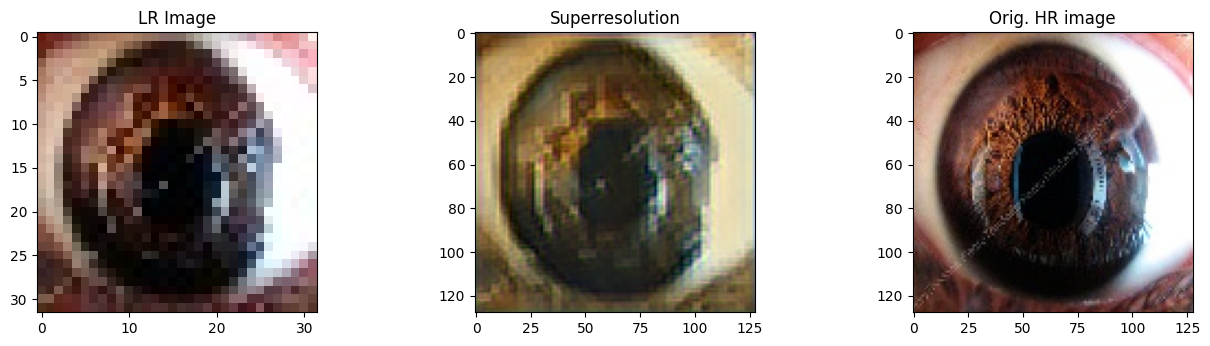

error: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - Can't parse 'dsize'. Expected sequence length 2, got 3
>  - Can't parse 'dsize'. Expected sequence length 2, got 3


In [7]:

###################################################################################
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

generator = load_model('GAN/gen_e_2.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()


################################################
sreeni_hr = cv2.imread("source/baboon.bmp")

sreeni_lr = cv2.resize(sreeni_hr, (32, 32, 3))

#Change images from BGR to RGB for plotting. 
#Remember that we used cv2 to load images which loads as BGR.
sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

sreeni_lr = sreeni_lr / 255.
sreeni_hr = sreeni_hr / 255.

sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

generated_sreeni_hr = generator.predict(sreeni_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(sreeni_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sreeni_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(sreeni_hr[0,:,:,:])

plt.show()

In [ ]:
epochs = 15
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    generator.save("GAN/gen_e_"+ str(e+6) +".h5")